In [1]:
import os
import random
import numpy as np
import pandas as pd
import torch
from torch.cuda.amp import autocast, GradScaler
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from scipy.optimize import curve_fit
from scipy.stats import linregress, ks_2samp
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.feature_selection import mutual_info_regression
from scipy import stats
import warnings
from scipy.optimize import OptimizeWarning

torch.set_num_threads(1)

scaler = GradScaler()

warnings.filterwarnings("ignore", category=OptimizeWarning)
warnings.filterwarnings(
    "ignore",
    category=RuntimeWarning,
    module="scipy.optimize._minpack_py"
)

# Choose GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# === Utils ===

_ds_cache = {}

def get_data(ds_name: str, resize: int):
    """
    Return a torchvision Dataset for `ds_name` ('cifar' or 'mnist'),
    resized to (resize × resize).  Downloads only on first call.
    """
    key = (ds_name, resize)
    if key not in _ds_cache:
        # pick the right class
        DataClass = datasets.CIFAR10 if ds_name == 'cifar' else datasets.MNIST

        # build & stash it
        tf = transforms.Compose([
            transforms.Resize((resize, resize)),
            transforms.ToTensor(),
        ])
        _ds_cache[key] = DataClass(
            './data',
            train=False,
            download=True,
            transform=tf
        )
    return _ds_cache[key]

def set_random_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def summarize_sd(arr):
    arr = np.asarray(arr, float)
    arr = arr[~np.isnan(arr)]
    if arr.size == 0:
        return "n/a"
    return f"{arr.mean():.3f} ± {arr.std():.3f} (SD, n={len(arr)})"

def choose_summary(key, arr):
    if key in {"global_pvalue", "mean_mi_pval"}:
        return summarize_p(arr)
    if key == "mean_mi_std_lambda":
        return summarize_sd(arr)
    # default → 95 % CI
    return summarize_ci(arr)

def summarize_ci(arr, alpha=0.05):
    """
    mean ± 95 % CI (Student-t, two-sided).
    Returns 'n/a' if nothing to summarise.
    """
    arr = np.asarray(arr, dtype=float)
    arr = arr[~np.isnan(arr)]
    n   = len(arr)
    if n == 0:
        return "n/a"
    mean = arr.mean()
    sem  = stats.sem(arr)               
    half = stats.t.ppf(1-alpha/2, n-1) * sem
    return f"{mean:.3f} ± {half:.3f} (95 % CI, n={n})"

def summarize_p(arr):
    """median [IQR] for p-values – unchanged."""
    arr = np.asarray(arr, dtype=float)
    arr = arr[~np.isnan(arr)]
    if arr.size == 0:
        return "n/a"
    q25, q75 = np.percentile(arr, [25, 75])
    return f"{np.median(arr):.3f} [IQR {q25:.3f}–{q75:.3f}] (n={len(arr)})"

# === Models ===
class ModularCNN(nn.Module):
    def __init__(
        self,
        conv_channels,
        kernel_sizes,
        strides,
        use_leaky_relu: bool = False,
        use_batchnorm: bool = False,
        in_channels: int = 3
    ):
        super().__init__()
        self.convs = nn.ModuleList()
        self.bns   = nn.ModuleList() if use_batchnorm else None
        self.use_bn = use_batchnorm
        self.strides = strides
        self.kernel_sizes = kernel_sizes
        self.use_leaky = use_leaky_relu
        for out_ch, k, s in zip(conv_channels, kernel_sizes, strides):
            conv = nn.Conv2d(in_channels, out_ch, kernel_size=k, padding=k//2, bias=True)
            self.convs.append(conv)
            if use_batchnorm:
                self.bns.append(nn.BatchNorm2d(out_ch))
            in_channels = out_ch

    def forward(self, x):
        activations = []
        for idx, conv in enumerate(self.convs):
            x = conv(x)
            if self.use_bn:
                x = self.bns[idx](x)
            x = F.leaky_relu(x, 0.01) if self.use_leaky else F.relu(x)
            activations.append(x.clone())
            s = self.strides[idx]
            x = F.avg_pool2d(x, kernel_size=s)
        return activations

class ResNetBlock(nn.Module):
    def __init__(
        self,
        in_ch: int,
        out_ch: int,
        stride: int = 1,
        kernel_size: int = 3,
        bottleneck_ratio: float = 1.0,
        projection_type: str = 'identity',
        activation: str = 'relu'
    ):
        super().__init__()
        mid_ch = int(out_ch * bottleneck_ratio)
        # 1st conv
        self.conv1 = nn.Conv2d(in_ch, mid_ch, kernel_size, stride, kernel_size//2, bias=False)
        self.bn1   = nn.BatchNorm2d(mid_ch)
        # 2nd conv
        self.conv2 = nn.Conv2d(mid_ch, out_ch, kernel_size, 1, kernel_size//2, bias=False)
        self.bn2   = nn.BatchNorm2d(out_ch)
        # shortcut
        if projection_type == 'conv1x1' or stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 1, stride, bias=False),
                nn.BatchNorm2d(out_ch)
            )
        else:
            self.shortcut = nn.Identity()
        # activation
        if activation == 'leaky_relu':
            self.act = lambda x: F.leaky_relu(x, 0.01)
        else:
            self.act = F.relu

    def forward(self, x):
        y = self.act(self.bn1(self.conv1(x)))
        y = self.bn2(self.conv2(y))
        y = y + self.shortcut(x)
        return self.act(y)

class ModularResNet(nn.Module):
    def __init__(
        self,
        channels,
        block_sizes,
        kernel_sizes,
        strides,
        bottleneck_ratios,
        projection_types,
        activation_functions,
        in_channels: int = 3
    ):
        super().__init__()
        # stem
        self.conv1 = nn.Conv2d(in_channels, channels[0], kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(channels[0])
        self.act1  = F.relu
        self.in_ch = channels[0]
        # store params
        self.channels = channels
        self.block_sizes = block_sizes
        self.kernel_sizes = kernel_sizes
        self.strides_list = strides
        self.bottleneck_ratios = bottleneck_ratios
        self.projection_types = projection_types
        self.activation_functions = activation_functions
        # build layers
        self.layers = nn.ModuleList()
        for idx in range(len(channels)):
            self.layers.append(self._make_layer(
                out_ch = channels[idx],
                num_blocks = block_sizes[idx],
                stride = strides[idx],
                kernel_size = kernel_sizes[idx],
                bottleneck_ratio = bottleneck_ratios[idx],
                projection_type = projection_types[idx],
                activation = activation_functions[idx]
            ))

    def _make_layer(
        self,
        out_ch,
        num_blocks,
        stride,
        kernel_size,
        bottleneck_ratio,
        projection_type,
        activation
    ):
        blocks = []
        # first block
        blocks.append(ResNetBlock(
            self.in_ch, out_ch, stride,
            kernel_size, bottleneck_ratio,
            projection_type, activation
        ))
        self.in_ch = out_ch
        # rest
        for _ in range(1, num_blocks):
            blocks.append(ResNetBlock(
                self.in_ch, out_ch, 1,
                kernel_size, bottleneck_ratio,
                'identity', activation
            ))
        return nn.Sequential(*blocks)

    def forward(self, x):
        acts = []
        x = self.act1(self.bn1(self.conv1(x)))
        acts.append(x.clone())
        for layer in self.layers:
            x = layer(x)
            acts.append(x.clone())
        return acts

# === Architecture Generators ===
def generate_random_cnn(
    n_layers: int,
    stride_choices,
    kernel_choices,
    channel_choices,
    input_size: int,
    in_channels: int,
    use_leaky_relu: bool,
    use_batchnorm: bool
):
    size = input_size
    channels, kernels, strides = [], [], []
    for _ in range(n_layers):
        s = random.choice([st for st in stride_choices if size >= 2*st] or [1])
        k = random.choice(kernel_choices)
        c = random.choice(channel_choices)
        strides.append(s)
        kernels.append(k)
        channels.append(c)
        size = max(1, size // s)
    return ModularCNN(channels, kernels, strides, use_leaky_relu, use_batchnorm, in_channels)

def generate_random_resnet(
    n_layers: int,
    channel_choices,
    input_size: int,
    in_channels: int,
    block_sizes,
    kernel_sizes,
    stride_choices,
    bottleneck_ratios,
    projection_types,
    activation_functions
):
    """
    Build a random ResNet with n_layers blocks. For each block we sample:
      - out_channels from channel_choices
      - num_blocks from block_sizes
      - kernel_size from kernel_sizes
      - stride from stride_choices (only if spatial size allows)
      - bottleneck_ratio from bottleneck_ratios
      - projection_type from projection_types
      - activation from activation_functions
    """
    size = input_size
    channels, blocks, ks, strides, brs, pts, afs = [], [], [], [], [], [], []

    # Sample up to n_layers (stop early if spatial collapses)
    for _ in range(n_layers):
        c  = random.choice(channel_choices)
        b  = random.choice(block_sizes)
        k  = random.choice(kernel_sizes)
        br = random.choice(bottleneck_ratios)
        pt = random.choice(projection_types)
        af = random.choice(activation_functions)

        # only allow stride>1 if size>=2*stride
        possible_strides = [s for s in stride_choices if size >= 2*s]
        s = random.choice(possible_strides) if possible_strides else 1

        channels.append(c)
        blocks.append(b)
        ks.append(k)
        strides.append(s)
        brs.append(br)
        pts.append(pt)
        afs.append(af)

        size = max(1, size // s)
        if size <= 1:
            break

    return ModularResNet(
        channels       = channels,
        block_sizes    = blocks,
        kernel_sizes   = ks,
        strides        = strides,
        bottleneck_ratios   = brs,
        projection_types    = pts,
        activation_functions= afs,
        in_channels    = in_channels
    )

# === Property Extraction ===
def extract_cnn_properties(model: ModularCNN):
    strides, kernels, channels, depths, overlaps = [], [], [], [], []
    for i, conv in enumerate(model.convs):
        k = model.kernel_sizes[i]
        s = model.strides[i]
        c = conv.out_channels
        strides.append(s)
        kernels.append(k)
        channels.append(c)
        depths.append(i+1)
        overlaps.append((k - s) / k)
    return {
        's': np.array(strides),
        'r': np.array(kernels),
        'c': np.array(channels),
        'inv_c': 1/np.array(channels),
        'd': np.array(depths),
        'o': np.array(overlaps),
        's_r': np.array([s*r for s,r in zip(strides, kernels)])
    }

def extract_resnet_properties(model: ModularResNet):
    ks = model.kernel_sizes
    ss = model.strides_list
    br = model.bottleneck_ratios
    pt = model.projection_types
    af = model.activation_functions
    skip_width, block_depth, layer_index, channels, res_type = [], [], [], [], []
    kernel_size, stride, bottleneck, projection, activation, depths = [], [], [], [], [], []

    # initial conv
    layer = 1
    channels.append(model.conv1.out_channels)
    skip_width.append(0)
    block_depth.append(0)
    layer_index.append(layer)
    res_type.append(0)
    kernel_size.append(3)
    stride.append(1)
    bottleneck.append(1.0)
    projection.append(0)
    activation.append(0)
    depths.append(layer)
    layer += 1

    for li, seq in enumerate(model.layers):
        for bj, blk in enumerate(seq):
            in_ch = blk.conv1.in_channels
            out_ch = blk.conv2.out_channels
            has_proj = not isinstance(blk.shortcut, nn.Identity)

            skip_width.append(out_ch - in_ch if has_proj else 0)
            block_depth.append(bj)
            layer_index.append(layer)
            res_type.append(1 if has_proj else 0)

            if bj == 0:
                kernel_size.append(ks[li])
                stride.append(ss[li])
                bottleneck.append(br[li])
                projection.append(1 if pt[li] != 'identity' else 0)
                activation.append(1 if af[li]=='leaky_relu' else 0)
            else:
                kernel_size.append(ks[li])
                stride.append(1)
                bottleneck.append(br[li])
                projection.append(0)
                activation.append(1 if af[li]=='leaky_relu' else 0)

            channels.append(out_ch)
            depths.append(layer)
            layer += 1

    return {
        'skip_width': np.array(skip_width),
        'block_depth': np.array(block_depth),
        'layer_index': np.array(layer_index),
        'inv_c': 1/np.array(channels),
        'res_type': np.array(res_type),
        'kernel_size': np.array(kernel_size),
        'stride': np.array(stride),
        'bottleneck': np.array(bottleneck),
        'projection': np.array(projection),
        'activation': np.array(activation),
        'd': np.array(depths)
    }

def extract_model_properties(model):
    if isinstance(model, ModularCNN):
        return extract_cnn_properties(model)
    elif isinstance(model, ModularResNet):
        return extract_resnet_properties(model)
    else:
        raise ValueError("Unknown model type")

# === Metrics ===

def compute_lambda_i_empirical(model, x, noise_std=0.2, eps=1e-8):
    model.eval()
    with torch.no_grad():
        noisy = x + noise_std * torch.randn_like(x)
        clean_acts = model(x)
        noisy_acts = model(noisy)

    # stack → (L, …), flatten each activation, compute norms in one go
    deltas = torch.stack(
        [(n - c).flatten(1).norm(dim=1) for n, c in zip(noisy_acts, clean_acts)]
    ).squeeze()                       # shape (L,)

    lam = -torch.log((deltas[1:] + eps) / (deltas[:-1] + eps))
    return lam.cpu().numpy()


def compute_fisher_information(model, x):
    model.eval()
    xv = x.clone().requires_grad_(True)
    acts = model(xv)

    fisher = []
    for act in acts:
        # exactly the same mathematical expression as before
        loss = act.square().sum()
        (grad,) = torch.autograd.grad(loss, xv, retain_graph=True)
        fisher.append(grad.norm().item())

    return fisher

def mi_permutation_test(X, y, n_perm=200):
    n_neighbors = max(1, min(2, len(y) - 1))  
    actual_mi = mutual_info_regression(X, y, random_state=0, n_neighbors=n_neighbors)[0]
    perm_mis = []
    for _ in range(n_perm):
        y_perm = np.random.permutation(y)
        perm_mi = mutual_info_regression(X, y_perm, random_state=0, n_neighbors=n_neighbors)[0]
        perm_mis.append(perm_mi)
    pval = (np.sum(np.array(perm_mis) >= actual_mi) + 1) / (n_perm + 1)
    return actual_mi, pval

# === Regression & Analysis ===
def create_feature_matrix(raw, config):
    X, names, powers = [], [], []
    used = set()
    for c in config:
        name = c['name']
        if name not in raw or name in used:
            continue
        f = raw[name].astype(float).copy()
        used.add(name)
        if c.get('log', False):
            f = np.log1p(np.clip(f, 0, None))
        if c.get('power_law', False) or c.get('normalize', False):
            f = (f - f.min())/(f.max()-f.min()+1e-8)
        X.append(f)
        names.append(name)
        powers.append(c.get('power_law', False))
    return np.vstack(X), names, powers

def fit_model(X, y, powers, n_boot=100):
    import warnings
    from scipy.optimize import OptimizeWarning

    def model_fn(x, *p):
        total = np.zeros_like(x[0], dtype=float)
        idx = 0
        for j, pl in enumerate(powers):
            a = p[idx]
            if pl:
                b = p[idx+1]
                xj = x[j] + 1e-12
                # Safely calculate power term
                with np.errstate(over='ignore', invalid='ignore'):
                    log_xj = np.log(xj)
                    # Clip to avoid overflow in exp()
                    power = np.clip(b * log_xj, -500, 500)
                    term = np.exp(power)
                    # Clean up any invalid values
                    term = np.nan_to_num(term, nan=0.0, posinf=0.0, neginf=0.0)
                total += a * term
                idx += 2
            else:
                total += a * x[j]
                idx += 1
        total += p[idx]
        return total

    p0 = []
    for pl in powers:
        p0 += [0.1, 1.0] if pl else [0.1]
    p0 += [1.0]

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", OptimizeWarning)
        popt, _ = curve_fit(model_fn, X, y, p0=p0, maxfev=10000)

    pred = model_fn(X, *popt)
    rmse = np.sqrt(((y-pred)**2).mean())
    r2 = linregress(y, pred).rvalue**2

    samples = []
    for _ in tqdm(range(n_boot), desc="Bootstrapping", leave=False):
        idxs = np.random.choice(len(y), len(y), replace=True)
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", OptimizeWarning)
                pp, _ = curve_fit(model_fn, X[:,idxs], y[idxs], p0=p0, maxfev=5000)
            samples.append(pp)
        except:
            pass

    param_stds = np.std(np.stack(samples), axis=0) if samples else np.zeros_like(popt)
    return {'popt': popt, 'param_stds': param_stds, 'pred': pred, 'rmse': rmse, 'r2': r2, 'model_fn': model_fn}

def analyze_lambda_variation(model_depths, fisher_means, lambda_stds, n_levels=10, raw_props=None):
    """
    Bin models by their average Fisher information into n_levels,
    split each bin into shallow vs deep (25/75% quartiles of depth),
    compute mean(std(lambda)) in each half, and form the ratio.

    Parameters:
        model_depths: List of model depths (one per model)
        fisher_means: List of average Fisher information values (one per model)
        lambda_stds: List of lambda standard deviations (one per model)
        n_levels: Number of Fisher information levels to analyze

    Returns:
        df_rows: DataFrame with columns [fisher_level, num_candidates, shallow_mean, deep_mean, ratio]
        global_pvalue: KS-test p-value over all shallow vs deep lambda_stds pooled
    """

    # Convert inputs to numpy arrays and ensure they're valid
    depths = np.array(model_depths, dtype=float)
    fisher_means = np.array(fisher_means, dtype=float)
    lambda_stds = np.array(lambda_stds, dtype=float)

    # Safety check for inputs
    if (depths.size == 0 or fisher_means.size != depths.size or lambda_stds.size != depths.size):
        print("WARNING: Invalid input arrays for lambda variation analysis")
        return pd.DataFrame(), np.nan


    # Set up Fisher bins - use adaptive bin width to ensure sufficient models per bin
    # Instead of fixed percentiles, use linspace to cover the full range
    # This ensures better coverage with small sample sizes
    min_fisher = np.min(fisher_means)
    max_fisher = np.max(fisher_means)
    levels = np.linspace(min_fisher, max_fisher, n_levels)

    # Prepare for data collection
    rows = []
    cv_per_bin = []
    used_ids = set() 
    all_shallow = []
    all_deep = []

    # Use a dynamic tolerance based on data range
    delta = (max_fisher - min_fisher) / max(n_levels - 1, 1)
    base_tol = delta * 0.4999  # half-bin width ensures continuous coverage

    # Analyze each level
    for lvl in levels:
        # same for all levels
        tol = base_tol

        # Find models within this Fisher level
        idxs = np.where((fisher_means >= lvl - tol) & (fisher_means <= lvl + tol))[0]

        if idxs.size < 2:
            # Not enough models at this Fisher level
            rows.append({
                'fisher_level': lvl,
                'num_candidates': idxs.size,
                'shallow_mean': np.nan,
                'deep_mean': np.nan,
                'ratio': np.nan
            })
            continue

        # Get depths for these models
        d_bin = depths[idxs]

        # Quartile threshold - but ensure we get some models in each group
        if d_bin.size >= 4:
            low = np.percentile(d_bin, 33)  # Use 33rd percentile instead of 25th
            high = np.percentile(d_bin, 67)  # Use 67th percentile instead of 75th
            
            # Ensure the thresholds create distinct groups
            if low == high:
                low = np.min(d_bin)
                high = np.max(d_bin)
        else:
            # With very few models, just use min/max
            low = np.min(d_bin)
            high = np.max(d_bin)

        # Split into shallow and deep models
        # For small samples, we're more permissive about what counts as "shallow" or "deep"
        shallow_idx = idxs[d_bin <= low] 
        deep_idx = idxs[d_bin >= high]

        # If no models in either group, redefine thresholds more aggressively
        if shallow_idx.size == 0 or deep_idx.size == 0:
            # Use median split as fallback
            median = np.median(d_bin)
            shallow_idx = idxs[d_bin <= median]
            deep_idx = idxs[d_bin > median]

        # ───────── extra guard: skip bins where one group is still empty ───────
        if shallow_idx.size < 3 or deep_idx.size < 3:
            rows.append({
                'fisher_level' : lvl,
                'num_candidates': idxs.size,
                'n_shallow'    : shallow_idx.size,
                'n_deep'       : deep_idx.size,
                'ratio'        : np.nan,
                'cv_bin'       : np.nan
            })
            continue              # do NOT count this bin

        # Get lambda_std values for each group
        shallow_vals = lambda_stds[shallow_idx]
        deep_vals = lambda_stds[deep_idx]

        # Collect values for global test
        all_shallow.extend(shallow_vals)
        all_deep.extend(deep_vals)

        # Calculate means
        shallow_mean = np.nanmean(shallow_vals) if shallow_vals.size > 0 else np.nan
        deep_mean = np.nanmean(deep_vals) if deep_vals.size > 0 else np.nan
        
        # Calculate ratio with safeguards
        # Paper reports deep/shallow ratio, so we calculate it this way
        ratio = deep_mean / shallow_mean if (shallow_mean > 0 and not np.isnan(shallow_mean) and not np.isnan(deep_mean)) else np.nan

        # ── NEW: per-bin CV of σλ, only when ≥5 models ───────────────────────────
        if idxs.size >= 5:
            cv_bin = np.std(lambda_stds[idxs]) / (np.mean(lambda_stds[idxs]) + 1e-12)
        else:
            cv_bin = np.nan
        cv_per_bin.append(cv_bin)

        rows.append({
            'fisher_level': lvl,
            'num_candidates': idxs.size,
            'shallow_mean': shallow_mean,
            'deep_mean': deep_mean,
            "n_shallow": shallow_vals.size,
            "n_deep": deep_vals.size,
            'ratio': ratio,
            'cv_bin': cv_bin
        })
        used_ids.update(idxs)

    # Convert to DataFrame
    df = pd.DataFrame(rows)
    
    # Calculate global statistics
    all_shallow = np.array(all_shallow)
    all_deep = np.array(all_deep)
    
    # Global KS test
    if len(all_shallow) > 1 and len(all_deep) > 1:
        global_p = ks_2samp(all_shallow, all_deep).pvalue
    else:
        global_p = np.nan
    
    # Print summary
    valid_ratios = df['ratio'].dropna()
    if len(valid_ratios) > 0:
        mean_ratio = valid_ratios.mean()
    else:
        print("WARNING: No valid lambda variation ratios calculated!")

    # Mutual Information with architecture features (per bin)
    mi_scores, mi_pvals = [], []
    for idxs in [np.where((fisher_means >= lvl - base_tol) & (fisher_means <= lvl + base_tol))[0] for lvl in levels]:
        if len(idxs) < 2: continue
        try:
            X_bin = []
            keys = list(raw_props.keys())
            for i in idxs:
                vec = [raw_props[k][i] for k in keys if k in raw_props]
                X_bin.append(vec)
            X_bin = np.array(X_bin)
            y_bin = np.array(lambda_stds)[idxs]
            if X_bin.ndim == 2 and X_bin.shape[1] > 0:
                mi, p = mi_permutation_test(X_bin, y_bin)
                mi_scores.append(mi)
                mi_pvals.append(p)
        except Exception as e:
            print(f"[MI Test] Failed in bin at FI ≈ {np.mean(np.array(fisher_means)[idxs]):.2f}: {e}")

    df['mi_std_lambda'] = mi_scores + [np.nan] * (len(df) - len(mi_scores))
    df['mi_pval'] = mi_pvals + [np.nan] * (len(df) - len(mi_pvals))

    # ── aggregate CV stats for this run ───────────────────
    cv_bins   = [v for v in cv_per_bin if not np.isnan(v)]
    cv_bins_m = np.mean(cv_bins) if cv_bins else np.nan   # mean  CV across bins
    cv_bins_s = np.std (cv_bins) if cv_bins else np.nan   # st-dev CV across bins
    cv_bins_max = np.max(cv_bins) if cv_bins else np.nan  # max   CV across bins

    n_models_used = len(used_ids)
    

    return {
    "per_bin": df,
    "global_p": global_p,
    "n_models_used": n_models_used,
    "cv_bins_mean": cv_bins_m,
    "cv_bins_std": cv_bins_s,
    "cv_bins_max": cv_bins_max
    }

def plot_key_results(results, title_suffix=""):
    raw = results['raw']; emp = results['empirical']; pred = results['predicted']
    fish_flat = results['fisher_flat']; lam_flat = results['lambda_flat']
    grouped = results['grouped']
    plt.figure(figsize=(8,6))
    plt.scatter(pred, emp, alpha=0.5)
    m,M = np.min(emp), np.max(emp)
    plt.plot([m,M],[m,M],'r--')
    plt.xlabel("Predicted λᵢ"); plt.ylabel("Empirical λᵢ")
    plt.title(f"Pred vs Emp{title_suffix}"); plt.grid(True); plt.show()
    plt.figure(figsize=(8,6))
    plt.errorbar(grouped['depth'], grouped['mean'], yerr=grouped['std'], fmt='o-')
    plt.xlabel("Depth"); plt.ylabel("Fisher Info")
    plt.title(f"Fisher vs Depth{title_suffix}"); plt.grid(True); plt.show()

# === Experiment Runner ===
def run_experiment(cfg):
    # ───────────────────────────── SET-UP ──────────────────────────────
    set_random_seed(cfg['seed'])
    ds = cfg['dataset'].lower()
    base, ch = (32, 3) if ds == 'cifar' else (28, 1)
    scale = random.uniform(*cfg['resize_range'])
    tgt = int(base * scale)

    print(f"Running run_id       : {cfg['run_id']}")
    print(f"\nResize scale factor  : {scale:.2f}  →  target size {tgt}")

    data = get_data(ds, tgt)
    n = max(1, int(len(data) * cfg['data_fraction']))
    idx = np.random.choice(len(data), n, replace=False)
    samples = [data[i][0] for i in idx]
    x = torch.stack(samples, dim=0).to(device)
    noise_std = cfg['noise_std']
    input_size, in_channels = tgt, ch

    print(f"Input shape          : {tuple(x.shape)}")

    # ───────────────────── GENERATE & MEASURE MODELS ────────────────────
    data_pts, fisher_vals, lambda_vals = [], [], []
    lambda_stds, model_depths          = [], []

    def _measure_model(model):
        # 1) λᵢ in mixed precision
        with autocast():
            lam_raw = compute_lambda_i_empirical(model, x, noise_std)  # returns np.ndarray

        # 2) collapse per-sample if needed
        lam = lam_raw.mean(axis=1) if lam_raw.ndim>1 else lam_raw
        if len(lam) < 3:
            return None

        # 3) Fisher in full precision
        with autocast(enabled=False):
            fish = compute_fisher_information(model, x)

        # 4) Build rows ...
        props = extract_model_properties(model)
        ml = min(len(lam)+1, len(fish))
        for k in props:
            props[k] = props[k][:ml]

        rows = []
        for j in range(ml-1):
            rows.append({**{k: props[k][j] for k in props},
                        'empirical': float(lam[j])})
        return lam, fish, rows

    # ───── SERIAL: build, move to GPU, measure, then delete ─────────────
    for _ in tqdm(range(cfg['n_models']), desc="Measuring models"):
        # build
        depth = random.choice(cfg['depth_choices'])
        if cfg['architecture'] == 'cnn':
            model = generate_random_cnn(
                depth,
                cfg['param_ranges']['strides'],
                cfg['param_ranges']['kernels'],
                cfg['param_ranges']['channels'],
                input_size, in_channels,
                cfg.get('use_leaky_relu', True),
                cfg.get('use_batchnorm', False)
            ).to(device)
        else:
            pr = cfg['param_ranges']
            model = generate_random_resnet(
                depth, pr['channels'], input_size, in_channels,
                pr['block_sizes'], pr['kernel_sizes'], pr['strides'],
                pr['bottleneck_ratios'], pr['projection_types'],
                pr['activation_functions']
            ).to(device)

        # measure
        res = _measure_model(model)
        # immediately delete model and free GPU
        del model

        if res is None:
            continue

        lam, fish, rows = res
        lambda_stds.append(float(np.std(lam)))
        model_depths.append(len(lam) + 1)
        fisher_vals.append(fish[:-1])     # align with λ
        lambda_vals.append(lam)
        data_pts.extend(rows)

    torch.cuda.empty_cache()


    # ───────────────────────────── SAFETY CHECK ────────────────────────
    if not data_pts:
        print("No valid data collected for this run.")
        return {
            'run_id': cfg['run_id'],
            'architecture': cfg['architecture'],
            'dataset': cfg['dataset'],
            'lambda_r2': np.nan,
            'lambda_rmse': np.nan
        }

    # ─────────────── BASIC COUNTS & UNIQUE DATA POINTS ────────────────
    n_models_valid = len(lambda_stds)
    print(f"Generated models accepted       : {n_models_valid}")
    print(f"Unique datapoints               : {len(set(tuple(d.items()) for d in data_pts))}")

    # ────────────────────────── BUILD ARRAYS ───────────────────────────
    df          = pd.DataFrame(data_pts)
    raw_props   = {c: df[c].values for c in df.columns if c != 'empirical'}
    empirical   = df['empirical'].values
    fisher_flat = np.concatenate(fisher_vals)
    lambda_flat = np.concatenate(lambda_vals)


    # ───────────────────────── λ REGRESSION ────────────────────────────
    X, feat_names, powers = create_feature_matrix(raw_props, cfg['feature_config'])
    fit = fit_model(X, empirical, powers, cfg['n_bootstrap'])

    print(">>> λᵢ Prediction")
    print(f"  R²    : {fit['r2']:.3f}")
    print(f"  RMSE  : {fit['rmse']:.3f}")
    print("  Coefficients:")
    idx = 0
    for j, name in enumerate(feat_names):
        if powers[j]:
            print(f"    {name:<10}: {fit['popt'][idx]:+.3f} × x^{fit['popt'][idx+1]:.3f}")
            idx += 2
        else:
            print(f"    {name:<10}: {fit['popt'][idx]:+.3f}")
            idx += 1
    print(f"    bias       : {fit['popt'][-1]:+.3f}")

    # ───────────────────────── FI REGRESSION ───────────────────────────
    fit_f = fit_model(X, fisher_flat, powers, cfg['n_bootstrap'])
    print(">>> Fisher Prediction")
    print(f"  R²    : {fit_f['r2']:.3f}")
    print(f"  RMSE  : {fit_f['rmse']:.3f}")
    print("  Coefficients:")
    idx = 0
    for j, name in enumerate(feat_names):
        if powers[j]:
            print(f"    {name:<10}: {fit_f['popt'][idx]:+.3f} × x^{fit_f['popt'][idx+1]:.3f}")
            idx += 2
        else:
            print(f"    {name:<10}: {fit_f['popt'][idx]:+.3f}")
            idx += 1
    print(f"    bias       : {fit_f['popt'][-1]:+.3f}")

    # ───────────────────────── SCALING WITH DEPTH ──────────────────────
    slope_lambda = r_value_lambda = np.nan
    slope_fisher = r_value_fisher = np.nan
    try:
        mask = (lambda_flat > 0) & (raw_props['d'] > 0)
        log_l = np.log(lambda_flat[mask] + 1e-8)
        log_d = np.log(raw_props['d'][mask] + 1e-8)
        slope_lambda, _, r_value_lambda, _, _ = linregress(log_d, log_l)
    except Exception:
        pass

    try:
        grp = (pd.DataFrame({'depth': raw_props['d'], 'fisher': fisher_flat})
               .groupby('depth')['fisher'].mean().reset_index())
        log_d2 = np.log(grp['depth'] + 1e-8)
        log_f2 = np.log(grp['fisher'] + 1e-8)
        slope_fisher, _, r_value_fisher, _, _ = linregress(log_d2, log_f2)
    except Exception:
        pass

    print("\n>>> Scaling with Depth")
    if not np.isnan(slope_lambda):
        print(f"  λᵢ  ~ depth^{slope_lambda:.3f}   (R² = {r_value_lambda**2:.3f})")
    if not np.isnan(slope_fisher):
        print(f"  F   ~ depth^{slope_fisher:.3f}   (R² = {r_value_fisher**2:.3f})")

    # ─────────────────────── LAMBDA-VARIATION ANALYSIS ─────────────────
    fisher_means = [np.mean(f) for f in fisher_vals]
    var_stats = analyze_lambda_variation(
        model_depths, fisher_means, lambda_stds,
        cfg['n_variance_levels'], raw_props=raw_props
    )
    df_var    = var_stats["per_bin"]
    global_p           = var_stats["global_p"]
    n_models_used_in_bins = var_stats["n_models_used"]
    cv_bins_m          = var_stats["cv_bins_mean"]
    cv_bins_s          = var_stats["cv_bins_std"]
    cv_bins_max        = var_stats["cv_bins_max"]

    # Quick summary for run-level report
    if 'ratio' in df_var.columns and df_var['ratio'].notna().any():
        lambda_var_ratio = df_var['ratio'].mean()
        n_fi_bins_valid  = df_var['ratio'].notna().sum()
    else:
        lambda_var_ratio = np.nan
        n_fi_bins_valid  = 0
    
    lambda_var_std    = df_var['ratio'].std(skipna=True)

    # Pretty print
    print("\n>>> Per Fisher Bin Analysis")
    if n_fi_bins_valid:
        print(f"  Fisher range    : [{min(fisher_means):.2f}, {max(fisher_means):.2f}]")
        print(f"  Depth  range    : [{min(model_depths)}, {max(model_depths)}]")
        print(f"  std(λ) range    : [{min(lambda_stds):.2f}, {max(lambda_stds):.2f}]")
        print(f"  Valid FI bins   : {n_fi_bins_valid} / {cfg['n_variance_levels']}")
        for _, r in df_var.dropna(subset=['ratio']).iterrows():
            print(f"    FI ≈ {r['fisher_level']:.2f}"
                  f" | Shallow: {int(r['n_shallow'])}"
                  f", Deep: {int(r['n_deep'])}"
                  f", Ratio: {r['ratio']:.3f}")
        print(f"  λ variation ratio : {lambda_var_ratio:.3f} ± {lambda_var_std:.3f} "
              f"(p = {global_p:.4f})")
        print(f"  mean CV(bin)       : {cv_bins_m:.3f}  ± {cv_bins_s:.3f}")
        print(f"  max  CV(bin)       : {cv_bins_max:.3f}")
        print(f"  Mutual information (std λ  vs. architecture features) per FI‐bin:")
        print(df_var[['fisher_level','mi_std_lambda','mi_pval']].to_string(index=False))

    else:
        print("  No valid bins found.")

    # ───────── COUNTERS FOR GLOBAL SUMMARY ─────────
    n_models_accepted     = len(lambda_stds)
    n_models_used_in_bins = n_models_used_in_bins      # value returned by analyze_lambda_variation
    n_lambda_vals         = len(lambda_flat)           # one λᵢ per layer-gap
    n_fisher_vals         = len(fisher_flat)           # one FI per layer
    n_fi_bins_attempted   = cfg['n_variance_levels']
    n_fi_bins_valid       = int(df_var['ratio'].notna().sum())

    # ────────────────────────── STABILITY METRICS ──────────────────────
    cv_lambda_std = mean_sigma = std_sigma = cv_sigma = np.nan
    if lambda_stds:
        cv_lambda_std = np.std(lambda_stds) / (np.mean(lambda_stds) + 1e-12)
        ratios = (np.array(lambda_stds) ** 2) * (np.array(model_depths) - 1)
        mean_sigma, std_sigma = np.mean(ratios), np.std(ratios)
        cv_sigma = std_sigma / (mean_sigma + 1e-12) 

    print("\n>>> Geometric Stability across all models")
    print(f"  Mean σ²×(L-1)    : {mean_sigma: .3e}")
    print(f"  Std  σ²×(L-1)    : {std_sigma: .3e}")
    print(f"  CV   σ²×(L-1) : {cv_sigma: .3e}\n") 

    # ─────────── σ² vs 1/(L-1) SCALING REGRESSION ───────────
    try:
        inv_L = 1.0 / (np.array(model_depths) - 1 + 1e-12)
        sigma2 = (np.array(lambda_stds) ** 2)
        slope, intercept, r_val, p_val, _ = linregress(inv_L, sigma2)
        print(">>> σ² versus 1/(L-1) regression")
        print(f"  σ² = {slope:.3e}·(1/(L-1)) + {intercept:.3e}  (R² = {r_val**2:.3f})")
    except Exception as e:
        print(f"[σ² regression failed: {e}]")

    # ───────────────────────── OPTIONAL PLOTS ──────────────────────────
    if cfg['make_plots']:
        grp_summary = (pd.DataFrame({'depth': raw_props['d'],
                                     'fisher': fisher_flat})
                       .groupby('depth')['fisher'].agg(['mean', 'std']).reset_index())
        plot_key_results(dict(
            raw=raw_props, empirical=empirical, predicted=fit['pred'],
            fisher_flat=fisher_flat, lambda_flat=lambda_flat,
            grouped=grp_summary
        ), title_suffix=f" ({cfg['run_id']})")

        # ─── New panel: σ² vs 1/(L-1) ───
        inv_L = 1.0 / (np.array(model_depths) - 1 + 1e-12)
        sigma2 = np.array(lambda_stds) ** 2
        slope, intercept, r_val, p_val, _ = linregress(inv_L, sigma2)

        plt.figure(figsize=(8,6))
        plt.scatter(inv_L, sigma2, alpha=0.6, label="data")
        x_line = np.array([inv_L.min(), inv_L.max()])
        y_line = slope * x_line + intercept
        plt.plot(x_line, y_line, linestyle='--',
                 label=f"slope={slope:.2e}, $R^2$={r_val**2:.2f}")
        plt.xlabel("1 / (L - 1)")
        plt.ylabel(r"$\sigma^2_\lambda$")
        plt.title(f"Scaling of σ² vs 1/(L-1) ({cfg['run_id']})")
        plt.legend()
        plt.grid(True)
        plt.show()

    # ──────────────────── RETURN DICT ──────────────────────

    return {
        'run_id': cfg['run_id'],
        'architecture': cfg['architecture'],
        'dataset': cfg['dataset'],
        'n_models_accepted': n_models_accepted,
        'n_models_used_in_bins' : n_models_used_in_bins,
        'n_lambda_vals'    : n_lambda_vals,
        'n_fisher_vals'    : n_fisher_vals,
        'n_fi_bins_attempted': n_fi_bins_attempted,
        'n_fi_bins_valid'    : n_fi_bins_valid,
        'lambda_r2': fit['r2'], 'lambda_rmse': fit['rmse'],
        'lambda_popt': fit['popt'], 'lambda_param_stds': fit['param_stds'],
        'fisher_r2': fit_f['r2'], 'fisher_rmse': fit_f['rmse'],
        'fisher_popt': fit_f['popt'], 'fisher_param_stds': fit_f['param_stds'],
        'feature_names': feat_names, 'powers': powers,
        'lambda_depth_slope': slope_lambda,
        'lambda_depth_r2': (r_value_lambda ** 2) if not np.isnan(r_value_lambda) else np.nan,
        'fisher_depth_slope': slope_fisher,
        'fisher_depth_r2': (r_value_fisher ** 2) if not np.isnan(r_value_fisher) else np.nan,
        'lambda_variation_ratio': lambda_var_ratio,
        'global_pvalue': global_p,
        'cv_bins_mean': cv_bins_m,
        'cv_bins_std' : cv_bins_s,
        'cv_bins_max' : cv_bins_max,
        'mean_mi_std_lambda': df_var['mi_std_lambda'].mean() if 'mi_std_lambda' in df_var else np.nan,
        'mean_mi_pval':       df_var['mi_pval'].mean()       if 'mi_pval'       in df_var else np.nan,
        'cv_lambda_std': cv_lambda_std,
        'mean_sigma2_ratio': mean_sigma,
        'std_sigma2_ratio': std_sigma,
        'cv_sigma2_ratio'  : cv_sigma
    }

def analyze_experiment_results(results_list):
    import numpy as np
    from collections import defaultdict

    overall = defaultdict(list)
    by_group = defaultdict(lambda: defaultdict(list))

    # ----- GLOBAL TOTALS -------------------------------------------------
    total_models          = 0
    total_lambda          = 0
    total_fisher          = 0
    total_bins_attempted  = 0
    total_bins_valid      = 0
    total_models_used_in_bins = 0

    for res in results_list:
        total_models         += int(res.get('n_models_accepted',   0))
        total_lambda         += int(res.get('n_lambda_vals',       0))
        total_fisher         += int(res.get('n_fisher_vals',       0))
        total_bins_attempted += int(res.get('n_fi_bins_attempted', 0))
        total_bins_valid     += int(res.get('n_fi_bins_valid',     0))
        total_models_used_in_bins += int(res.get('n_models_used_in_bins', 0))

    for res in results_list:
        key = f"{res['architecture'].upper()} / {res['dataset'].upper()}"
        overall['lambda_r2'].append(res.get('lambda_r2', np.nan))
        overall['lambda_rmse'].append(res.get('lambda_rmse', np.nan))
        overall['fisher_r2'].append(res.get('fisher_r2', np.nan))
        overall['fisher_rmse'].append(res.get('fisher_rmse', np.nan))
        overall['lambda_depth_slope'].append(res.get('lambda_depth_slope', np.nan))
        overall['lambda_depth_r2'].append(res.get('lambda_depth_r2', np.nan))
        overall['fisher_depth_slope'].append(res.get('fisher_depth_slope', np.nan))
        overall['fisher_depth_r2'].append(res.get('fisher_depth_r2', np.nan))
        overall['lambda_variation_ratio'].append(res.get('lambda_variation_ratio', np.nan))
        overall['global_pvalue'].append(res.get('global_pvalue', np.nan))
        overall['cv_bins_mean'].append(res.get('cv_bins_mean', np.nan))
        overall['cv_bins_std'] .append(res.get('cv_bins_std',  np.nan))
        overall['cv_bins_max'].append(res.get('cv_bins_max', np.nan))
        overall['mean_mi_std_lambda'].append(res.get('mean_mi_std_lambda', np.nan))
        overall['mean_mi_pval'].append(res.get('mean_mi_pval', np.nan))
        overall['mean_sigma2_ratio'].append(res.get('mean_sigma2_ratio', np.nan))
        overall['std_sigma2_ratio'].append(res.get('std_sigma2_ratio', np.nan))
        overall['cv_sigma2_ratio'].append(res.get('cv_sigma2_ratio', np.nan))
    
        for k in overall:
            by_group[key][k].append(res.get(k, np.nan))


    print("\n===== OVERALL EXPERIMENT SUMMARY =====")

    print("\n----- Experiments Metadata -----")
    print(f"Total models accepted : {total_models}")
    print(f"Total λᵢ values      : {total_lambda}")
    print(f"Total Fisher values  : {total_fisher}")
    print(f"Valid FI bins        : {total_bins_valid}")
    print(f"Total FI bins        : {total_bins_attempted}\n")
    print(f"Avg models per run     : {total_models / len(results_list):.2f}")
    print(f"Avg λᵢ per model       : {total_lambda / total_models:.2f}")
    print(f"Avg models used-in-bins : {total_models_used_in_bins / len(results_list):.2f}\n")

    print("----- Information Geometry Analysis -----")
    print("1. λ Prediction")
    print(f"  R²   : {summarize_ci(overall['lambda_r2'])}")
    print(f"  RMSE : {summarize_ci(overall['lambda_rmse'])}\n")
    print("2. Fisher Prediction")
    print(f"  R²   : {summarize_ci(overall['fisher_r2'])}")
    print(f"  RMSE : {summarize_ci(overall['fisher_rmse'])}\n")
    print("3. Scaling with Depth")
    print(f"  λ slope : {summarize_ci(overall['lambda_depth_slope'])}, R²={summarize_ci(overall['lambda_depth_r2'])}")
    print(f"  F slope : {summarize_ci(overall['fisher_depth_slope'])}, R²={summarize_ci(overall['fisher_depth_r2'])}\n")
    print("4. Per-FI-bin λ Variation")
    print(f"  Ratio (95 % CI) : {summarize_ci(overall['lambda_variation_ratio'])}")
    print(f"  Global KS-p     : {summarize_p(overall['global_pvalue'])}")
    print(f"  Runs p<0.05     : {np.sum(np.array(overall['global_pvalue'])<0.05)} / {len(overall['global_pvalue'])}\n")
    print("5. Per-FI-bin CV(σ)")
    print(f"  mean CV(bin) : {summarize_ci(overall['cv_bins_mean'])}")
    print(f"  max  CV(bin) : {summarize_ci(overall['cv_bins_max'])}\n")
    print("6. Mutual Information (σ vs architecture)")
    print(f"  MI(mean)  : {summarize_sd(overall['mean_mi_std_lambda'])}")
    print(f"  p-value   : {summarize_p(overall['mean_mi_pval'])}\n")
    print("7. Stability")
    print(f"  mean σ²×(L-1)  : {summarize_ci(overall['mean_sigma2_ratio'])}")
    print(f"  std σ²×(L-1)   : {summarize_ci(overall['std_sigma2_ratio'])}")
    print(f"  CV(σ²×(L-1))  : {summarize_ci(overall['cv_sigma2_ratio'])}\n")
    print("----- Breakdown by Architecture/Dataset -----")
    for grp, mets in by_group.items():
        print(f"\n{grp}:")
        print(f"  λ R²               : {summarize_ci(mets['lambda_r2'])}")
        print(f"  λ RMSE             : {summarize_ci(mets['lambda_rmse'])}")
        print(f"  Fisher R²          : {summarize_ci(mets['fisher_r2'])}")
        print(f"  Fisher RMSE        : {summarize_ci(mets['fisher_rmse'])}")
        print(f"  λ~depth slope/R²   : {summarize_ci(mets['lambda_depth_slope'])} / {summarize_ci(mets['lambda_depth_r2'])}")
        print(f"  F~depth slope/R²   : {summarize_ci(mets['fisher_depth_slope'])} / {summarize_ci(mets['fisher_depth_r2'])}")
        print(f"  λ variation ratio  : {summarize_ci(mets['lambda_variation_ratio'])}")
        print(f"  mean CV(bin)       : {summarize_ci(mets['cv_bins_mean'])}")
        print(f"  max  CV(bin)       : {summarize_ci(mets['cv_bins_max'])}")
        print(f"  global p-value     : {summarize_p(mets['global_pvalue'])}") 
        print(f"  mean σ²×(L-1)      : {summarize_ci(mets['mean_sigma2_ratio'])}")
        print(f"  std σ²×(L-1)       : {summarize_ci(mets['std_sigma2_ratio'])}")
        print(f"  CV σ²×(L-1)        : {summarize_ci(mets['cv_sigma2_ratio'])}")

    overall_summary = {k: choose_summary(k, overall[k]) for k in overall}

    by_group_summary = {
        g: {k: choose_summary(k, v) for k, v in mets.items()}
        for g, mets in by_group.items()
    }

    return {
        "overall": overall_summary,
        "by_group": by_group_summary,
    }

def run_statistical_consistency_experiments(
    seeds,
    architectures,
    datasets,
    data_fraction,
    n_models=100,
    make_plots=False,
    noise_levels=(0.1, 0.2),
    n_bootstrap=50,
    n_variance_levels=20,
    architecture_configs=None
):
    """
    Runs experiments over all combinations of seed, architecture, dataset and noise level.
    Each call to run_experiment gets a single scalar noise_std.
    """
    total = len(seeds) * len(architectures) * len(datasets) * len(noise_levels)
    count = 0
    all_results = []

    for seed in seeds:
        for arch in architectures:
            for ds in datasets:
                for noise in noise_levels:
                    count += 1
                    print("\n" + "=" * 60)
                    print(f"Experiment {count}/{total}: "
                          f"arch={arch}, dataset={ds}, seed={seed}, noise={noise}")

                    # build config for this run
                    cfg = {
                        'seed': seed,
                        'architecture': arch,
                        'dataset': ds,
                        'data_fraction': data_fraction,
                        'n_models': n_models,
                        'make_plots': make_plots,
                        # pass only one noise_std
                        'noise_std': noise,
                        'n_bootstrap': n_bootstrap,
                        'n_variance_levels': n_variance_levels,
                        # unique run_id
                        'run_id': f"{arch}_{ds}_s{seed}_n{noise}",
                        # bring in architecture-specific settings
                        **architecture_configs[arch]
                    }

                    # run it!
                    res = run_experiment(cfg)
                    all_results.append(res)

    # once all runs are done, aggregate
    analysis = analyze_experiment_results(all_results)
    return all_results, analysis

Using device: cuda



Experiment 1/60: arch=cnn, dataset=cifar, seed=1, noise=0.1
Running run_id       : cnn_cifar_s1_n0.1

Resize scale factor  : 1.40  →  target size 44
Files already downloaded and verified
Input shape          : (36, 3, 44, 44)


Measuring models: 100%|██████████| 100/100 [04:03<00:00,  2.43s/it]


Generated models accepted       : 89
Unique datapoints               : 2456


>>> λᵢ Prediction
  R²    : 0.492
  RMSE  : 0.939
  Coefficients:
    s_r       : +2.910 × x^2.003
    inv_c     : -6.454
    d         : -0.478
    o         : -3.152
    bias       : +4.512


>>> Fisher Prediction
  R²    : 0.096
  RMSE  : 2006.479
  Coefficients:
    s_r       : +1037.186 × x^0.509
    inv_c     : -4599.667
    d         : -430.602
    o         : -2595.175
    bias       : +3436.623

>>> Scaling with Depth
  λᵢ  ~ depth^-0.537   (R² = 0.134)
  F   ~ depth^-4.437   (R² = 0.622)

>>> Per Fisher Bin Analysis
  Fisher range    : [3.85, 6557.02]
  Depth  range    : [5, 100]
  std(λ) range    : [0.74, 2.29]
  Valid FI bins   : 3 / 20
    FI ≈ 3.85 | Shallow: 16, Deep: 17, Ratio: 0.658
    FI ≈ 348.76 | Shallow: 10, Deep: 9, Ratio: 0.917
    FI ≈ 693.66 | Shallow: 4, Deep: 4, Ratio: 0.971
  λ variation ratio : 0.849 ± 0.168 (p = 0.0346)
  mean CV(bin)       : 0.255  ± 0.024
  max  CV(bin)       : 0.288
  Mutual information (std λ  vs. architecture features) per FI‐bin:
 fisher_level  mi_std_lambda  mi_pval
     3.853471   5.939643e-04 0.517413
   348.757233   1.665335e-16 1.000000
   693.660995   1.110223e-16 1.000000
  1038.564757   1.110223e-16 1.000000
  1383

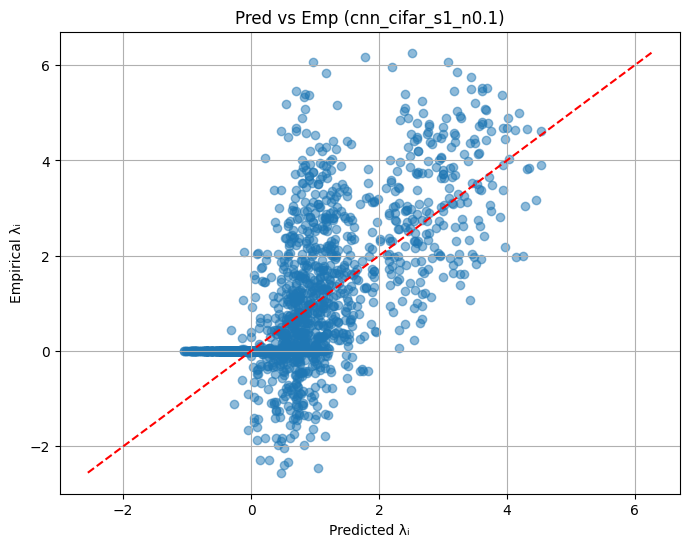

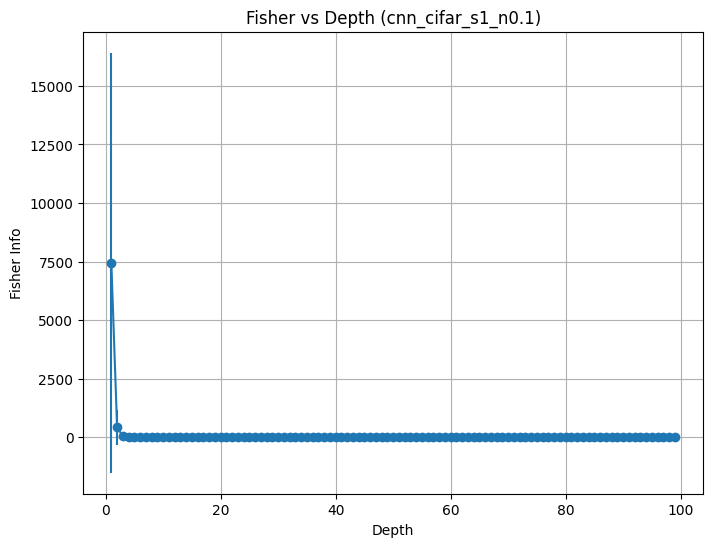

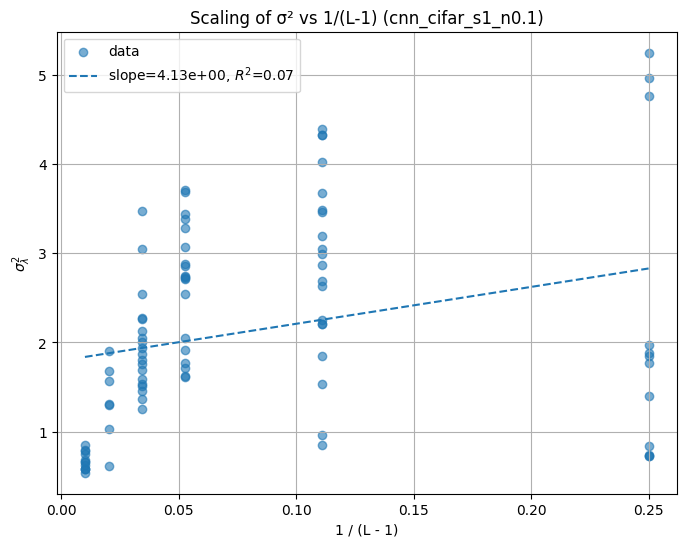


Experiment 2/60: arch=cnn, dataset=cifar, seed=1, noise=0.2
Running run_id       : cnn_cifar_s1_n0.2

Resize scale factor  : 1.40  →  target size 44
Input shape          : (36, 3, 44, 44)


Measuring models: 100%|██████████| 100/100 [03:59<00:00,  2.40s/it]


Generated models accepted       : 89
Unique datapoints               : 2457


>>> λᵢ Prediction
  R²    : 0.477
  RMSE  : 0.958
  Coefficients:
    s_r       : +2.761 × x^2.012
    inv_c     : -6.678
    d         : -0.497
    o         : -2.903
    bias       : +4.397


>>> Fisher Prediction
  R²    : 0.096
  RMSE  : 2006.479
  Coefficients:
    s_r       : +1037.186 × x^0.509
    inv_c     : -4599.667
    d         : -430.602
    o         : -2595.175
    bias       : +3436.623

>>> Scaling with Depth
  λᵢ  ~ depth^-0.441   (R² = 0.116)
  F   ~ depth^-4.437   (R² = 0.622)

>>> Per Fisher Bin Analysis
  Fisher range    : [3.85, 6557.02]
  Depth  range    : [5, 100]
  std(λ) range    : [0.73, 2.28]
  Valid FI bins   : 3 / 20
    FI ≈ 3.85 | Shallow: 16, Deep: 17, Ratio: 0.665
    FI ≈ 348.76 | Shallow: 10, Deep: 9, Ratio: 0.930
    FI ≈ 693.66 | Shallow: 4, Deep: 4, Ratio: 1.018
  λ variation ratio : 0.871 ± 0.184 (p = 0.0065)
  mean CV(bin)       : 0.245  ± 0.027
  max  CV(bin)       : 0.281
  Mutual information (std λ  vs. architecture features) per FI‐bin:
 fisher_level  mi_std_lambda  mi_pval
     3.853471   1.176715e-03 0.587065
   348.757233   1.665335e-16 1.000000
   693.660995   1.110223e-16 1.000000
  1038.564757   1.110223e-16 1.000000
  1383

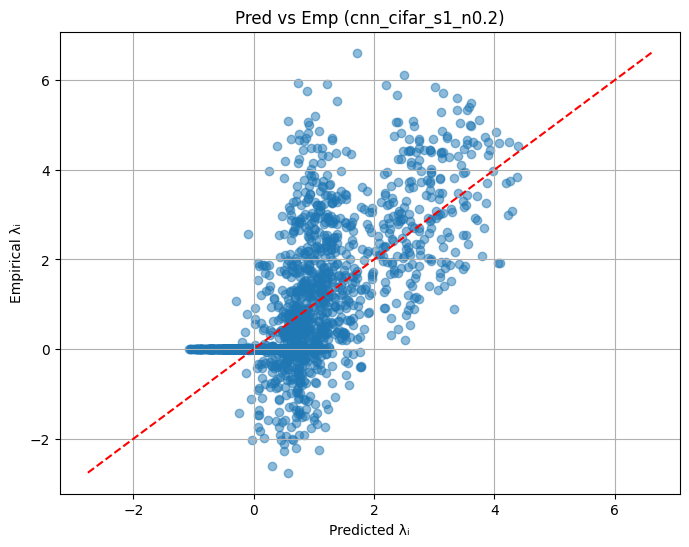

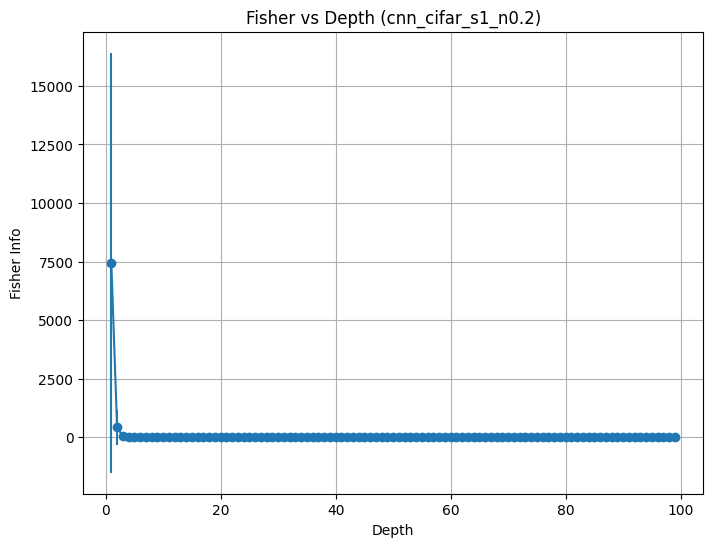

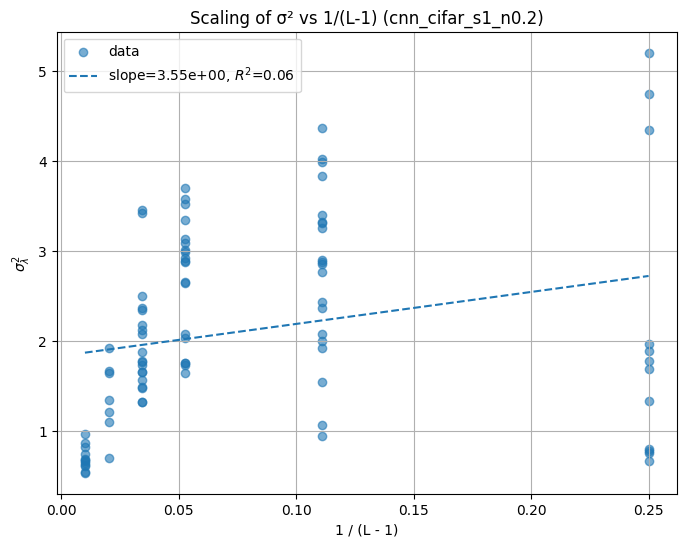


Experiment 3/60: arch=cnn, dataset=cifar, seed=1, noise=0.5
Running run_id       : cnn_cifar_s1_n0.5

Resize scale factor  : 1.40  →  target size 44
Input shape          : (36, 3, 44, 44)


Measuring models: 100%|██████████| 100/100 [03:58<00:00,  2.38s/it]


Generated models accepted       : 89
Unique datapoints               : 2459


>>> λᵢ Prediction
  R²    : 0.448
  RMSE  : 0.991
  Coefficients:
    s_r       : +2.471 × x^2.036
    inv_c     : -6.892
    d         : -0.522
    o         : -2.522
    bias       : +4.218


>>> Fisher Prediction
  R²    : 0.096
  RMSE  : 2006.479
  Coefficients:
    s_r       : +1037.186 × x^0.509
    inv_c     : -4599.667
    d         : -430.602
    o         : -2595.175
    bias       : +3436.623

>>> Scaling with Depth
  λᵢ  ~ depth^-0.403   (R² = 0.098)
  F   ~ depth^-4.437   (R² = 0.622)

>>> Per Fisher Bin Analysis
  Fisher range    : [3.85, 6557.02]
  Depth  range    : [5, 100]
  std(λ) range    : [0.73, 2.27]
  Valid FI bins   : 3 / 20
    FI ≈ 3.85 | Shallow: 16, Deep: 17, Ratio: 0.651
    FI ≈ 348.76 | Shallow: 10, Deep: 9, Ratio: 0.976
    FI ≈ 693.66 | Shallow: 4, Deep: 4, Ratio: 1.089
  λ variation ratio : 0.905 ± 0.227 (p = 0.0065)
  mean CV(bin)       : 0.239  ± 0.030
  max  CV(bin)       : 0.280
  Mutual information (std λ  vs. architecture features) per FI‐bin:
 fisher_level  mi_std_lambda  mi_pval
     3.853471   1.254035e-02 0.328358
   348.757233   1.665335e-16 1.000000
   693.660995   1.110223e-16 1.000000
  1038.564757   1.110223e-16 1.000000
  1383

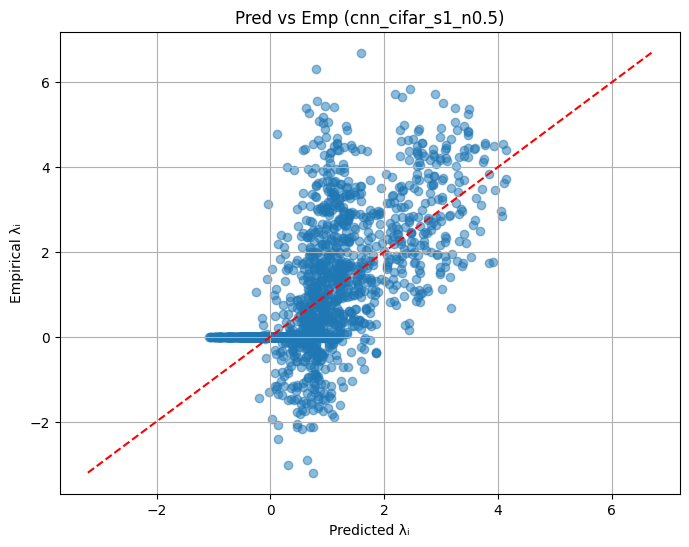

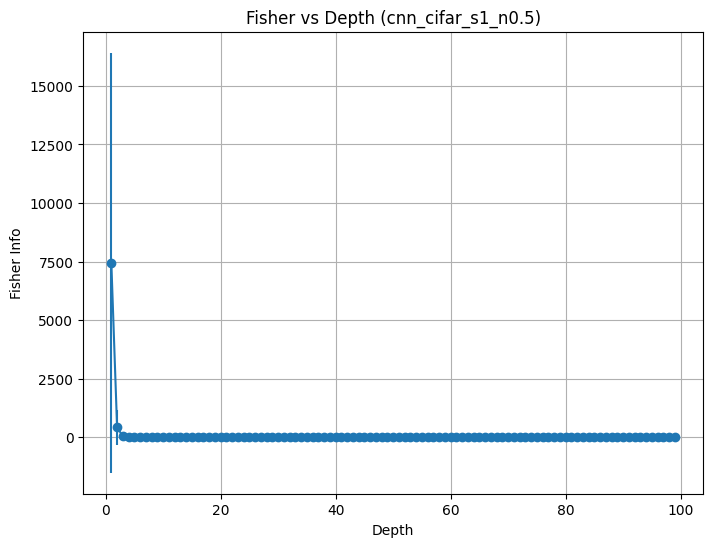

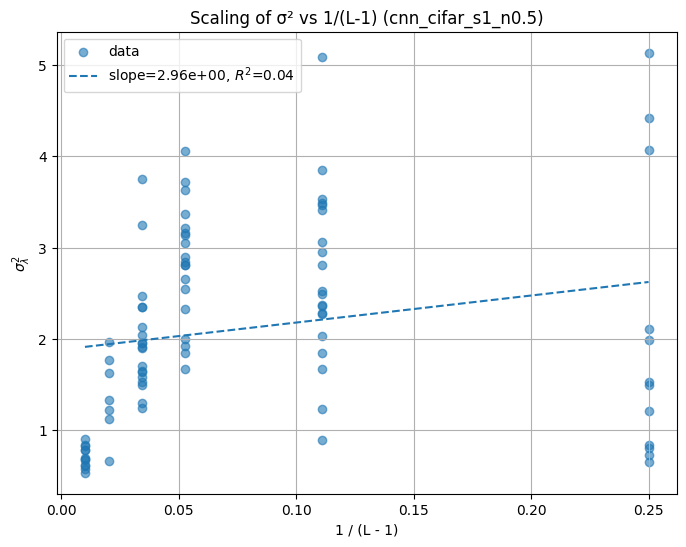


Experiment 4/60: arch=cnn, dataset=mnist, seed=1, noise=0.1
Running run_id       : cnn_mnist_s1_n0.1

Resize scale factor  : 1.40  →  target size 39
Input shape          : (36, 1, 39, 39)


Measuring models: 100%|██████████| 100/100 [03:49<00:00,  2.29s/it]


Generated models accepted       : 89
Unique datapoints               : 2457


>>> λᵢ Prediction
  R²    : 0.495
  RMSE  : 0.927
  Coefficients:
    s_r       : +2.796 × x^1.914
    inv_c     : -6.309
    d         : -0.484
    o         : -3.159
    bias       : +4.515


>>> Fisher Prediction
  R²    : 0.095
  RMSE  : 1992.491
  Coefficients:
    s_r       : +1084.137 × x^0.509
    inv_c     : -4510.738
    d         : -416.883
    o         : -2590.091
    bias       : +3355.264

>>> Scaling with Depth
  λᵢ  ~ depth^-0.534   (R² = 0.150)
  F   ~ depth^-4.383   (R² = 0.619)

>>> Per Fisher Bin Analysis
  Fisher range    : [4.05, 6749.14]
  Depth  range    : [5, 100]
  std(λ) range    : [0.76, 2.33]
  Valid FI bins   : 5 / 20
    FI ≈ 4.05 | Shallow: 20, Deep: 17, Ratio: 0.649
    FI ≈ 359.05 | Shallow: 6, Deep: 6, Ratio: 0.721
    FI ≈ 714.06 | Shallow: 4, Deep: 4, Ratio: 1.020
    FI ≈ 1069.06 | Shallow: 4, Deep: 4, Ratio: 1.000
    FI ≈ 1424.07 | Shallow: 3, Deep: 3, Ratio: 0.797
  λ variation ratio : 0.837 ± 0.166 (p = 0.0089)
  mean CV(bin)       : 0.226  ± 0.054
  max  CV(bin)       : 0.308
  Mutual information (std λ  vs. architecture features) per FI‐bin:
 fisher_level  mi_std_lambda  mi_pval
     4.049894   2.432526e-02 0.074627
   359.054524  

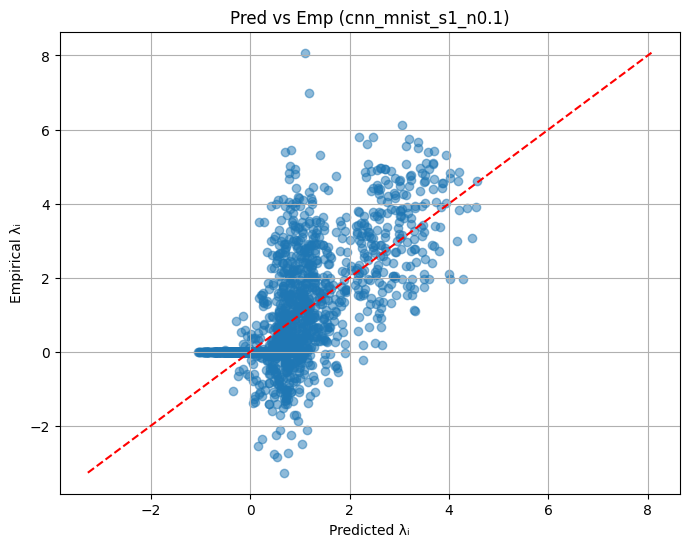

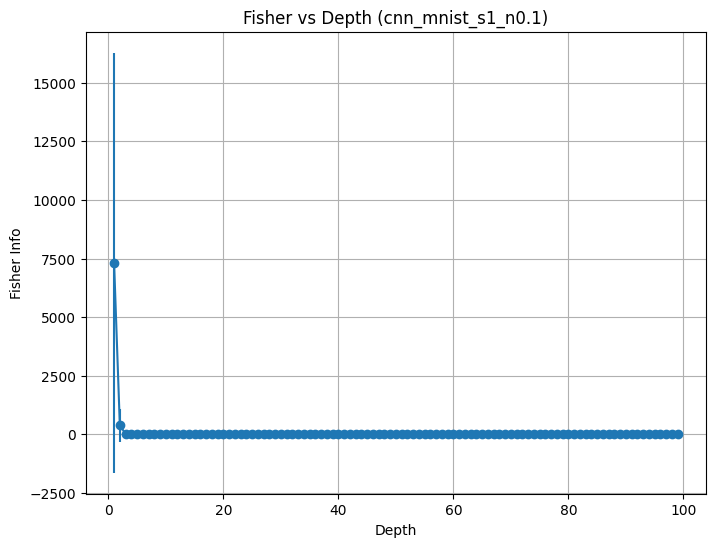

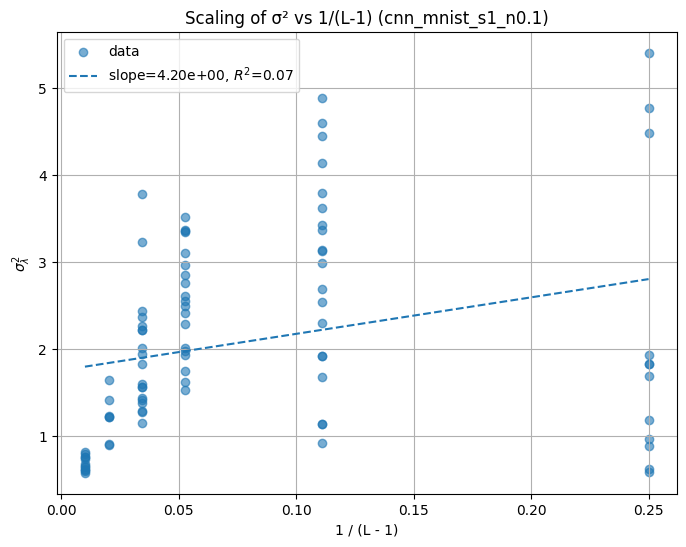


Experiment 5/60: arch=cnn, dataset=mnist, seed=1, noise=0.2
Running run_id       : cnn_mnist_s1_n0.2

Resize scale factor  : 1.40  →  target size 39
Input shape          : (36, 1, 39, 39)


Measuring models: 100%|██████████| 100/100 [03:43<00:00,  2.23s/it]


Generated models accepted       : 89
Unique datapoints               : 2455


>>> λᵢ Prediction
  R²    : 0.483
  RMSE  : 0.940
  Coefficients:
    s_r       : +2.625 × x^1.919
    inv_c     : -6.633
    d         : -0.503
    o         : -2.919
    bias       : +4.417


>>> Fisher Prediction
  R²    : 0.095
  RMSE  : 1992.491
  Coefficients:
    s_r       : +1084.137 × x^0.509
    inv_c     : -4510.738
    d         : -416.883
    o         : -2590.091
    bias       : +3355.264

>>> Scaling with Depth
  λᵢ  ~ depth^-0.485   (R² = 0.130)
  F   ~ depth^-4.383   (R² = 0.619)

>>> Per Fisher Bin Analysis
  Fisher range    : [4.05, 6749.14]
  Depth  range    : [5, 100]
  std(λ) range    : [0.77, 2.31]
  Valid FI bins   : 5 / 20
    FI ≈ 4.05 | Shallow: 20, Deep: 17, Ratio: 0.651
    FI ≈ 359.05 | Shallow: 6, Deep: 6, Ratio: 0.743
    FI ≈ 714.06 | Shallow: 4, Deep: 4, Ratio: 1.038
    FI ≈ 1069.06 | Shallow: 4, Deep: 4, Ratio: 1.000
    FI ≈ 1424.07 | Shallow: 3, Deep: 3, Ratio: 0.815
  λ variation ratio : 0.849 ± 0.166 (p = 0.0040)
  mean CV(bin)       : 0.218  ± 0.052
  max  CV(bin)       : 0.300
  Mutual information (std λ  vs. architecture features) per FI‐bin:
 fisher_level  mi_std_lambda  mi_pval
     4.049894   1.390859e-02 0.218905
   359.054524  

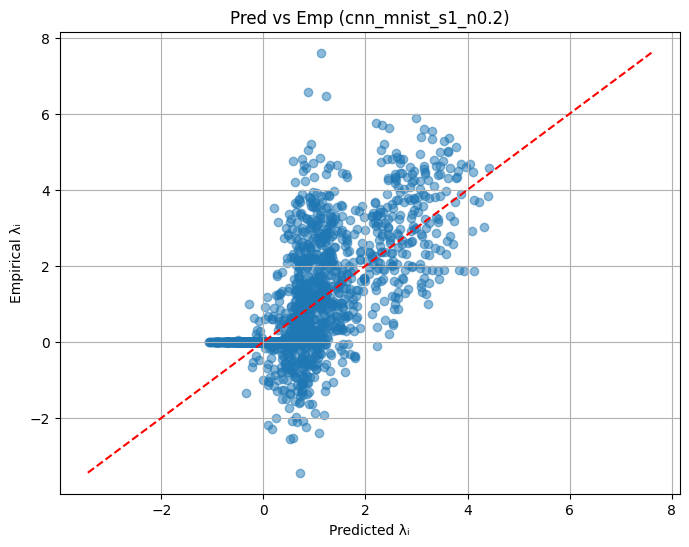

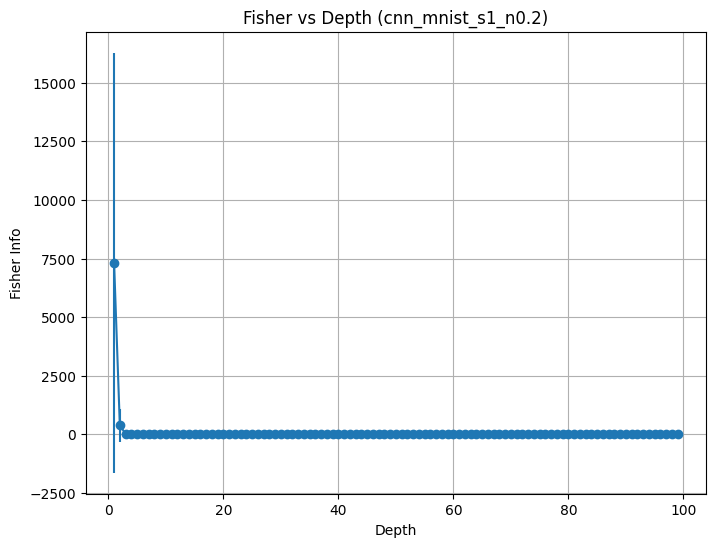

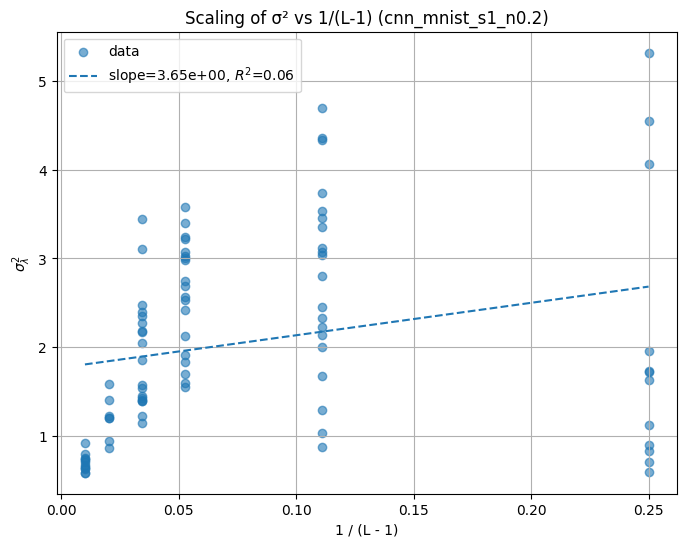


Experiment 6/60: arch=cnn, dataset=mnist, seed=1, noise=0.5
Running run_id       : cnn_mnist_s1_n0.5

Resize scale factor  : 1.40  →  target size 39
Input shape          : (36, 1, 39, 39)


Measuring models: 100%|██████████| 100/100 [03:43<00:00,  2.23s/it]


Generated models accepted       : 89
Unique datapoints               : 2455


>>> λᵢ Prediction
  R²    : 0.456
  RMSE  : 0.971
  Coefficients:
    s_r       : +2.333 × x^1.941
    inv_c     : -6.825
    d         : -0.532
    o         : -2.529
    bias       : +4.248


>>> Fisher Prediction
  R²    : 0.095
  RMSE  : 1992.491
  Coefficients:
    s_r       : +1084.137 × x^0.509
    inv_c     : -4510.738
    d         : -416.883
    o         : -2590.091
    bias       : +3355.264

>>> Scaling with Depth
  λᵢ  ~ depth^-0.431   (R² = 0.101)
  F   ~ depth^-4.383   (R² = 0.619)

>>> Per Fisher Bin Analysis
  Fisher range    : [4.05, 6749.14]
  Depth  range    : [5, 100]
  std(λ) range    : [0.76, 2.27]
  Valid FI bins   : 5 / 20
    FI ≈ 4.05 | Shallow: 20, Deep: 17, Ratio: 0.662
    FI ≈ 359.05 | Shallow: 6, Deep: 6, Ratio: 0.761
    FI ≈ 714.06 | Shallow: 4, Deep: 4, Ratio: 1.098
    FI ≈ 1069.06 | Shallow: 4, Deep: 4, Ratio: 1.000
    FI ≈ 1424.07 | Shallow: 3, Deep: 3, Ratio: 0.808
  λ variation ratio : 0.866 ± 0.179 (p = 0.0006)
  mean CV(bin)       : 0.212  ± 0.048
  max  CV(bin)       : 0.286
  Mutual information (std λ  vs. architecture features) per FI‐bin:
 fisher_level  mi_std_lambda  mi_pval
     4.049894   3.965408e-03 0.432836
   359.054524  

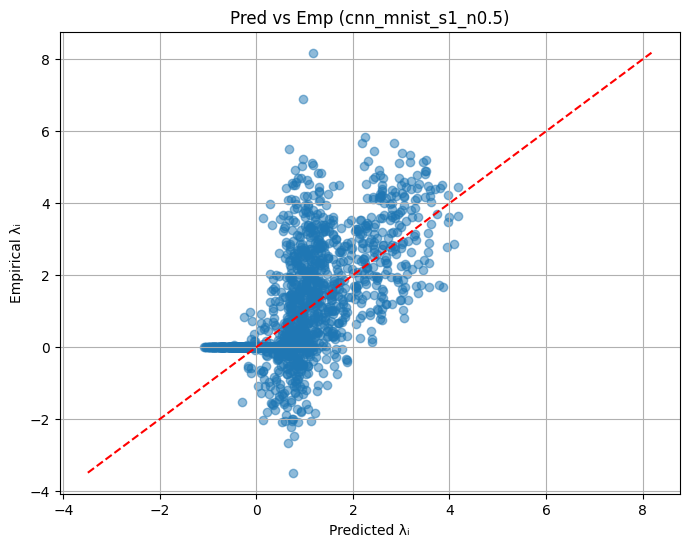

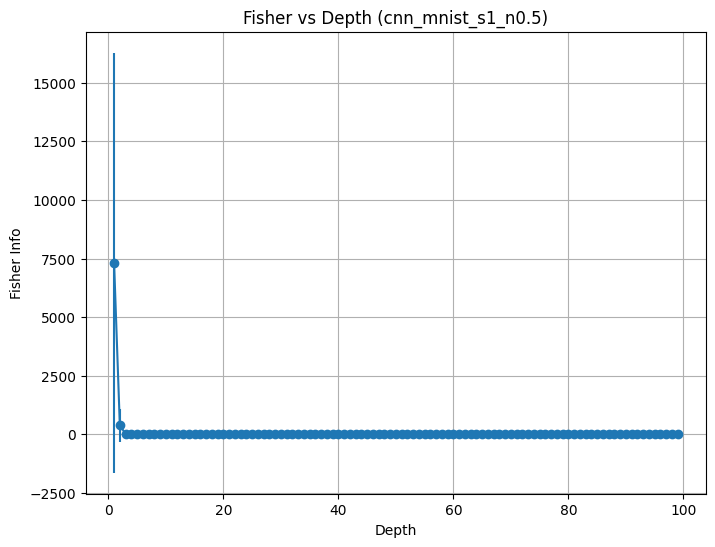

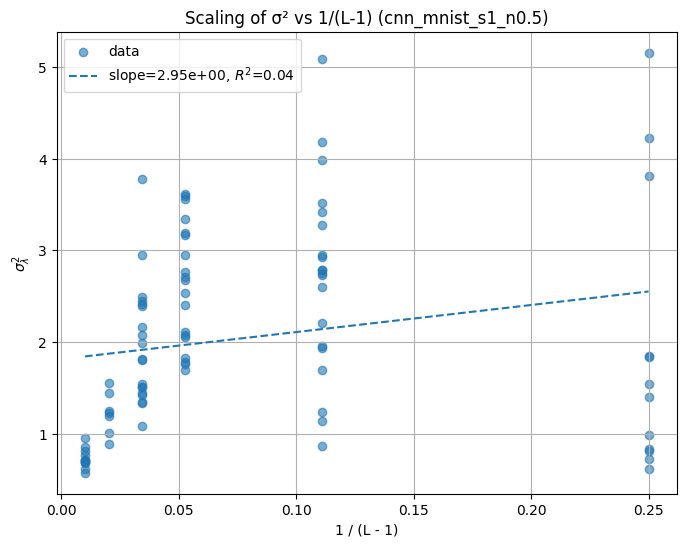


Experiment 7/60: arch=resnet, dataset=cifar, seed=1, noise=0.1
Running run_id       : resnet_cifar_s1_n0.1

Resize scale factor  : 1.40  →  target size 44
Input shape          : (36, 3, 44, 44)


Measuring models: 100%|██████████| 100/100 [09:22<00:00,  5.63s/it]


Generated models accepted       : 85
Unique datapoints               : 2648


>>> λᵢ Prediction
  R²    : 0.260
  RMSE  : 0.794
  Coefficients:
    skip_width: -0.000
    inv_c     : -1.312
    layer_index: -0.453
    block_depth: +0.113
    res_type  : +0.060
    kernel_size: -0.006
    stride    : +0.153
    bottleneck: +0.045
    projection: +0.058
    activation: +0.013
    bias       : +1.703


>>> Fisher Prediction
  R²    : 0.180
  RMSE  : 2277.479
  Coefficients:
    skip_width: -0.174
    inv_c     : -13687.944
    layer_index: -703.523
    block_depth: -2132.683
    res_type  : -1141.794
    kernel_size: -234.338
    stride    : -1733.626
    bottleneck: +996.702
    projection: -4.762
    activation: -331.026
    bias       : +5128.492

>>> Scaling with Depth
  λᵢ  ~ depth^-0.023   (R² = 0.000)
  F   ~ depth^-5.813   (R² = 0.741)

>>> Per Fisher Bin Analysis
  Fisher range    : [9.32, 6765.65]
  Depth  range    : [6, 101]
  std(λ) range    : [0.57, 1.52]
  Valid FI bins   : 3 / 20
    FI ≈ 9.32 | Shallow: 13, Deep: 22, Ratio: 0.689
    FI ≈ 364.92 | Shallow: 10, Deep: 7, Ratio: 0.994
    FI ≈ 720.51 | Shallow: 5, Deep: 4, Ratio: 0.935
  λ variation ratio : 0.873 ± 0.162 (p = 0.0002)
  mean CV(bin)       : 0.184  ± 0.061
  max  CV(bin)       : 0.240
  Mutual information (std λ  vs. architecture features) per FI‐bin:
 fisher_level  mi_std_lambda  mi_pval
     9.319345   5

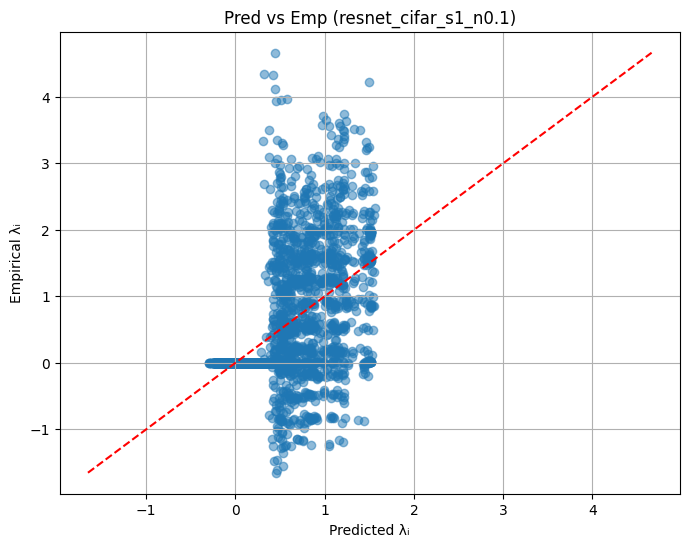

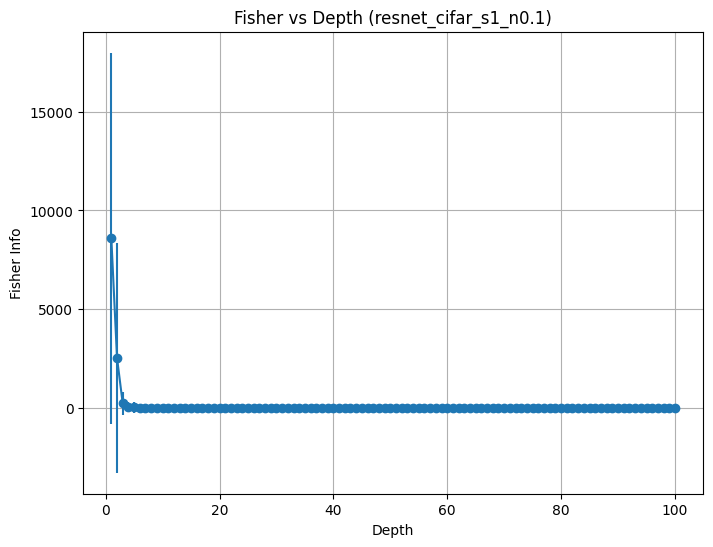

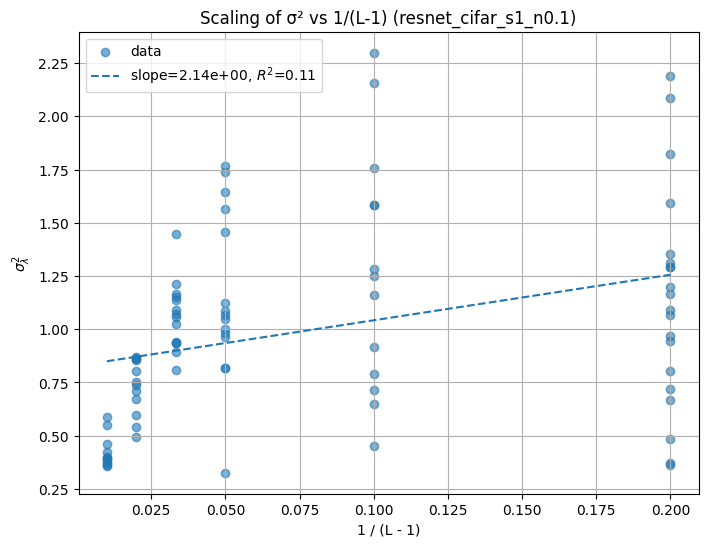


Experiment 8/60: arch=resnet, dataset=cifar, seed=1, noise=0.2
Running run_id       : resnet_cifar_s1_n0.2

Resize scale factor  : 1.40  →  target size 44
Input shape          : (36, 3, 44, 44)


Measuring models: 100%|██████████| 100/100 [09:44<00:00,  5.84s/it]


Generated models accepted       : 85
Unique datapoints               : 2648


>>> λᵢ Prediction
  R²    : 0.260
  RMSE  : 0.800
  Coefficients:
    skip_width: -0.000
    inv_c     : -1.203
    layer_index: -0.458
    block_depth: +0.114
    res_type  : +0.062
    kernel_size: -0.006
    stride    : +0.139
    bottleneck: +0.041
    projection: +0.059
    activation: +0.014
    bias       : +1.740


>>> Fisher Prediction
  R²    : 0.180
  RMSE  : 2277.479
  Coefficients:
    skip_width: -0.174
    inv_c     : -13687.944
    layer_index: -703.523
    block_depth: -2132.683
    res_type  : -1141.794
    kernel_size: -234.338
    stride    : -1733.626
    bottleneck: +996.702
    projection: -4.762
    activation: -331.026
    bias       : +5128.492

>>> Scaling with Depth
  λᵢ  ~ depth^0.009   (R² = 0.000)
  F   ~ depth^-5.813   (R² = 0.741)

>>> Per Fisher Bin Analysis
  Fisher range    : [9.32, 6765.65]
  Depth  range    : [6, 101]
  std(λ) range    : [0.56, 1.51]
  Valid FI bins   : 3 / 20
    FI ≈ 9.32 | Shallow: 13, Deep: 22, Ratio: 0.695
    FI ≈ 364.92 | Shallow: 10, Deep: 7, Ratio: 0.994
    FI ≈ 720.51 | Shallow: 5, Deep: 4, Ratio: 0.940
  λ variation ratio : 0.876 ± 0.159 (p = 0.0002)
  mean CV(bin)       : 0.183  ± 0.059
  max  CV(bin)       : 0.236
  Mutual information (std λ  vs. architecture features) per FI‐bin:
 fisher_level  mi_std_lambda  mi_pval
     9.319345   0.

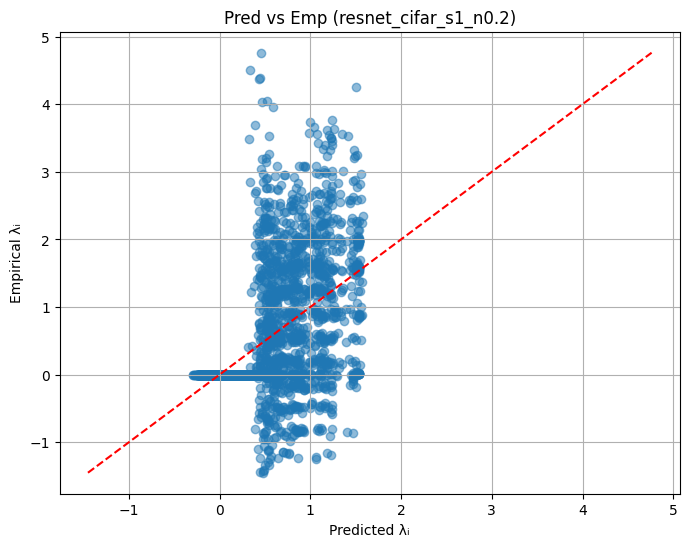

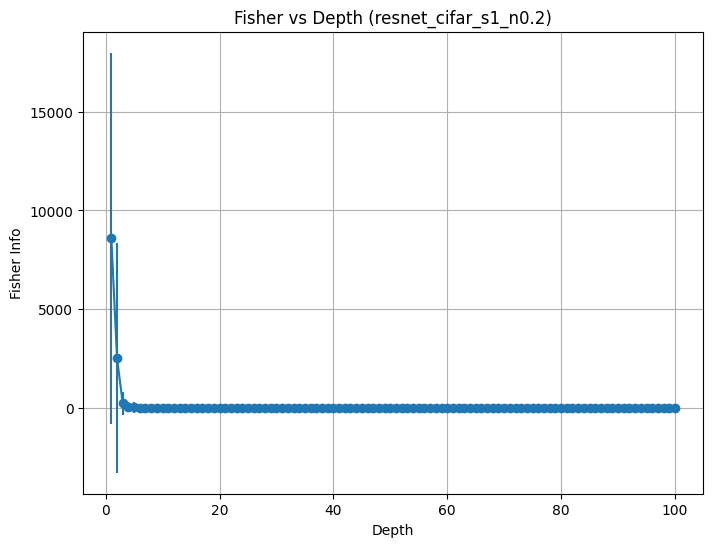

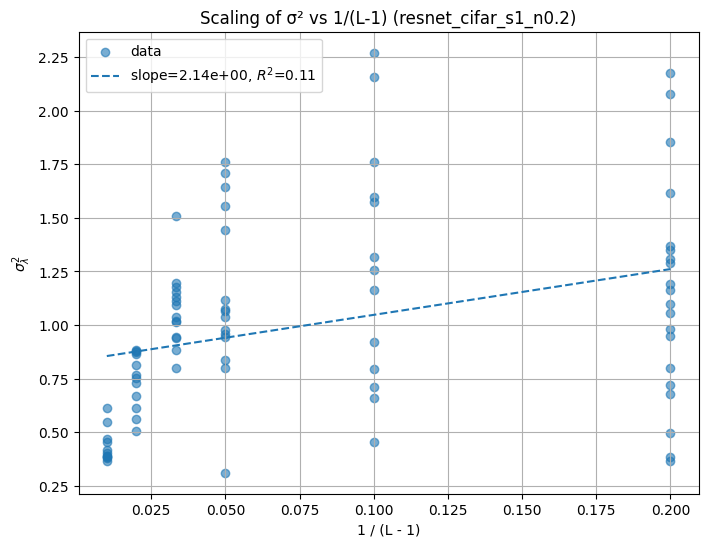


Experiment 9/60: arch=resnet, dataset=cifar, seed=1, noise=0.5
Running run_id       : resnet_cifar_s1_n0.5

Resize scale factor  : 1.40  →  target size 44
Input shape          : (36, 3, 44, 44)


Measuring models: 100%|██████████| 100/100 [09:44<00:00,  5.85s/it]


Generated models accepted       : 85
Unique datapoints               : 2648


>>> λᵢ Prediction
  R²    : 0.255
  RMSE  : 0.812
  Coefficients:
    skip_width: -0.000
    inv_c     : -1.041
    layer_index: -0.460
    block_depth: +0.126
    res_type  : +0.064
    kernel_size: -0.010
    stride    : +0.121
    bottleneck: +0.036
    projection: +0.069
    activation: +0.016
    bias       : +1.774


>>> Fisher Prediction
  R²    : 0.180
  RMSE  : 2277.479
  Coefficients:
    skip_width: -0.174
    inv_c     : -13687.944
    layer_index: -703.523
    block_depth: -2132.683
    res_type  : -1141.794
    kernel_size: -234.338
    stride    : -1733.626
    bottleneck: +996.702
    projection: -4.762
    activation: -331.026
    bias       : +5128.492

>>> Scaling with Depth
  λᵢ  ~ depth^-0.010   (R² = 0.000)
  F   ~ depth^-5.813   (R² = 0.741)

>>> Per Fisher Bin Analysis
  Fisher range    : [9.32, 6765.65]
  Depth  range    : [6, 101]
  std(λ) range    : [0.57, 1.49]
  Valid FI bins   : 3 / 20
    FI ≈ 9.32 | Shallow: 13, Deep: 22, Ratio: 0.709
    FI ≈ 364.92 | Shallow: 10, Deep: 7, Ratio: 0.997
    FI ≈ 720.51 | Shallow: 5, Deep: 4, Ratio: 0.934
  λ variation ratio : 0.880 ± 0.152 (p = 0.0005)
  mean CV(bin)       : 0.180  ± 0.055
  max  CV(bin)       : 0.230
  Mutual information (std λ  vs. architecture features) per FI‐bin:
 fisher_level  mi_std_lambda  mi_pval
     9.319345   9

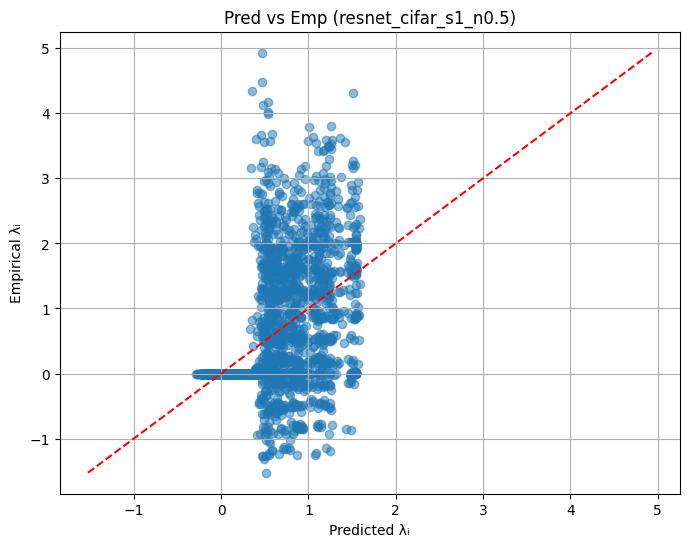

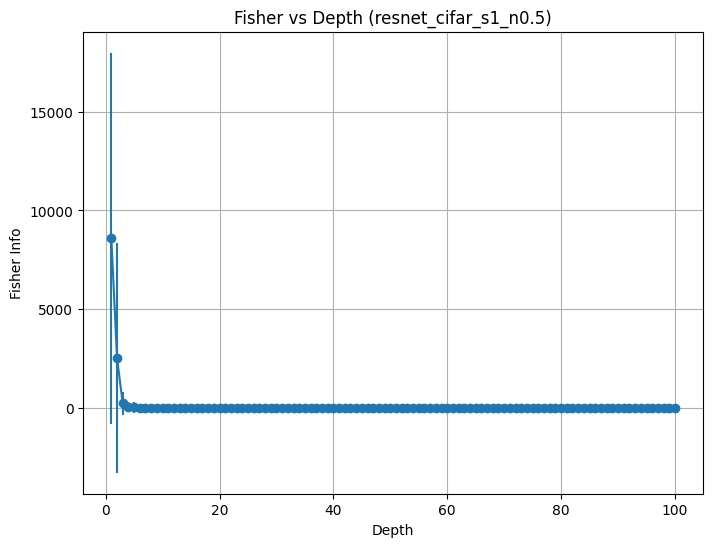

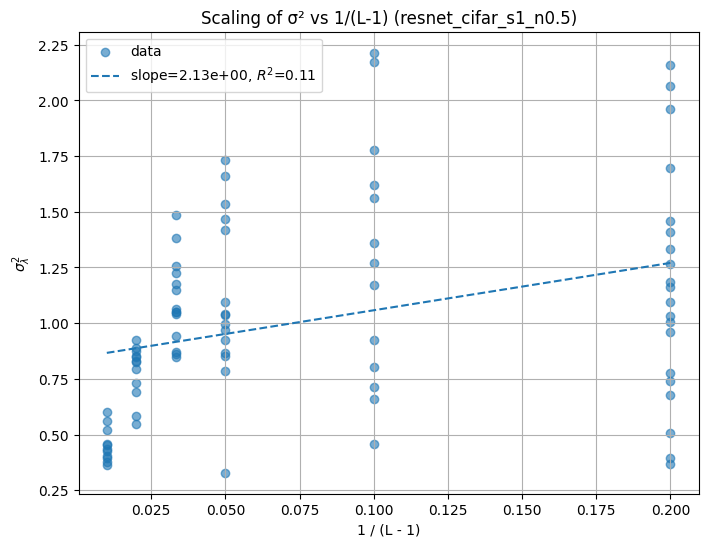


Experiment 10/60: arch=resnet, dataset=mnist, seed=1, noise=0.1
Running run_id       : resnet_mnist_s1_n0.1

Resize scale factor  : 1.40  →  target size 39
Input shape          : (36, 1, 39, 39)


Measuring models: 100%|██████████| 100/100 [09:59<00:00,  5.99s/it]


Generated models accepted       : 85
Unique datapoints               : 2648


>>> λᵢ Prediction
  R²    : 0.275
  RMSE  : 0.772
  Coefficients:
    skip_width: -0.000
    inv_c     : -1.129
    layer_index: -0.457
    block_depth: +0.118
    res_type  : +0.052
    kernel_size: -0.014
    stride    : +0.162
    bottleneck: +0.051
    projection: +0.061
    activation: +0.007
    bias       : +1.718


>>> Fisher Prediction
  R²    : 0.177
  RMSE  : 2089.503
  Coefficients:
    skip_width: -0.156
    inv_c     : -12303.354
    layer_index: -635.868
    block_depth: -1942.760
    res_type  : -1042.631
    kernel_size: -205.920
    stride    : -1563.715
    bottleneck: +922.788
    projection: -7.411
    activation: -298.380
    bias       : +4621.056

>>> Scaling with Depth
  λᵢ  ~ depth^-0.123   (R² = 0.007)
  F   ~ depth^-5.677   (R² = 0.728)

>>> Per Fisher Bin Analysis
  Fisher range    : [3.01, 5995.94]
  Depth  range    : [6, 101]
  std(λ) range    : [0.57, 1.50]
  Valid FI bins   : 3 / 20
    FI ≈ 3.01 | Shallow: 21, Deep: 10, Ratio: 0.703
    FI ≈ 318.43 | Shallow: 12, Deep: 7, Ratio: 0.937
    FI ≈ 633.85 | Shallow: 3, Deep: 4, Ratio: 0.882
  λ variation ratio : 0.841 ± 0.122 (p = 0.0045)
  mean CV(bin)       : 0.190  ± 0.055
  max  CV(bin)       : 0.246
  Mutual information (std λ  vs. architecture features) per FI‐bin:
 fisher_level  mi_std_lambda  mi_pval
     3.011785   0

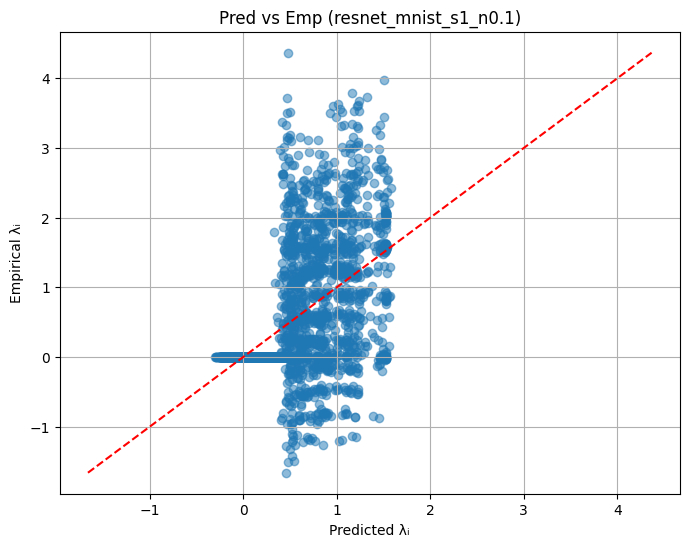

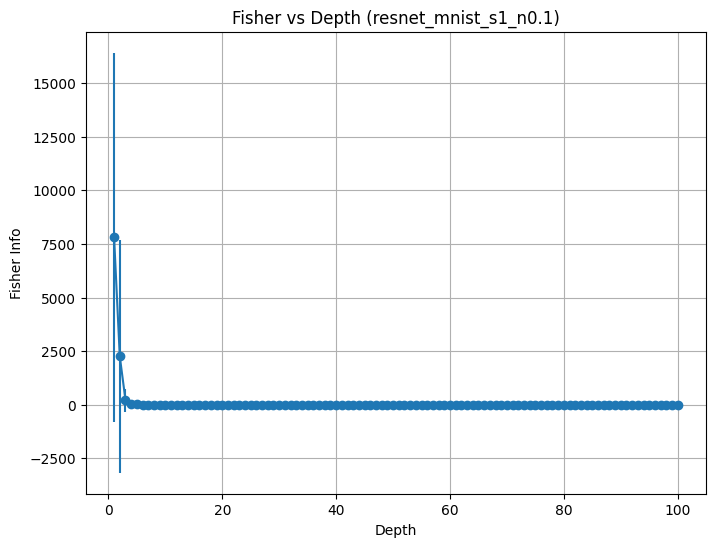

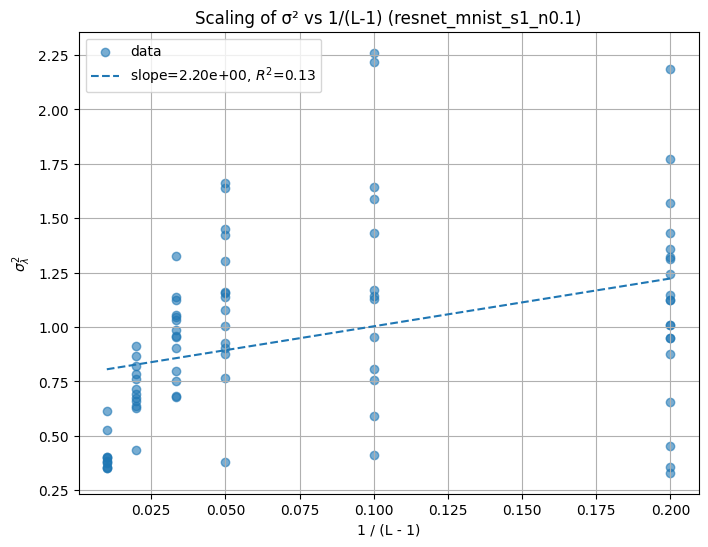


Experiment 11/60: arch=resnet, dataset=mnist, seed=1, noise=0.2
Running run_id       : resnet_mnist_s1_n0.2

Resize scale factor  : 1.40  →  target size 39
Input shape          : (36, 1, 39, 39)


Measuring models: 100%|██████████| 100/100 [10:37<00:00,  6.37s/it]


Generated models accepted       : 85
Unique datapoints               : 2648


>>> λᵢ Prediction
  R²    : 0.268
  RMSE  : 0.783
  Coefficients:
    skip_width: -0.000
    inv_c     : -0.952
    layer_index: -0.457
    block_depth: +0.132
    res_type  : +0.061
    kernel_size: -0.016
    stride    : +0.133
    bottleneck: +0.054
    projection: +0.068
    activation: +0.009
    bias       : +1.743


>>> Fisher Prediction
  R²    : 0.177
  RMSE  : 2089.503
  Coefficients:
    skip_width: -0.156
    inv_c     : -12303.354
    layer_index: -635.868
    block_depth: -1942.760
    res_type  : -1042.631
    kernel_size: -205.920
    stride    : -1563.715
    bottleneck: +922.788
    projection: -7.411
    activation: -298.380
    bias       : +4621.056

>>> Scaling with Depth
  λᵢ  ~ depth^-0.117   (R² = 0.006)
  F   ~ depth^-5.677   (R² = 0.728)

>>> Per Fisher Bin Analysis
  Fisher range    : [3.01, 5995.94]
  Depth  range    : [6, 101]
  std(λ) range    : [0.59, 1.51]
  Valid FI bins   : 3 / 20
    FI ≈ 3.01 | Shallow: 21, Deep: 10, Ratio: 0.701
    FI ≈ 318.43 | Shallow: 12, Deep: 7, Ratio: 0.940
    FI ≈ 633.85 | Shallow: 3, Deep: 4, Ratio: 0.890
  λ variation ratio : 0.844 ± 0.126 (p = 0.0045)
  mean CV(bin)       : 0.191  ± 0.054
  max  CV(bin)       : 0.247
  Mutual information (std λ  vs. architecture features) per FI‐bin:
 fisher_level  mi_std_lambda  mi_pval
     3.011785   0

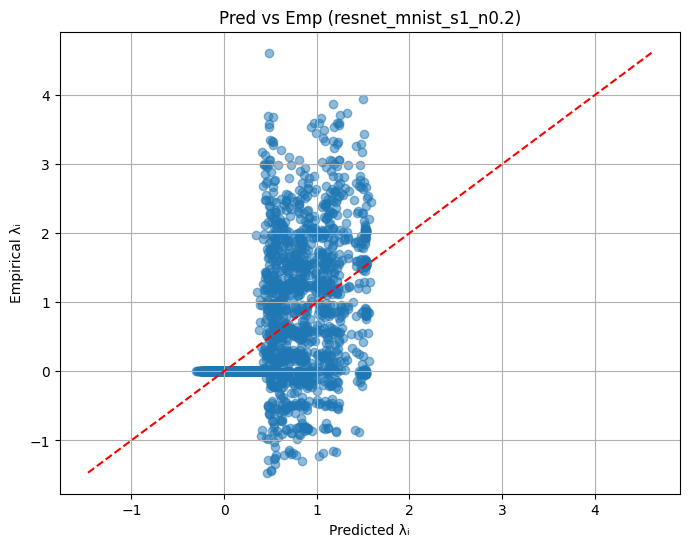

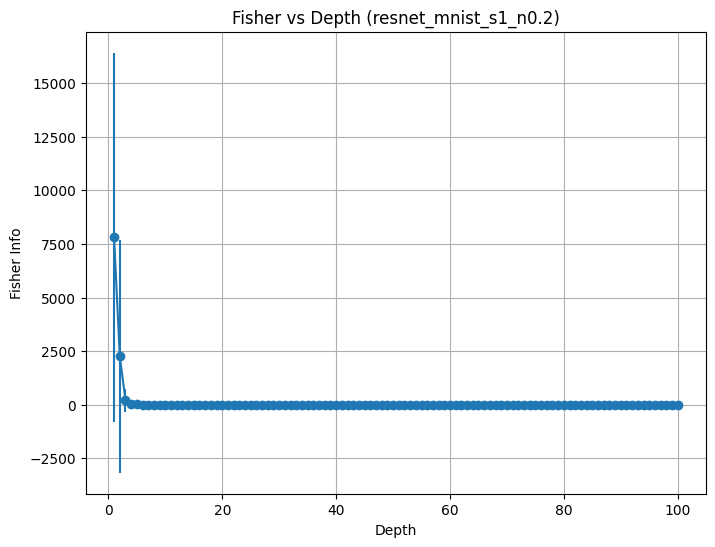

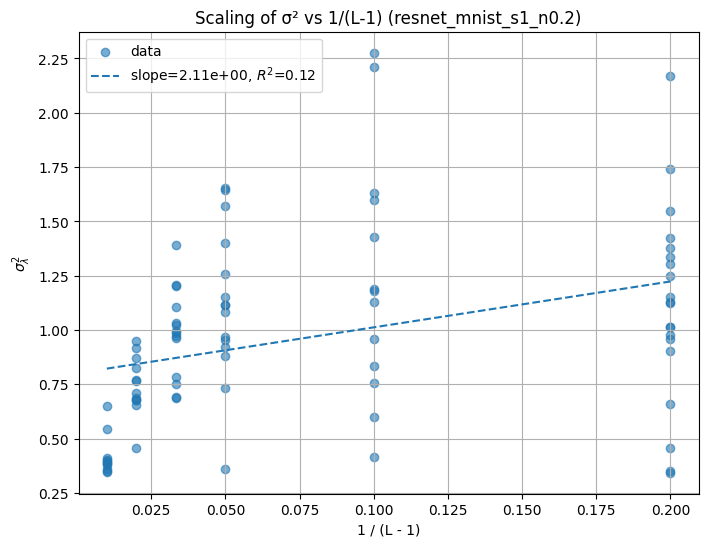


Experiment 12/60: arch=resnet, dataset=mnist, seed=1, noise=0.5
Running run_id       : resnet_mnist_s1_n0.5

Resize scale factor  : 1.40  →  target size 39
Input shape          : (36, 1, 39, 39)


Measuring models: 100%|██████████| 100/100 [10:39<00:00,  6.39s/it]


Generated models accepted       : 85
Unique datapoints               : 2648


>>> λᵢ Prediction
  R²    : 0.252
  RMSE  : 0.801
  Coefficients:
    skip_width: -0.000
    inv_c     : -0.855
    layer_index: -0.453
    block_depth: +0.149
    res_type  : +0.083
    kernel_size: -0.016
    stride    : +0.086
    bottleneck: +0.050
    projection: +0.059
    activation: +0.013
    bias       : +1.765


>>> Fisher Prediction
  R²    : 0.177
  RMSE  : 2089.503
  Coefficients:
    skip_width: -0.156
    inv_c     : -12303.354
    layer_index: -635.868
    block_depth: -1942.760
    res_type  : -1042.631
    kernel_size: -205.920
    stride    : -1563.715
    bottleneck: +922.788
    projection: -7.411
    activation: -298.380
    bias       : +4621.056

>>> Scaling with Depth
  λᵢ  ~ depth^-0.134   (R² = 0.010)
  F   ~ depth^-5.677   (R² = 0.728)

>>> Per Fisher Bin Analysis
  Fisher range    : [3.01, 5995.94]
  Depth  range    : [6, 101]
  std(λ) range    : [0.59, 1.51]
  Valid FI bins   : 3 / 20
    FI ≈ 3.01 | Shallow: 21, Deep: 10, Ratio: 0.701
    FI ≈ 318.43 | Shallow: 12, Deep: 7, Ratio: 0.924
    FI ≈ 633.85 | Shallow: 3, Deep: 4, Ratio: 0.918
  λ variation ratio : 0.848 ± 0.127 (p = 0.0045)
  mean CV(bin)       : 0.191  ± 0.047
  max  CV(bin)       : 0.245
  Mutual information (std λ  vs. architecture features) per FI‐bin:
 fisher_level  mi_std_lambda  mi_pval
     3.011785   0

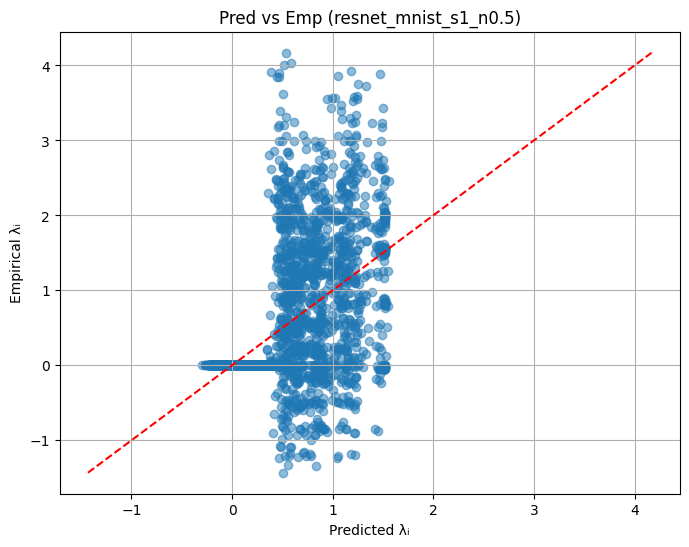

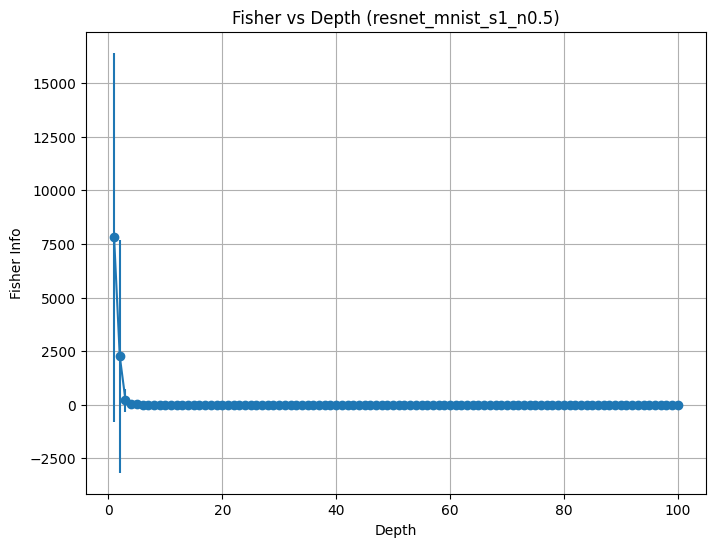

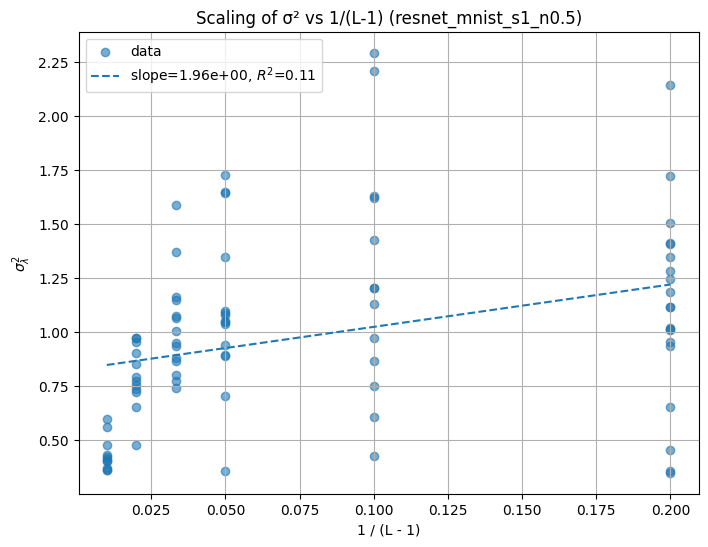


Experiment 13/60: arch=cnn, dataset=cifar, seed=12, noise=0.1
Running run_id       : cnn_cifar_s12_n0.1

Resize scale factor  : 2.42  →  target size 77
Files already downloaded and verified
Input shape          : (36, 3, 77, 77)


Measuring models: 100%|██████████| 100/100 [06:42<00:00,  4.03s/it]


Generated models accepted       : 86
Unique datapoints               : 3128


>>> λᵢ Prediction
  R²    : 0.490
  RMSE  : 0.819
  Coefficients:
    s_r       : +2.499 × x^1.928
    inv_c     : -4.284
    d         : -0.444
    o         : -3.115
    bias       : +4.340


>>> Fisher Prediction
  R²    : 0.069
  RMSE  : 2453.925
  Coefficients:
    s_r       : +0.032 × x^-0.313
    inv_c     : -4092.743
    d         : -674.339
    o         : +815.298
    bias       : +1819.702

>>> Scaling with Depth
  λᵢ  ~ depth^-0.634   (R² = 0.168)
  F   ~ depth^-4.578   (R² = 0.627)

>>> Per Fisher Bin Analysis
  Fisher range    : [6.92, 12756.00]
  Depth  range    : [5, 100]
  std(λ) range    : [0.73, 2.48]
  Valid FI bins   : 3 / 20
    FI ≈ 6.92 | Shallow: 23, Deep: 20, Ratio: 0.577
    FI ≈ 677.92 | Shallow: 4, Deep: 5, Ratio: 0.849
    FI ≈ 1348.92 | Shallow: 4, Deep: 5, Ratio: 0.886
  λ variation ratio : 0.771 ± 0.169 (p = 0.0000)
  mean CV(bin)       : 0.249  ± 0.027
  max  CV(bin)       : 0.281
  Mutual information (std λ  vs. architecture features) per FI‐bin:
 fisher_level  mi_std_lambda  mi_pval
     6.916110   0.000000e+00 1.000000
   677.920533   4.440892e-16 0.850746
  1348.924956   0.000000e+00 1.000000
  2019.929379   5.551115e-17 1.000000
  2690.9

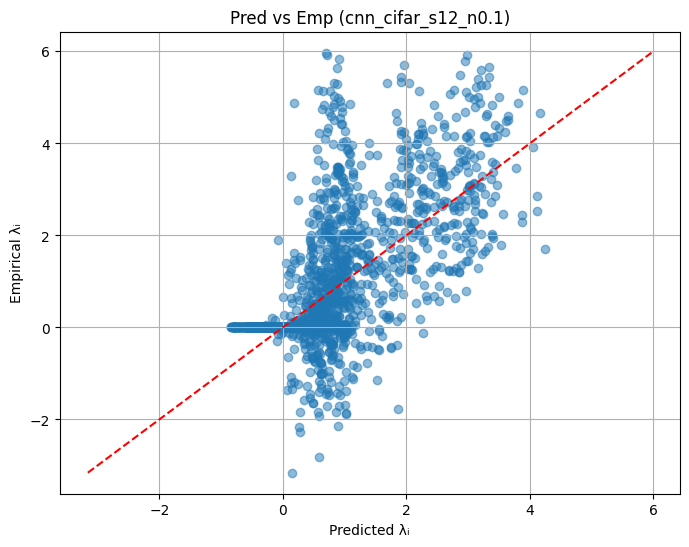

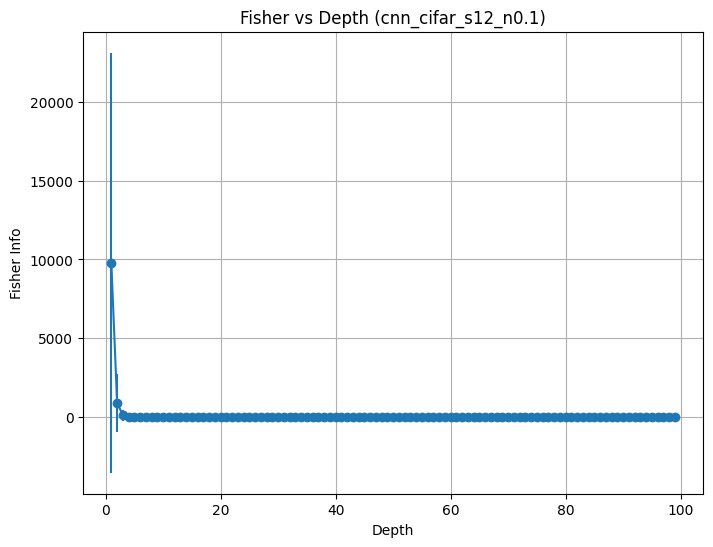

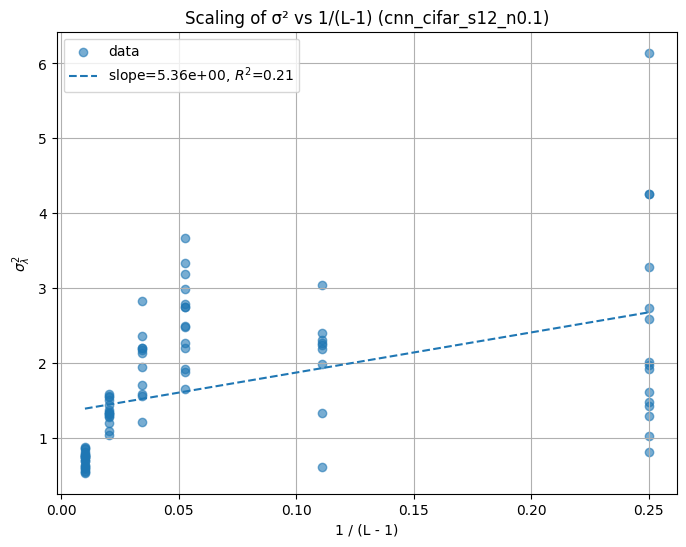


Experiment 14/60: arch=cnn, dataset=cifar, seed=12, noise=0.2
Running run_id       : cnn_cifar_s12_n0.2

Resize scale factor  : 2.42  →  target size 77
Input shape          : (36, 3, 77, 77)


Measuring models: 100%|██████████| 100/100 [06:44<00:00,  4.05s/it]


Generated models accepted       : 86
Unique datapoints               : 3131


>>> λᵢ Prediction
  R²    : 0.476
  RMSE  : 0.833
  Coefficients:
    s_r       : +2.351 × x^1.986
    inv_c     : -4.380
    d         : -0.464
    o         : -2.879
    bias       : +4.251


>>> Fisher Prediction
  R²    : 0.069
  RMSE  : 2453.925
  Coefficients:
    s_r       : +0.032 × x^-0.313
    inv_c     : -4092.743
    d         : -674.339
    o         : +815.298
    bias       : +1819.702

>>> Scaling with Depth
  λᵢ  ~ depth^-0.530   (R² = 0.130)
  F   ~ depth^-4.578   (R² = 0.627)

>>> Per Fisher Bin Analysis
  Fisher range    : [6.92, 12756.00]
  Depth  range    : [5, 100]
  std(λ) range    : [0.66, 2.47]
  Valid FI bins   : 3 / 20
    FI ≈ 6.92 | Shallow: 23, Deep: 20, Ratio: 0.596
    FI ≈ 677.92 | Shallow: 4, Deep: 5, Ratio: 0.838
    FI ≈ 1348.92 | Shallow: 4, Deep: 5, Ratio: 0.931
  λ variation ratio : 0.788 ± 0.173 (p = 0.0000)
  mean CV(bin)       : 0.247  ± 0.022
  max  CV(bin)       : 0.277
  Mutual information (std λ  vs. architecture features) per FI‐bin:
 fisher_level  mi_std_lambda  mi_pval
     6.916110   0.000000e+00 1.000000
   677.920533   4.440892e-16 0.746269
  1348.924956   0.000000e+00 1.000000
  2019.929379   5.551115e-17 1.000000
  2690.9

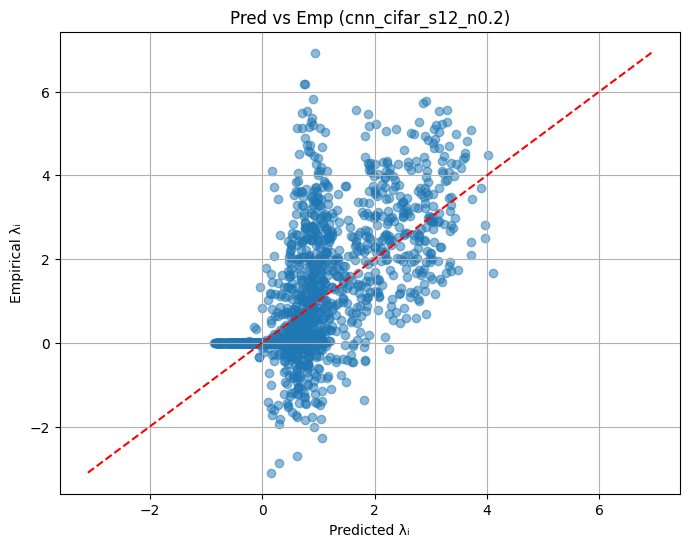

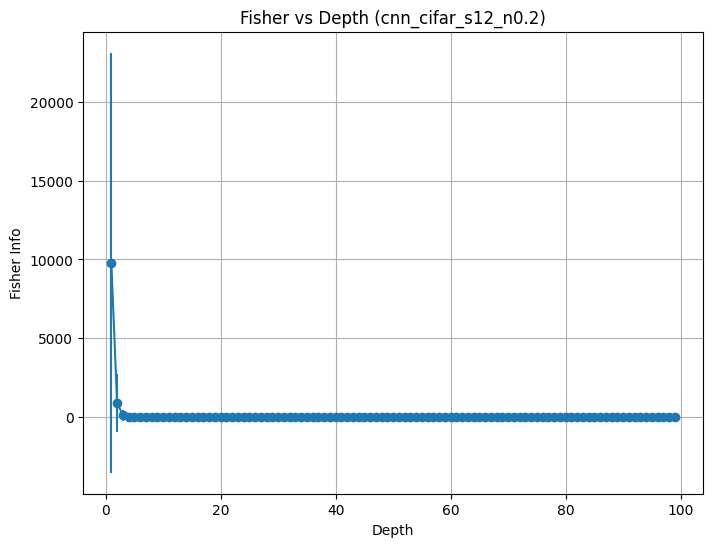

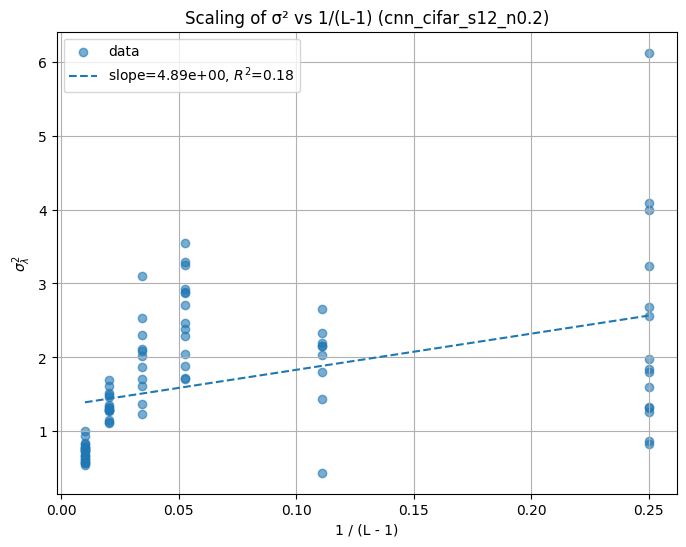


Experiment 15/60: arch=cnn, dataset=cifar, seed=12, noise=0.5
Running run_id       : cnn_cifar_s12_n0.5

Resize scale factor  : 2.42  →  target size 77
Input shape          : (36, 3, 77, 77)


Measuring models: 100%|██████████| 100/100 [06:47<00:00,  4.08s/it]


Generated models accepted       : 86
Unique datapoints               : 3131


>>> λᵢ Prediction
  R²    : 0.453
  RMSE  : 0.856
  Coefficients:
    s_r       : +2.124 × x^2.074
    inv_c     : -4.360
    d         : -0.493
    o         : -2.516
    bias       : +4.100


>>> Fisher Prediction
  R²    : 0.069
  RMSE  : 2453.925
  Coefficients:
    s_r       : +0.032 × x^-0.313
    inv_c     : -4092.743
    d         : -674.339
    o         : +815.298
    bias       : +1819.702

>>> Scaling with Depth
  λᵢ  ~ depth^-0.467   (R² = 0.115)
  F   ~ depth^-4.578   (R² = 0.627)

>>> Per Fisher Bin Analysis
  Fisher range    : [6.92, 12756.00]
  Depth  range    : [5, 100]
  std(λ) range    : [0.65, 2.48]
  Valid FI bins   : 3 / 20
    FI ≈ 6.92 | Shallow: 23, Deep: 20, Ratio: 0.616
    FI ≈ 677.92 | Shallow: 4, Deep: 5, Ratio: 0.873
    FI ≈ 1348.92 | Shallow: 4, Deep: 5, Ratio: 0.968
  λ variation ratio : 0.819 ± 0.182 (p = 0.0000)
  mean CV(bin)       : 0.246  ± 0.014
  max  CV(bin)       : 0.267
  Mutual information (std λ  vs. architecture features) per FI‐bin:
 fisher_level  mi_std_lambda  mi_pval
     6.916110   4.313545e-03 0.343284
   677.920533   4.440892e-16 0.696517
  1348.924956   0.000000e+00 1.000000
  2019.929379   5.551115e-17 1.000000
  2690.9

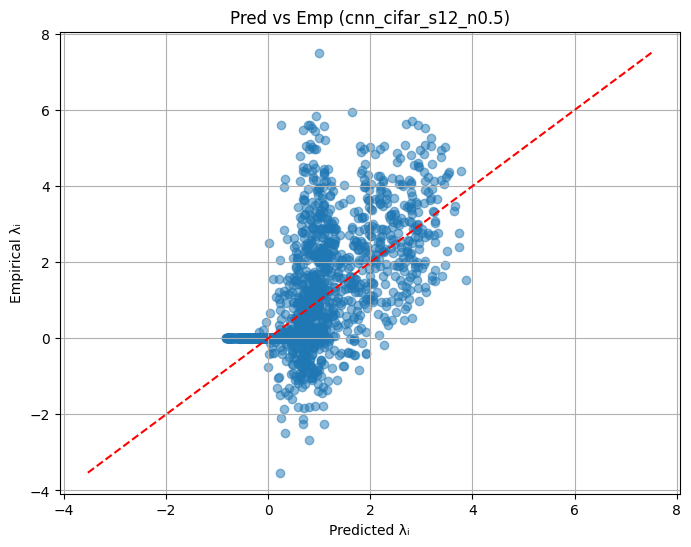

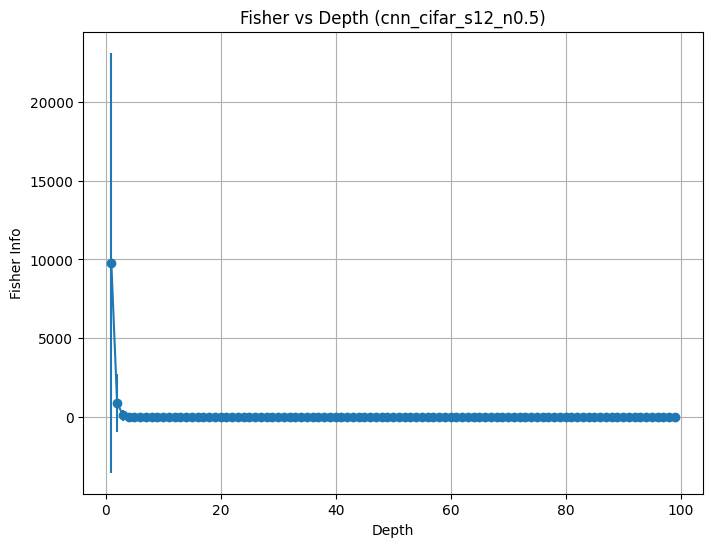

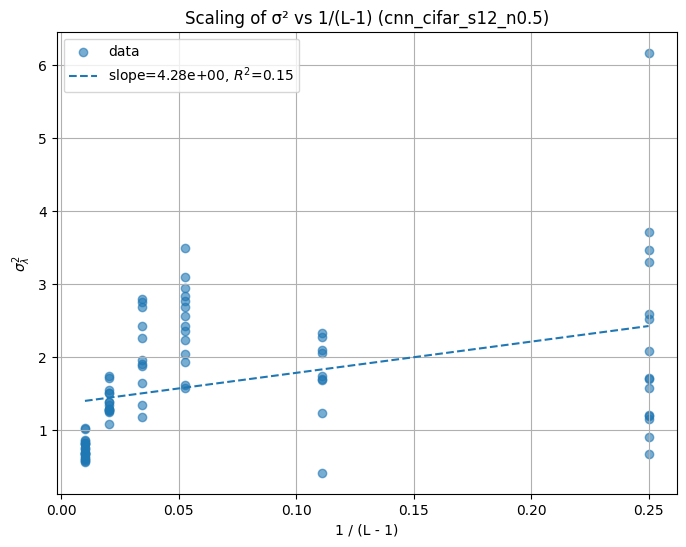


Experiment 16/60: arch=cnn, dataset=mnist, seed=12, noise=0.1
Running run_id       : cnn_mnist_s12_n0.1

Resize scale factor  : 2.42  →  target size 67
Input shape          : (36, 1, 67, 67)


Measuring models: 100%|██████████| 100/100 [05:27<00:00,  3.27s/it]


Generated models accepted       : 86
Unique datapoints               : 2798


>>> λᵢ Prediction
  R²    : 0.477
  RMSE  : 0.870
  Coefficients:
    s_r       : +2.516 × x^1.701
    inv_c     : -4.796
    d         : -0.460
    o         : -3.182
    bias       : +4.376


>>> Fisher Prediction
  R²    : 0.085
  RMSE  : 2947.477
  Coefficients:
    s_r       : +2604.136 × x^3.148
    inv_c     : -6083.056
    d         : -611.131
    o         : -1797.666
    bias       : +3825.336

>>> Scaling with Depth
  λᵢ  ~ depth^-0.680   (R² = 0.201)
  F   ~ depth^-4.740   (R² = 0.654)

>>> Per Fisher Bin Analysis
  Fisher range    : [4.61, 11352.13]
  Depth  range    : [5, 100]
  std(λ) range    : [0.50, 2.47]
  Valid FI bins   : 3 / 20
    FI ≈ 4.61 | Shallow: 18, Deep: 26, Ratio: 0.628
    FI ≈ 601.85 | Shallow: 8, Deep: 11, Ratio: 0.865
    FI ≈ 4782.51 | Shallow: 3, Deep: 3, Ratio: 1.000
  λ variation ratio : 0.831 ± 0.188 (p = 0.0000)
  mean CV(bin)       : 0.276  ± 0.018
  max  CV(bin)       : 0.294
  Mutual information (std λ  vs. architecture features) per FI‐bin:
 fisher_level  mi_std_lambda  mi_pval
     4.611511   7.707881e-03 0.313433
   601.849159   1.110223e-16 0.731343
  1199.086806   0.000000e+00 1.000000
  1796.324454   0.000000e+00 1.000000
  23

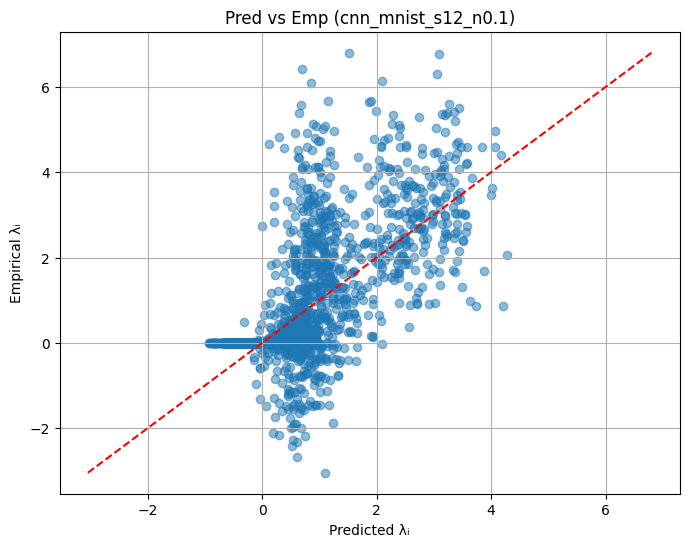

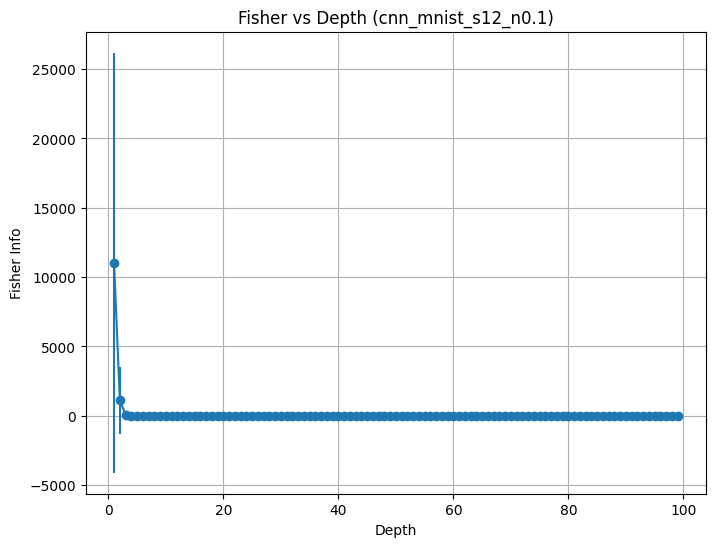

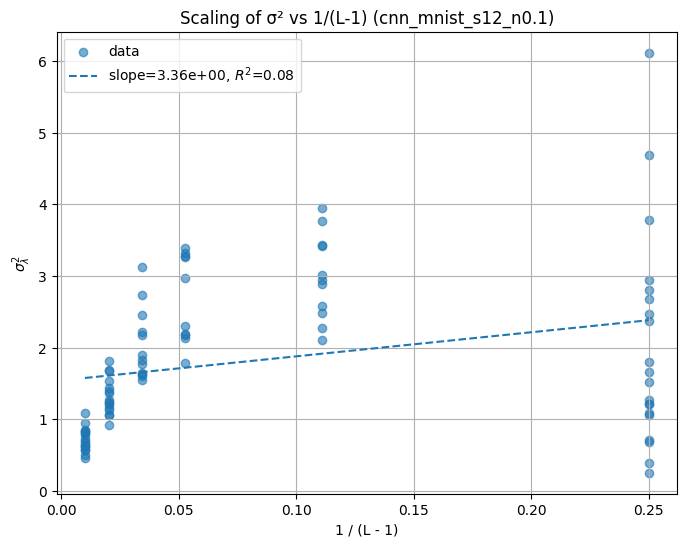


Experiment 17/60: arch=cnn, dataset=mnist, seed=12, noise=0.2
Running run_id       : cnn_mnist_s12_n0.2

Resize scale factor  : 2.42  →  target size 67
Input shape          : (36, 1, 67, 67)


Measuring models: 100%|██████████| 100/100 [05:24<00:00,  3.25s/it]


Generated models accepted       : 86
Unique datapoints               : 2803


>>> λᵢ Prediction
  R²    : 0.464
  RMSE  : 0.881
  Coefficients:
    s_r       : +2.343 × x^1.744
    inv_c     : -4.909
    d         : -0.483
    o         : -2.859
    bias       : +4.231


>>> Fisher Prediction
  R²    : 0.085
  RMSE  : 2947.477
  Coefficients:
    s_r       : +2604.136 × x^3.148
    inv_c     : -6083.056
    d         : -611.131
    o         : -1797.666
    bias       : +3825.336

>>> Scaling with Depth
  λᵢ  ~ depth^-0.635   (R² = 0.175)
  F   ~ depth^-4.740   (R² = 0.654)

>>> Per Fisher Bin Analysis
  Fisher range    : [4.61, 11352.13]
  Depth  range    : [5, 100]
  std(λ) range    : [0.49, 2.47]
  Valid FI bins   : 3 / 20
    FI ≈ 4.61 | Shallow: 18, Deep: 26, Ratio: 0.637
    FI ≈ 601.85 | Shallow: 8, Deep: 11, Ratio: 0.899
    FI ≈ 4782.51 | Shallow: 3, Deep: 3, Ratio: 1.000
  λ variation ratio : 0.845 ± 0.187 (p = 0.0000)
  mean CV(bin)       : 0.267  ± 0.018
  max  CV(bin)       : 0.285
  Mutual information (std λ  vs. architecture features) per FI‐bin:
 fisher_level  mi_std_lambda  mi_pval
     4.611511   2.617570e-02 0.124378
   601.849159   1.110223e-16 0.681592
  1199.086806   0.000000e+00 1.000000
  1796.324454   0.000000e+00 1.000000
  23

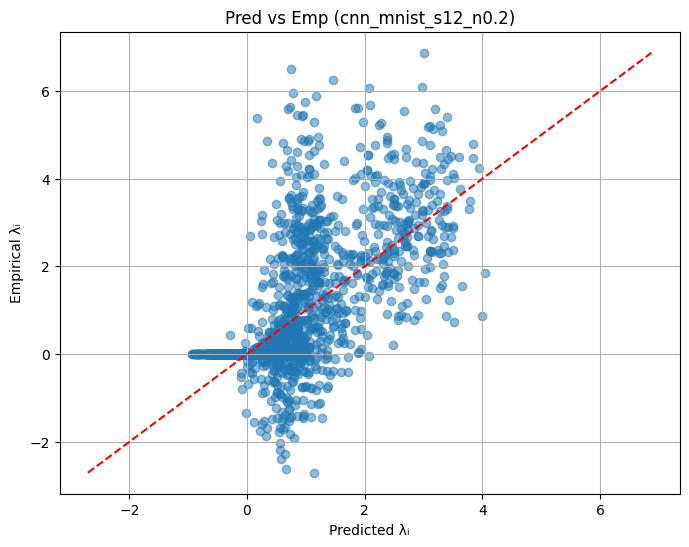

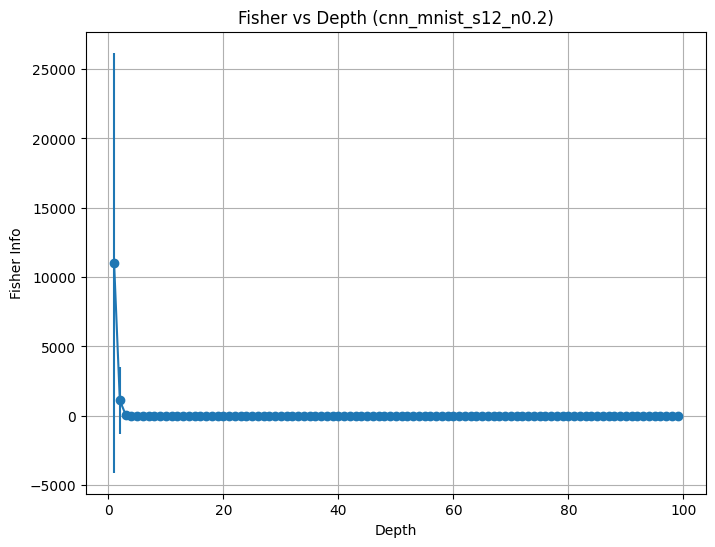

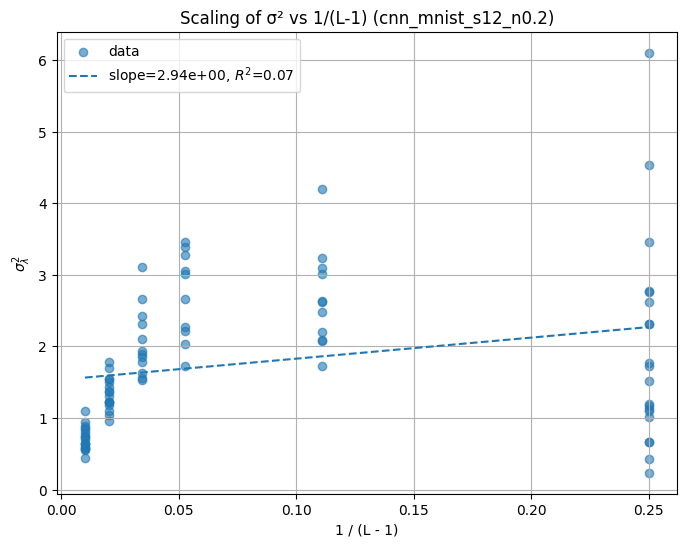


Experiment 18/60: arch=cnn, dataset=mnist, seed=12, noise=0.5
Running run_id       : cnn_mnist_s12_n0.5

Resize scale factor  : 2.42  →  target size 67
Input shape          : (36, 1, 67, 67)


Measuring models: 100%|██████████| 100/100 [05:25<00:00,  3.26s/it]


Generated models accepted       : 86
Unique datapoints               : 2808


>>> λᵢ Prediction
  R²    : 0.442
  RMSE  : 0.900
  Coefficients:
    s_r       : +2.053 × x^1.751
    inv_c     : -5.120
    d         : -0.511
    o         : -2.476
    bias       : +4.064


>>> Fisher Prediction
  R²    : 0.085
  RMSE  : 2947.477
  Coefficients:
    s_r       : +2604.136 × x^3.148
    inv_c     : -6083.056
    d         : -611.131
    o         : -1797.666
    bias       : +3825.336

>>> Scaling with Depth
  λᵢ  ~ depth^-0.543   (R² = 0.139)
  F   ~ depth^-4.740   (R² = 0.654)

>>> Per Fisher Bin Analysis
  Fisher range    : [4.61, 11352.13]
  Depth  range    : [5, 100]
  std(λ) range    : [0.46, 2.49]
  Valid FI bins   : 3 / 20
    FI ≈ 4.61 | Shallow: 18, Deep: 26, Ratio: 0.655
    FI ≈ 601.85 | Shallow: 8, Deep: 11, Ratio: 0.949
    FI ≈ 4782.51 | Shallow: 3, Deep: 3, Ratio: 1.000
  λ variation ratio : 0.868 ± 0.186 (p = 0.0000)
  mean CV(bin)       : 0.255  ± 0.009
  max  CV(bin)       : 0.263
  Mutual information (std λ  vs. architecture features) per FI‐bin:
 fisher_level  mi_std_lambda  mi_pval
     4.611511   1.365968e-04 0.487562
   601.849159   1.110223e-16 0.567164
  1199.086806   0.000000e+00 1.000000
  1796.324454   0.000000e+00 1.000000
  23

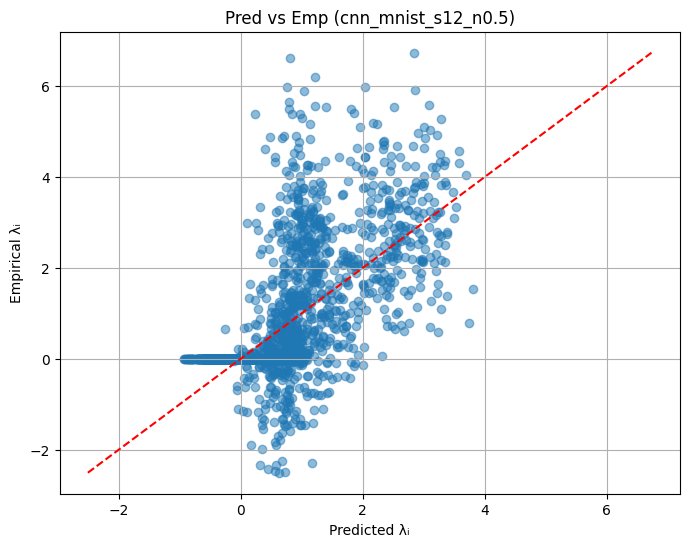

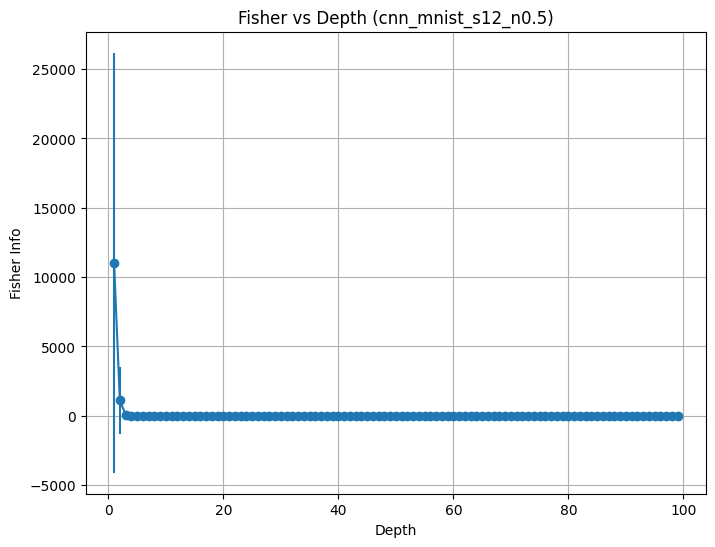

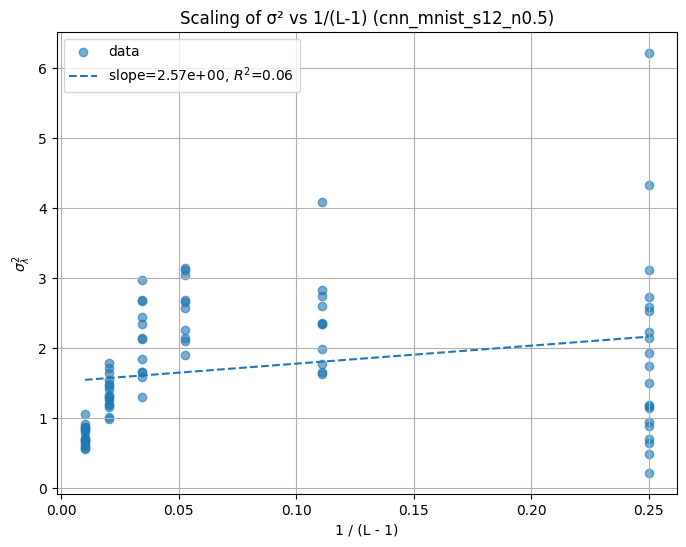


Experiment 19/60: arch=resnet, dataset=cifar, seed=12, noise=0.1
Running run_id       : resnet_cifar_s12_n0.1

Resize scale factor  : 2.42  →  target size 77
Input shape          : (36, 3, 77, 77)


Measuring models: 100%|██████████| 100/100 [23:18<00:00, 13.98s/it]


Generated models accepted       : 92
Unique datapoints               : 3412


>>> λᵢ Prediction
  R²    : 0.311
  RMSE  : 0.732
  Coefficients:
    skip_width: -0.000
    inv_c     : -1.039
    layer_index: -0.481
    block_depth: +0.073
    res_type  : +0.050
    kernel_size: +0.006
    stride    : -0.031
    bottleneck: +0.023
    projection: -0.070
    activation: +0.023
    bias       : +1.962


>>> Fisher Prediction
  R²    : 0.160
  RMSE  : 3665.036
  Coefficients:
    skip_width: -0.319
    inv_c     : -15114.290
    layer_index: -1129.328
    block_depth: -2970.519
    res_type  : -1628.564
    kernel_size: -308.928
    stride    : -2809.439
    bottleneck: +2161.668
    projection: +126.468
    activation: -440.833
    bias       : +7709.014

>>> Scaling with Depth
  λᵢ  ~ depth^-0.132   (R² = 0.007)
  F   ~ depth^-5.738   (R² = 0.740)

>>> Per Fisher Bin Analysis
  Fisher range    : [7.32, 10754.68]
  Depth  range    : [6, 101]
  std(λ) range    : [0.26, 1.61]
  Valid FI bins   : 3 / 20
    FI ≈ 7.32 | Shallow: 14, Deep: 24, Ratio: 0.698
    FI ≈ 572.97 | Shallow: 6, Deep: 7, Ratio: 0.980
    FI ≈ 5663.83 | Shallow: 3, Deep: 3, Ratio: 1.000
  λ variation ratio : 0.893 ± 0.169 (p = 0.0002)
  mean CV(bin)       : 0.234  ± 0.026
  max  CV(bin)       : 0.260
  Mutual information (std λ  vs. architecture features) per FI‐bin:
 fisher_level  mi_std_lambda  mi_pval
     7.32479

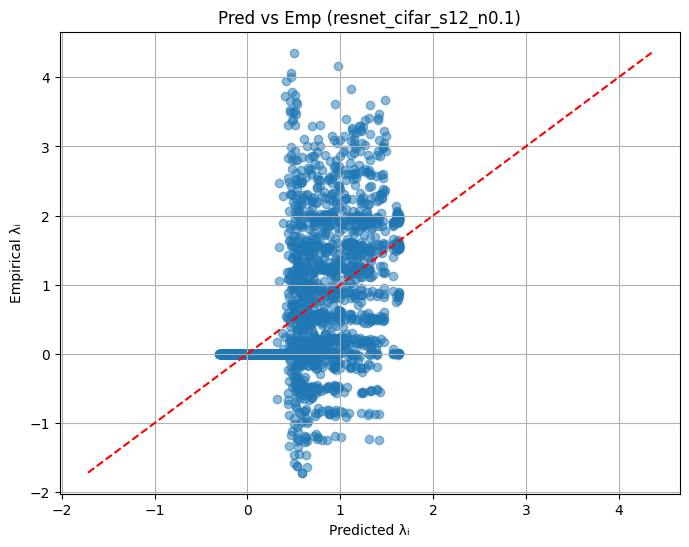

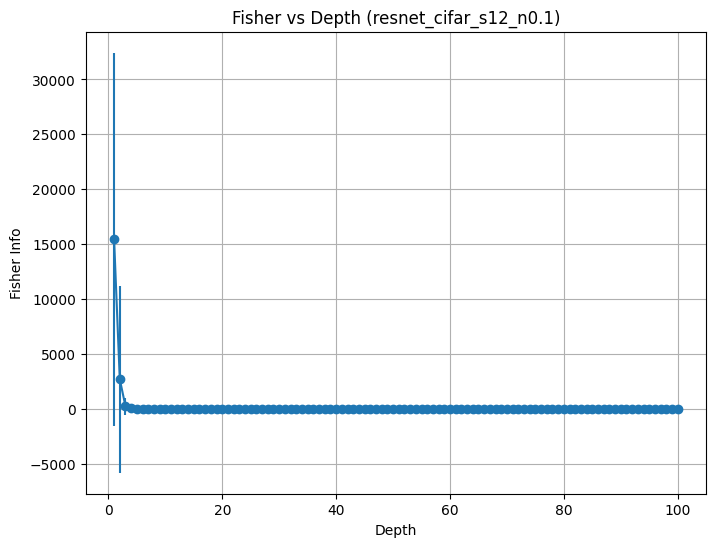

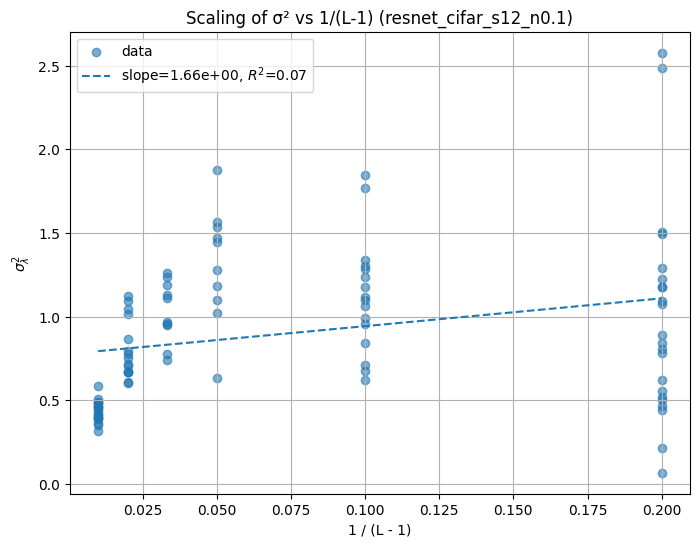


Experiment 20/60: arch=resnet, dataset=cifar, seed=12, noise=0.2
Running run_id       : resnet_cifar_s12_n0.2

Resize scale factor  : 2.42  →  target size 77
Input shape          : (36, 3, 77, 77)


Measuring models: 100%|██████████| 100/100 [24:04<00:00, 14.45s/it]


Generated models accepted       : 92
Unique datapoints               : 3412


>>> λᵢ Prediction
  R²    : 0.315
  RMSE  : 0.733
  Coefficients:
    skip_width: -0.000
    inv_c     : -1.061
    layer_index: -0.487
    block_depth: +0.078
    res_type  : +0.055
    kernel_size: +0.006
    stride    : -0.042
    bottleneck: +0.021
    projection: -0.073
    activation: +0.023
    bias       : +1.998


>>> Fisher Prediction
  R²    : 0.160
  RMSE  : 3665.036
  Coefficients:
    skip_width: -0.319
    inv_c     : -15114.290
    layer_index: -1129.328
    block_depth: -2970.519
    res_type  : -1628.564
    kernel_size: -308.928
    stride    : -2809.439
    bottleneck: +2161.668
    projection: +126.468
    activation: -440.833
    bias       : +7709.014

>>> Scaling with Depth
  λᵢ  ~ depth^-0.153   (R² = 0.009)
  F   ~ depth^-5.738   (R² = 0.740)

>>> Per Fisher Bin Analysis
  Fisher range    : [7.32, 10754.68]
  Depth  range    : [6, 101]
  std(λ) range    : [0.25, 1.59]
  Valid FI bins   : 3 / 20
    FI ≈ 7.32 | Shallow: 14, Deep: 24, Ratio: 0.701
    FI ≈ 572.97 | Shallow: 6, Deep: 7, Ratio: 0.989
    FI ≈ 5663.83 | Shallow: 3, Deep: 3, Ratio: 1.000
  λ variation ratio : 0.897 ± 0.169 (p = 0.0002)
  mean CV(bin)       : 0.233  ± 0.027
  max  CV(bin)       : 0.260
  Mutual information (std λ  vs. architecture features) per FI‐bin:
 fisher_level  mi_std_lambda  mi_pval
     7.32479

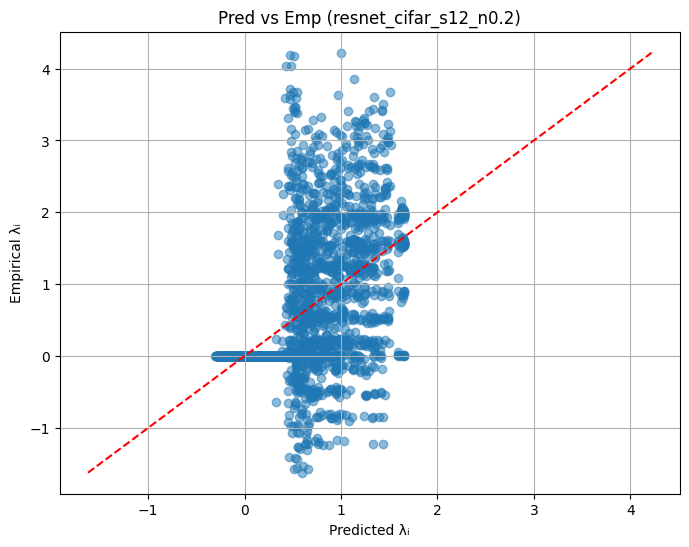

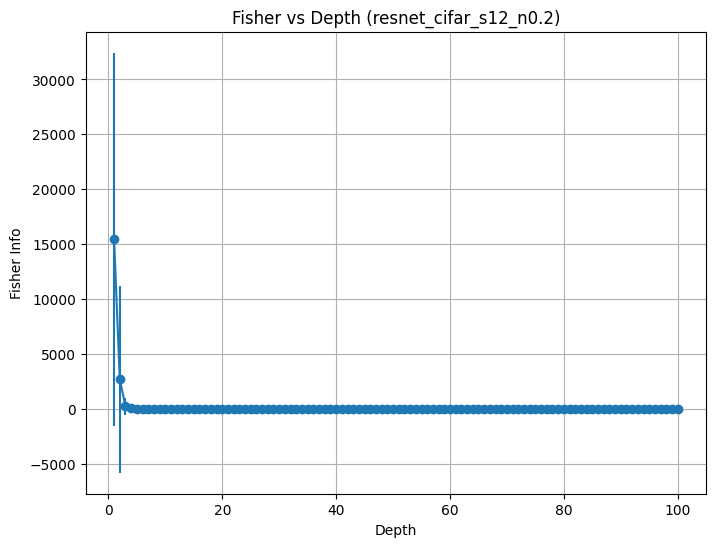

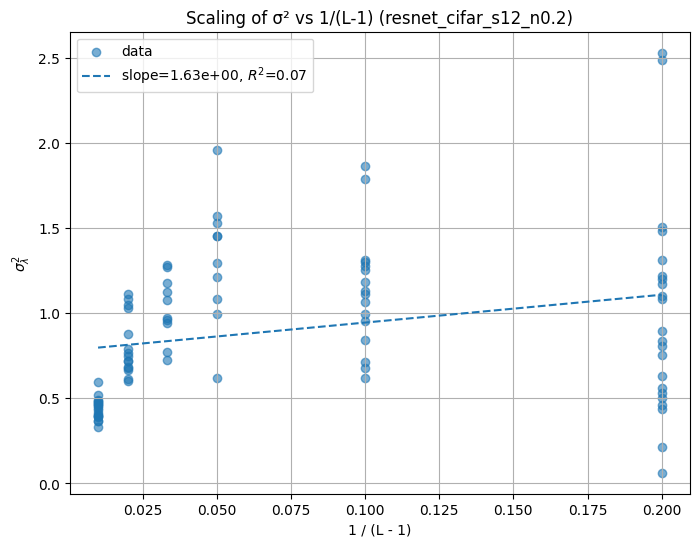


Experiment 21/60: arch=resnet, dataset=cifar, seed=12, noise=0.5
Running run_id       : resnet_cifar_s12_n0.5

Resize scale factor  : 2.42  →  target size 77
Input shape          : (36, 3, 77, 77)


Measuring models: 100%|██████████| 100/100 [23:58<00:00, 14.39s/it]


Generated models accepted       : 92
Unique datapoints               : 3414


>>> λᵢ Prediction
  R²    : 0.310
  RMSE  : 0.743
  Coefficients:
    skip_width: -0.000
    inv_c     : -1.086
    layer_index: -0.491
    block_depth: +0.085
    res_type  : +0.063
    kernel_size: +0.005
    stride    : -0.078
    bottleneck: +0.019
    projection: -0.073
    activation: +0.027
    bias       : +2.045


>>> Fisher Prediction
  R²    : 0.160
  RMSE  : 3665.036
  Coefficients:
    skip_width: -0.319
    inv_c     : -15114.290
    layer_index: -1129.328
    block_depth: -2970.519
    res_type  : -1628.564
    kernel_size: -308.928
    stride    : -2809.439
    bottleneck: +2161.668
    projection: +126.468
    activation: -440.833
    bias       : +7709.014

>>> Scaling with Depth
  λᵢ  ~ depth^-0.118   (R² = 0.006)
  F   ~ depth^-5.738   (R² = 0.740)

>>> Per Fisher Bin Analysis
  Fisher range    : [7.32, 10754.68]
  Depth  range    : [6, 101]
  std(λ) range    : [0.23, 1.58]
  Valid FI bins   : 3 / 20
    FI ≈ 7.32 | Shallow: 14, Deep: 24, Ratio: 0.717
    FI ≈ 572.97 | Shallow: 6, Deep: 7, Ratio: 1.003
    FI ≈ 5663.83 | Shallow: 3, Deep: 3, Ratio: 1.000
  λ variation ratio : 0.907 ± 0.165 (p = 0.0005)
  mean CV(bin)       : 0.232  ± 0.023
  max  CV(bin)       : 0.255
  Mutual information (std λ  vs. architecture features) per FI‐bin:
 fisher_level  mi_std_lambda  mi_pval
     7.32479

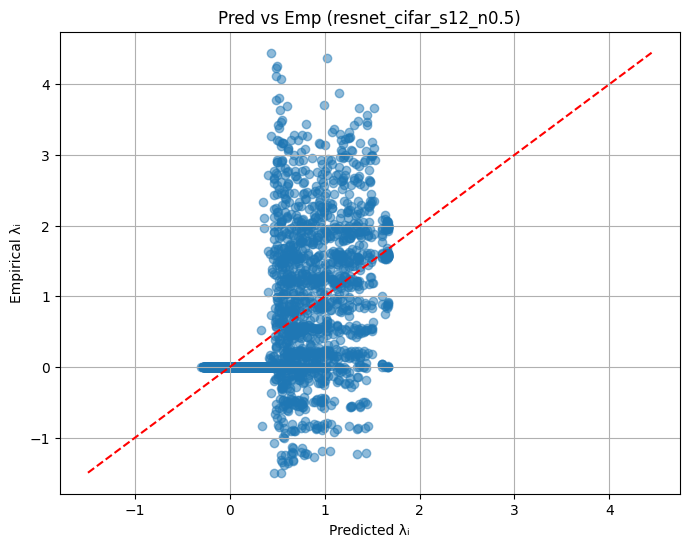

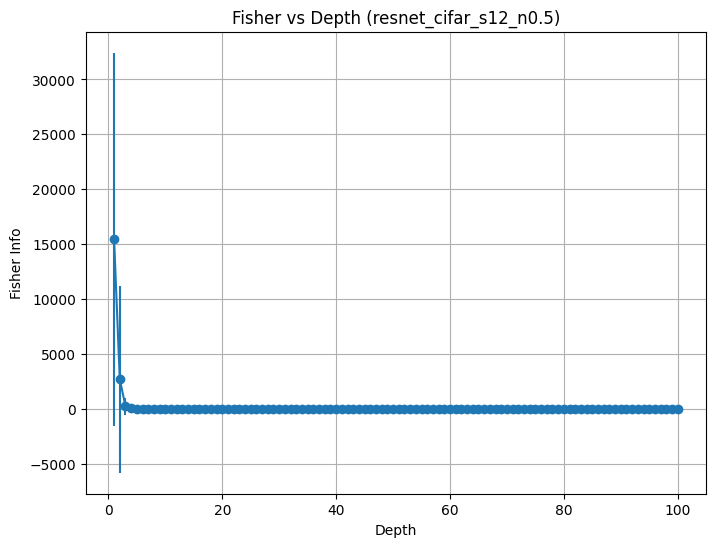

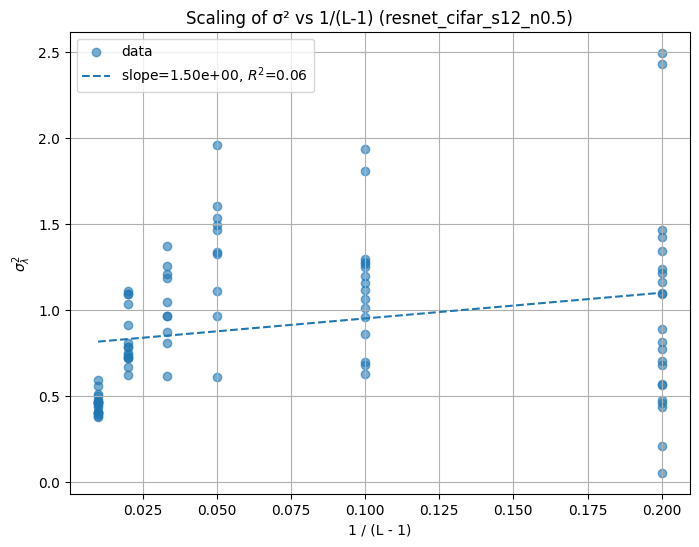


Experiment 22/60: arch=resnet, dataset=mnist, seed=12, noise=0.1
Running run_id       : resnet_mnist_s12_n0.1

Resize scale factor  : 2.42  →  target size 67
Input shape          : (36, 1, 67, 67)


Measuring models: 100%|██████████| 100/100 [25:05<00:00, 15.05s/it]


Generated models accepted       : 88
Unique datapoints               : 3176


>>> λᵢ Prediction
  R²    : 0.287
  RMSE  : 0.745
  Coefficients:
    skip_width: +0.000
    inv_c     : -0.784
    layer_index: -0.471
    block_depth: +0.056
    res_type  : +0.024
    kernel_size: +0.018
    stride    : -0.042
    bottleneck: -0.073
    projection: +0.009
    activation: -0.028
    bias       : +1.965


>>> Fisher Prediction
  R²    : 0.143
  RMSE  : 3124.613
  Coefficients:
    skip_width: -0.330
    inv_c     : -15993.818
    layer_index: -898.861
    block_depth: -2524.318
    res_type  : -1374.038
    kernel_size: -155.188
    stride    : -2146.310
    bottleneck: +1425.187
    projection: +31.155
    activation: -370.355
    bias       : +6136.963

>>> Scaling with Depth
  λᵢ  ~ depth^-0.198   (R² = 0.016)
  F   ~ depth^-5.728   (R² = 0.746)

>>> Per Fisher Bin Analysis
  Fisher range    : [4.92, 10776.49]
  Depth  range    : [6, 101]
  std(λ) range    : [0.46, 1.72]
  Valid FI bins   : 3 / 20
    FI ≈ 4.92 | Shallow: 19, Deep: 23, Ratio: 0.755
    FI ≈ 571.85 | Shallow: 9, Deep: 9, Ratio: 0.802
    FI ≈ 1138.77 | Shallow: 4, Deep: 5, Ratio: 1.148
  λ variation ratio : 0.902 ± 0.214 (p = 0.0009)
  mean CV(bin)       : 0.217  ± 0.040
  max  CV(bin)       : 0.256
  Mutual information (std λ  vs. architecture features) per FI‐bin:
 fisher_level  mi_std_lambda  mi_pval
     4.923361 

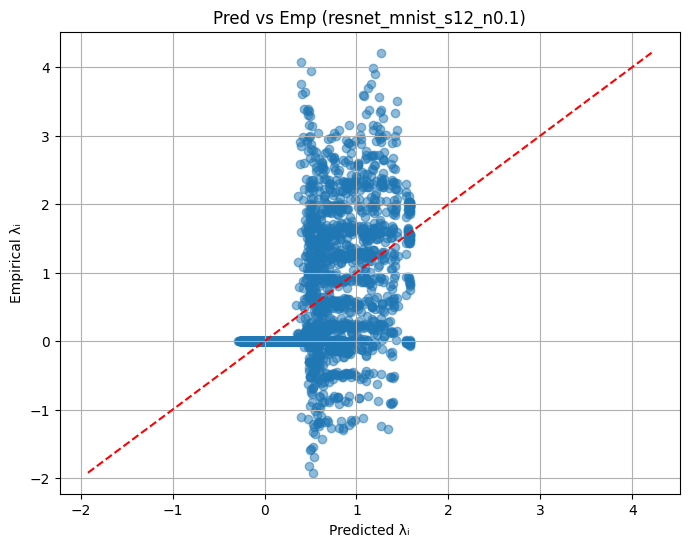

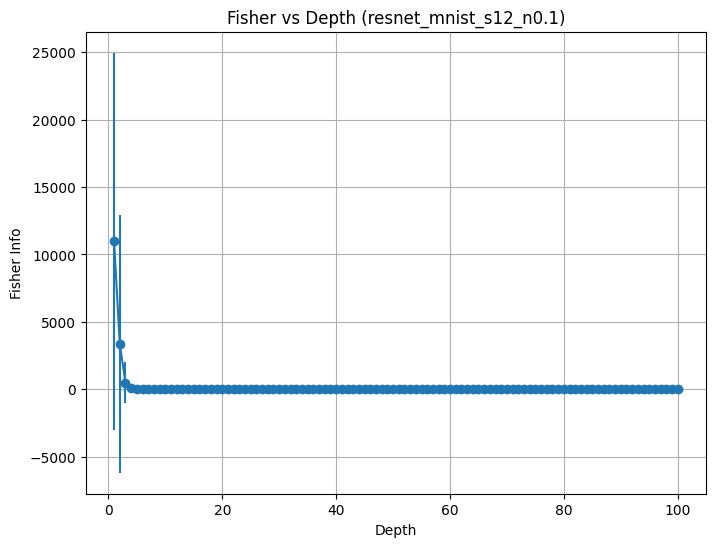

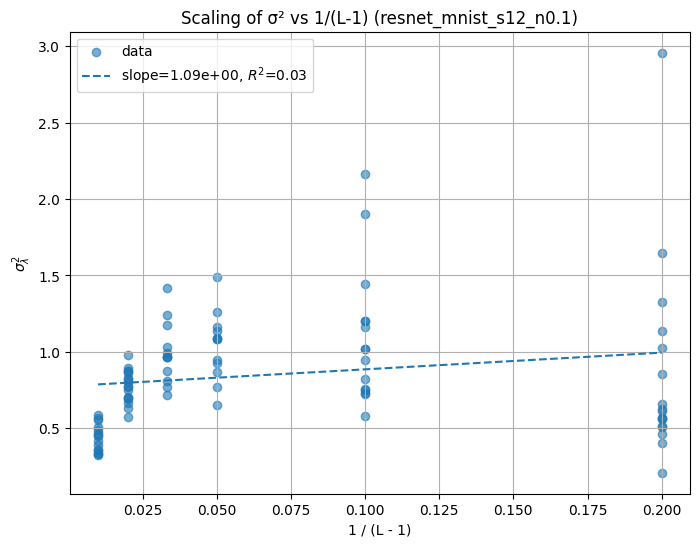


Experiment 23/60: arch=resnet, dataset=mnist, seed=12, noise=0.2
Running run_id       : resnet_mnist_s12_n0.2

Resize scale factor  : 2.42  →  target size 67
Input shape          : (36, 1, 67, 67)


Measuring models: 100%|██████████| 100/100 [25:18<00:00, 15.18s/it]


Generated models accepted       : 88
Unique datapoints               : 3176


>>> λᵢ Prediction
  R²    : 0.284
  RMSE  : 0.750
  Coefficients:
    skip_width: +0.000
    inv_c     : -0.869
    layer_index: -0.473
    block_depth: +0.067
    res_type  : +0.033
    kernel_size: +0.018
    stride    : -0.058
    bottleneck: -0.079
    projection: +0.007
    activation: -0.027
    bias       : +1.990


>>> Fisher Prediction
  R²    : 0.143
  RMSE  : 3124.613
  Coefficients:
    skip_width: -0.330
    inv_c     : -15993.818
    layer_index: -898.861
    block_depth: -2524.318
    res_type  : -1374.038
    kernel_size: -155.188
    stride    : -2146.310
    bottleneck: +1425.187
    projection: +31.155
    activation: -370.355
    bias       : +6136.963

>>> Scaling with Depth
  λᵢ  ~ depth^-0.165   (R² = 0.011)
  F   ~ depth^-5.728   (R² = 0.746)

>>> Per Fisher Bin Analysis
  Fisher range    : [4.92, 10776.49]
  Depth  range    : [6, 101]
  std(λ) range    : [0.47, 1.73]
  Valid FI bins   : 3 / 20
    FI ≈ 4.92 | Shallow: 19, Deep: 23, Ratio: 0.767
    FI ≈ 571.85 | Shallow: 9, Deep: 9, Ratio: 0.803
    FI ≈ 1138.77 | Shallow: 4, Deep: 5, Ratio: 1.142
  λ variation ratio : 0.904 ± 0.207 (p = 0.0011)
  mean CV(bin)       : 0.212  ± 0.041
  max  CV(bin)       : 0.253
  Mutual information (std λ  vs. architecture features) per FI‐bin:
 fisher_level  mi_std_lambda  mi_pval
     4.923361 

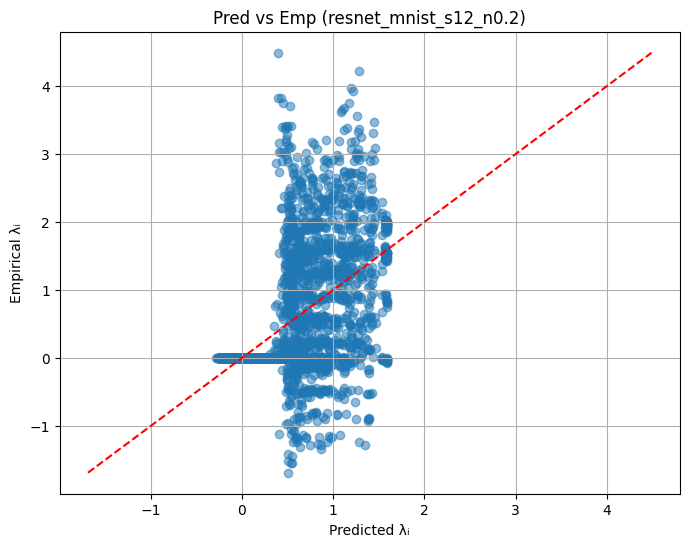

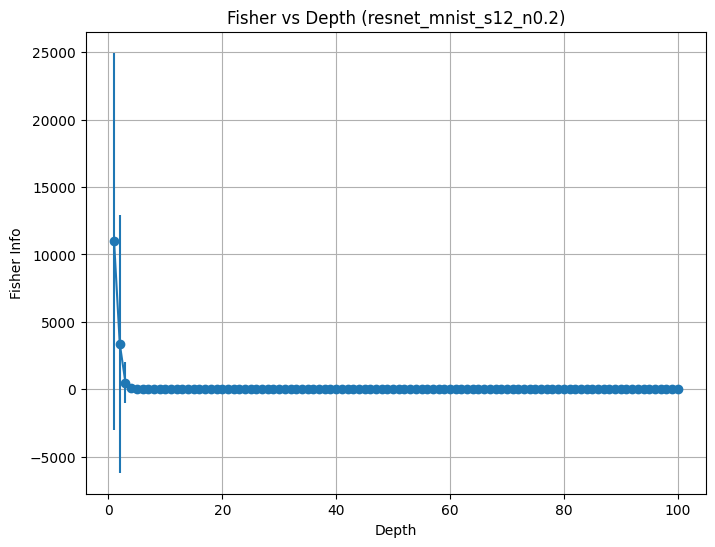

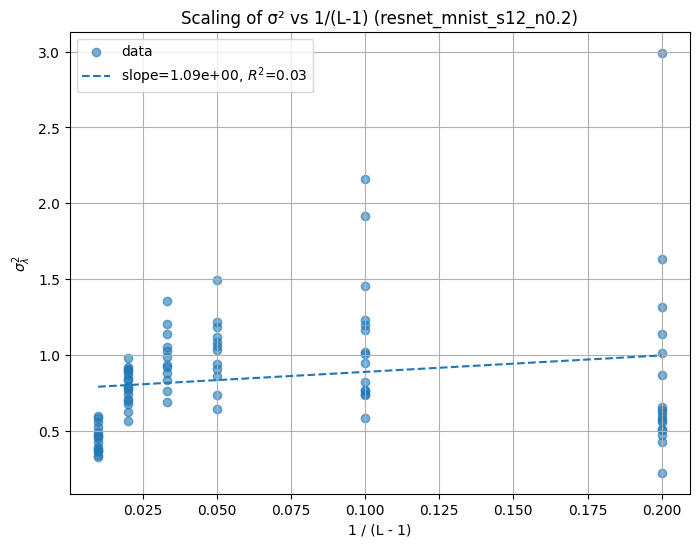


Experiment 24/60: arch=resnet, dataset=mnist, seed=12, noise=0.5
Running run_id       : resnet_mnist_s12_n0.5

Resize scale factor  : 2.42  →  target size 67
Input shape          : (36, 1, 67, 67)


Measuring models: 100%|██████████| 100/100 [24:59<00:00, 15.00s/it]


Generated models accepted       : 88
Unique datapoints               : 3176


>>> λᵢ Prediction
  R²    : 0.272
  RMSE  : 0.766
  Coefficients:
    skip_width: -0.000
    inv_c     : -1.037
    layer_index: -0.470
    block_depth: +0.090
    res_type  : +0.047
    kernel_size: +0.014
    stride    : -0.071
    bottleneck: -0.071
    projection: +0.016
    activation: -0.024
    bias       : +1.994


>>> Fisher Prediction
  R²    : 0.143
  RMSE  : 3124.613
  Coefficients:
    skip_width: -0.330
    inv_c     : -15993.818
    layer_index: -898.861
    block_depth: -2524.318
    res_type  : -1374.038
    kernel_size: -155.188
    stride    : -2146.310
    bottleneck: +1425.187
    projection: +31.155
    activation: -370.355
    bias       : +6136.963

>>> Scaling with Depth
  λᵢ  ~ depth^-0.148   (R² = 0.010)
  F   ~ depth^-5.728   (R² = 0.746)

>>> Per Fisher Bin Analysis
  Fisher range    : [4.92, 10776.49]
  Depth  range    : [6, 101]
  std(λ) range    : [0.49, 1.74]
  Valid FI bins   : 3 / 20
    FI ≈ 4.92 | Shallow: 19, Deep: 23, Ratio: 0.798
    FI ≈ 571.85 | Shallow: 9, Deep: 9, Ratio: 0.795
    FI ≈ 1138.77 | Shallow: 4, Deep: 5, Ratio: 1.129
  λ variation ratio : 0.908 ± 0.192 (p = 0.0202)
  mean CV(bin)       : 0.207  ± 0.045
  max  CV(bin)       : 0.256
  Mutual information (std λ  vs. architecture features) per FI‐bin:
 fisher_level  mi_std_lambda  mi_pval
     4.923361 

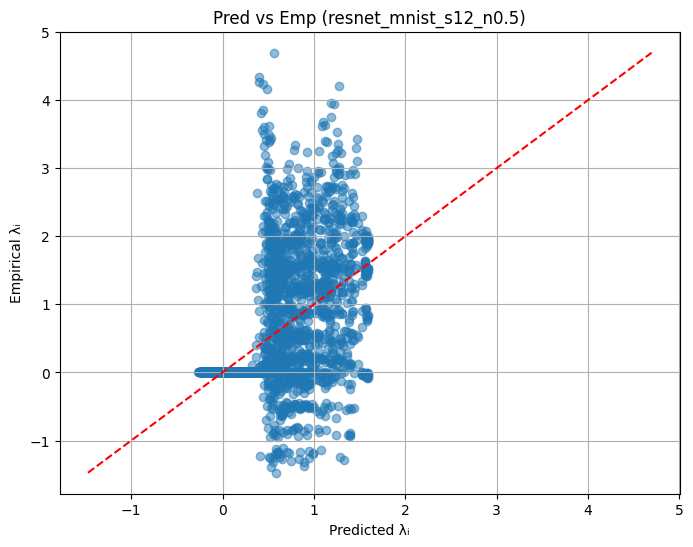

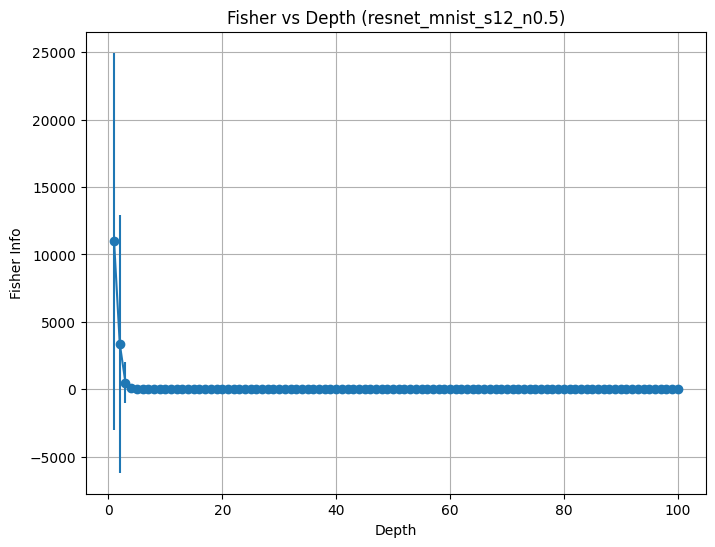

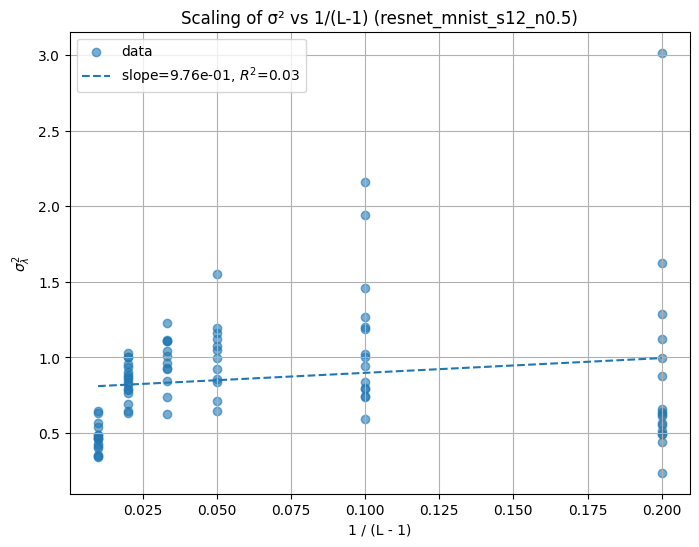


Experiment 25/60: arch=cnn, dataset=cifar, seed=123, noise=0.1
Running run_id       : cnn_cifar_s123_n0.1

Resize scale factor  : 1.16  →  target size 37
Files already downloaded and verified
Input shape          : (36, 3, 37, 37)


Measuring models: 100%|██████████| 100/100 [04:13<00:00,  2.53s/it]


Generated models accepted       : 87
Unique datapoints               : 2534


>>> λᵢ Prediction
  R²    : 0.492
  RMSE  : 0.918
  Coefficients:
    s_r       : +2.727 × x^1.990
    inv_c     : -5.240
    d         : -0.491
    o         : -3.039
    bias       : +4.441


>>> Fisher Prediction
  R²    : 0.091
  RMSE  : 1195.584
  Coefficients:
    s_r       : +656.757 × x^0.529
    inv_c     : -2740.125
    d         : -253.512
    o         : -1398.433
    bias       : +1912.878

>>> Scaling with Depth
  λᵢ  ~ depth^-0.598   (R² = 0.172)
  F   ~ depth^-4.218   (R² = 0.608)

>>> Per Fisher Bin Analysis
  Fisher range    : [2.58, 5701.98]
  Depth  range    : [5, 100]
  std(λ) range    : [0.61, 2.29]
  Valid FI bins   : 3 / 20
    FI ≈ 2.58 | Shallow: 21, Deep: 23, Ratio: 0.606
    FI ≈ 302.55 | Shallow: 5, Deep: 4, Ratio: 1.367
    FI ≈ 602.52 | Shallow: 3, Deep: 6, Ratio: 1.081
  λ variation ratio : 1.018 ± 0.384 (p = 0.0049)
  mean CV(bin)       : 0.251  ± 0.089
  max  CV(bin)       : 0.316
  Mutual information (std λ  vs. architecture features) per FI‐bin:
 fisher_level  mi_std_lambda  mi_pval
     2.580220       0.000000 1.000000
   302.548866       0.000000 1.000000
   602.517511       0.015873 0.442786
   902.486157       0.000000 1.000000
  1202.4

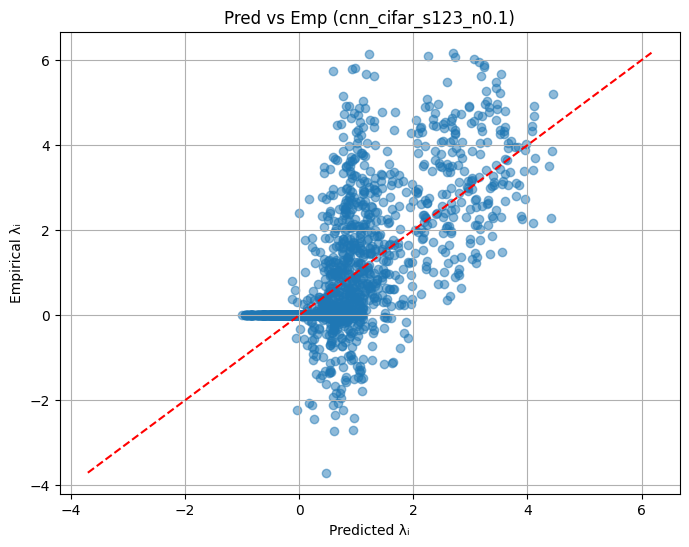

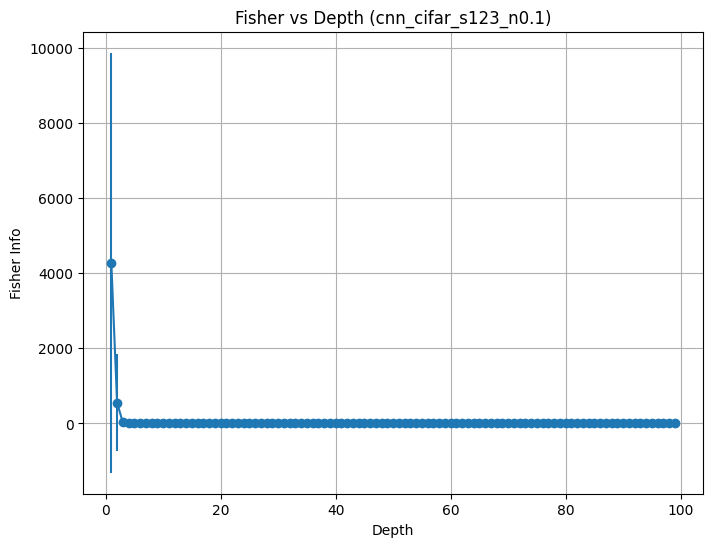

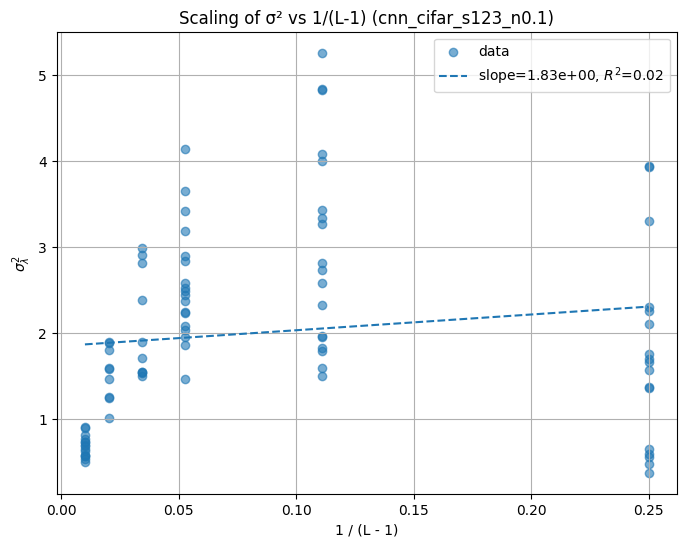


Experiment 26/60: arch=cnn, dataset=cifar, seed=123, noise=0.2
Running run_id       : cnn_cifar_s123_n0.2

Resize scale factor  : 1.16  →  target size 37
Input shape          : (36, 3, 37, 37)


Measuring models: 100%|██████████| 100/100 [04:12<00:00,  2.52s/it]


Generated models accepted       : 87
Unique datapoints               : 2534


>>> λᵢ Prediction
  R²    : 0.479
  RMSE  : 0.928
  Coefficients:
    s_r       : +2.533 × x^2.073
    inv_c     : -5.372
    d         : -0.515
    o         : -2.719
    bias       : +4.306


>>> Fisher Prediction
  R²    : 0.091
  RMSE  : 1195.584
  Coefficients:
    s_r       : +656.757 × x^0.529
    inv_c     : -2740.125
    d         : -253.512
    o         : -1398.433
    bias       : +1912.878

>>> Scaling with Depth
  λᵢ  ~ depth^-0.527   (R² = 0.143)
  F   ~ depth^-4.218   (R² = 0.608)

>>> Per Fisher Bin Analysis
  Fisher range    : [2.58, 5701.98]
  Depth  range    : [5, 100]
  std(λ) range    : [0.62, 2.30]
  Valid FI bins   : 3 / 20
    FI ≈ 2.58 | Shallow: 21, Deep: 23, Ratio: 0.616
    FI ≈ 302.55 | Shallow: 5, Deep: 4, Ratio: 1.382
    FI ≈ 602.52 | Shallow: 3, Deep: 6, Ratio: 1.089
  λ variation ratio : 1.029 ± 0.386 (p = 0.0079)
  mean CV(bin)       : 0.251  ± 0.089
  max  CV(bin)       : 0.316
  Mutual information (std λ  vs. architecture features) per FI‐bin:
 fisher_level  mi_std_lambda  mi_pval
     2.580220       0.000000 1.000000
   302.548866       0.000000 1.000000
   602.517511       0.000000 1.000000
   902.486157       0.000000 1.000000
  1202.4

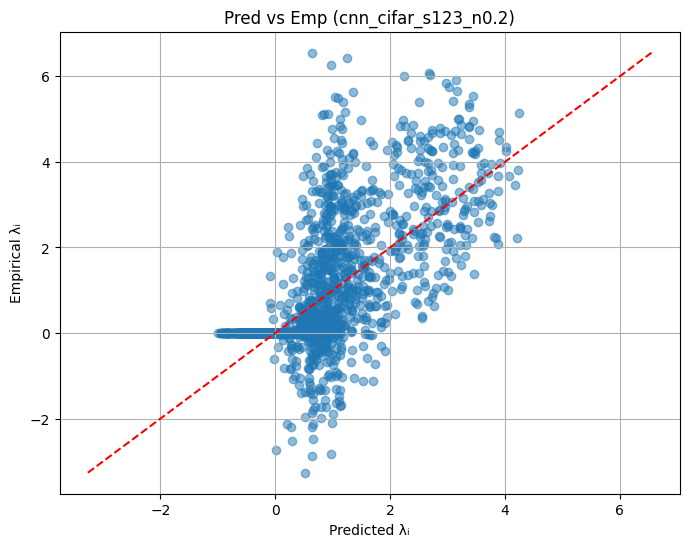

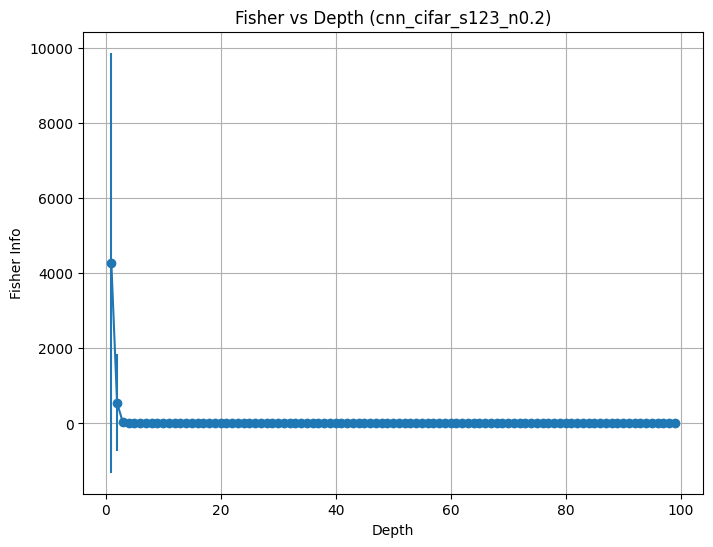

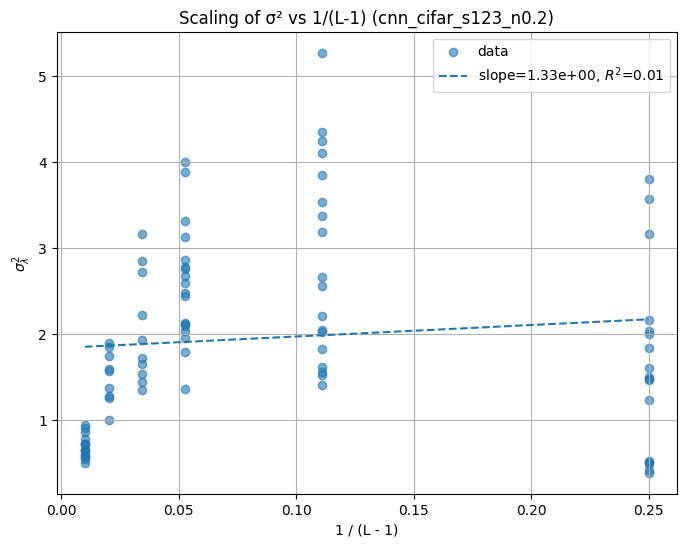


Experiment 27/60: arch=cnn, dataset=cifar, seed=123, noise=0.5
Running run_id       : cnn_cifar_s123_n0.5

Resize scale factor  : 1.16  →  target size 37
Input shape          : (36, 3, 37, 37)


Measuring models: 100%|██████████| 100/100 [04:13<00:00,  2.53s/it]


Generated models accepted       : 87
Unique datapoints               : 2533


>>> λᵢ Prediction
  R²    : 0.451
  RMSE  : 0.959
  Coefficients:
    s_r       : +2.249 × x^2.175
    inv_c     : -5.537
    d         : -0.546
    o         : -2.248
    bias       : +4.079


>>> Fisher Prediction
  R²    : 0.091
  RMSE  : 1195.584
  Coefficients:
    s_r       : +656.757 × x^0.529
    inv_c     : -2740.125
    d         : -253.512
    o         : -1398.433
    bias       : +1912.878

>>> Scaling with Depth
  λᵢ  ~ depth^-0.362   (R² = 0.077)
  F   ~ depth^-4.218   (R² = 0.608)

>>> Per Fisher Bin Analysis
  Fisher range    : [2.58, 5701.98]
  Depth  range    : [5, 100]
  std(λ) range    : [0.58, 2.33]
  Valid FI bins   : 3 / 20
    FI ≈ 2.58 | Shallow: 21, Deep: 23, Ratio: 0.640
    FI ≈ 302.55 | Shallow: 5, Deep: 4, Ratio: 1.440
    FI ≈ 602.52 | Shallow: 3, Deep: 6, Ratio: 1.136
  λ variation ratio : 1.072 ± 0.404 (p = 0.0262)
  mean CV(bin)       : 0.242  ± 0.086
  max  CV(bin)       : 0.308
  Mutual information (std λ  vs. architecture features) per FI‐bin:
 fisher_level  mi_std_lambda  mi_pval
     2.580220       0.000000 1.000000
   302.548866       0.002387 0.422886
   602.517511       0.055556 0.388060
   902.486157       0.000000 1.000000
  1202.4

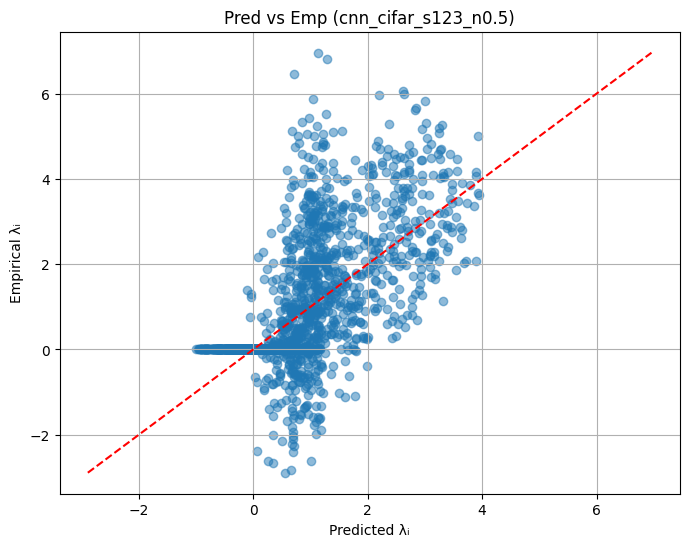

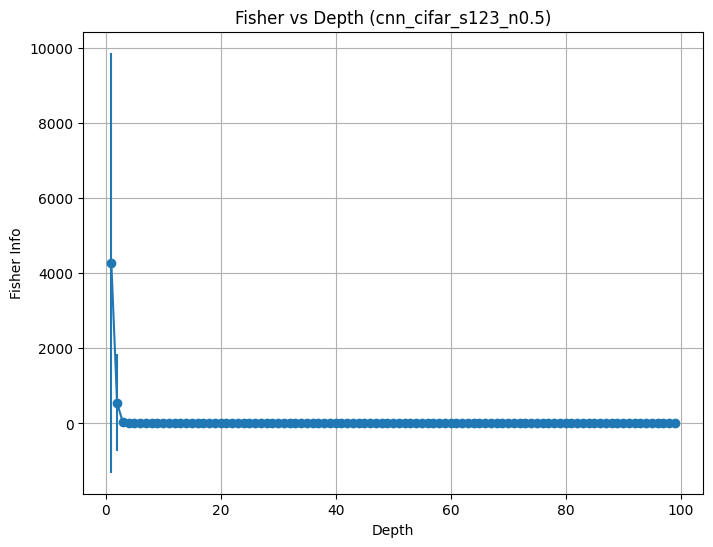

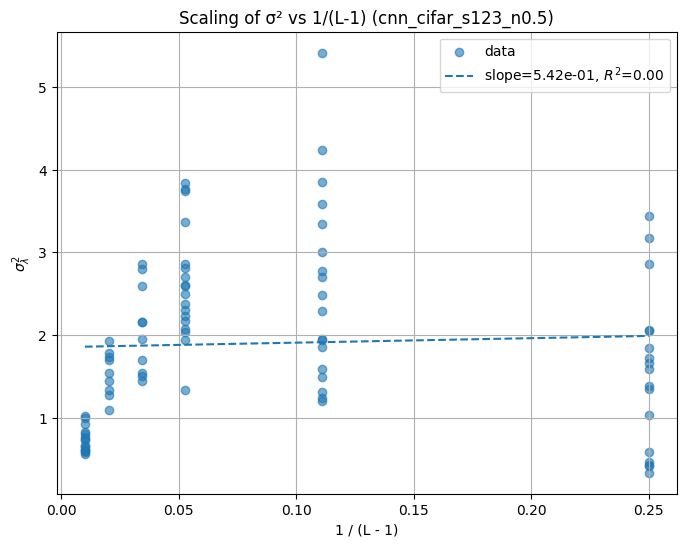


Experiment 28/60: arch=cnn, dataset=mnist, seed=123, noise=0.1
Running run_id       : cnn_mnist_s123_n0.1

Resize scale factor  : 1.16  →  target size 32
Input shape          : (36, 1, 32, 32)


Measuring models: 100%|██████████| 100/100 [05:38<00:00,  3.38s/it]


Generated models accepted       : 84
Unique datapoints               : 2712


>>> λᵢ Prediction
  R²    : 0.492
  RMSE  : 0.873
  Coefficients:
    s_r       : +2.708 × x^1.086
    inv_c     : -4.615
    d         : -0.483
    o         : -4.535
    bias       : +5.277


>>> Fisher Prediction
  R²    : 0.095
  RMSE  : 1300.964
  Coefficients:
    s_r       : +959.107 × x^0.496
    inv_c     : -2714.841
    d         : -279.641
    o         : -2283.137
    bias       : +2613.987

>>> Scaling with Depth
  λᵢ  ~ depth^-0.603   (R² = 0.163)
  F   ~ depth^-4.381   (R² = 0.621)

>>> Per Fisher Bin Analysis
  Fisher range    : [3.11, 2781.81]
  Depth  range    : [5, 100]
  std(λ) range    : [0.47, 2.39]
  Valid FI bins   : 2 / 20
    FI ≈ 3.11 | Shallow: 16, Deep: 20, Ratio: 0.682
    FI ≈ 149.36 | Shallow: 7, Deep: 8, Ratio: 0.744
  λ variation ratio : 0.713 ± 0.044 (p = 0.0000)
  mean CV(bin)       : 0.280  ± 0.015
  max  CV(bin)       : 0.294
  Mutual information (std λ  vs. architecture features) per FI‐bin:
 fisher_level  mi_std_lambda  mi_pval
     3.110959   0.000000e+00 1.000000
   149.358499   3.326022e-02 0.333333
   295.606038   1.110223e-16 1.000000
   441.853577   1.110223e-16 1.000000
   588.101116   1.110223e-16 1.000000
   734.348655   0.0000

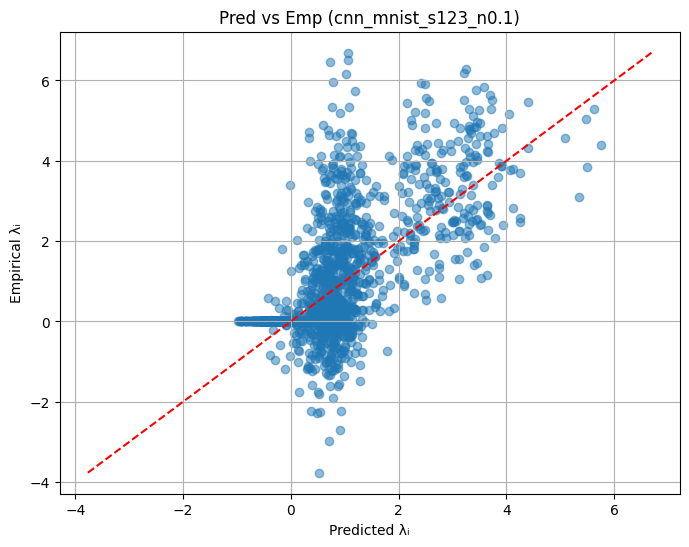

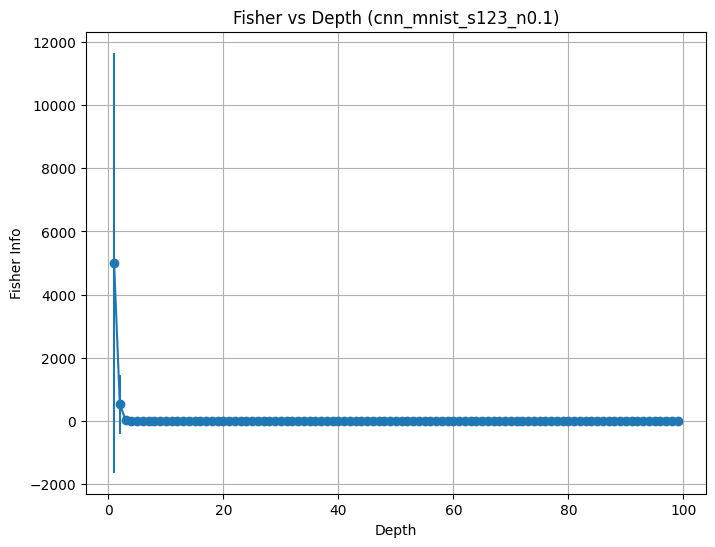

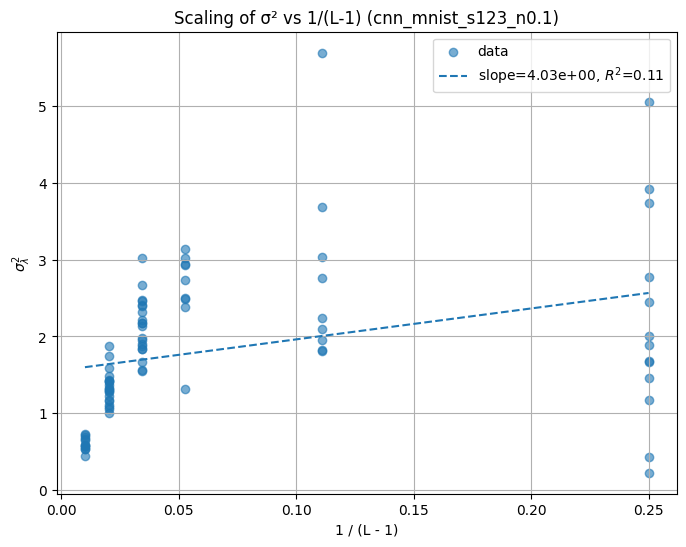


Experiment 29/60: arch=cnn, dataset=mnist, seed=123, noise=0.2
Running run_id       : cnn_mnist_s123_n0.2

Resize scale factor  : 1.16  →  target size 32
Input shape          : (36, 1, 32, 32)


Measuring models: 100%|██████████| 100/100 [05:34<00:00,  3.35s/it]


Generated models accepted       : 84
Unique datapoints               : 2713


>>> λᵢ Prediction
  R²    : 0.474
  RMSE  : 0.893
  Coefficients:
    s_r       : +2.511 × x^1.057
    inv_c     : -4.932
    d         : -0.506
    o         : -4.244
    bias       : +5.153


>>> Fisher Prediction
  R²    : 0.095
  RMSE  : 1300.964
  Coefficients:
    s_r       : +959.107 × x^0.496
    inv_c     : -2714.841
    d         : -279.641
    o         : -2283.137
    bias       : +2613.987

>>> Scaling with Depth
  λᵢ  ~ depth^-0.468   (R² = 0.104)
  F   ~ depth^-4.381   (R² = 0.621)

>>> Per Fisher Bin Analysis
  Fisher range    : [3.11, 2781.81]
  Depth  range    : [5, 100]
  std(λ) range    : [0.44, 2.29]
  Valid FI bins   : 2 / 20
    FI ≈ 3.11 | Shallow: 16, Deep: 20, Ratio: 0.696
    FI ≈ 149.36 | Shallow: 7, Deep: 8, Ratio: 0.747
  λ variation ratio : 0.721 ± 0.036 (p = 0.0000)
  mean CV(bin)       : 0.278  ± 0.009
  max  CV(bin)       : 0.287
  Mutual information (std λ  vs. architecture features) per FI‐bin:
 fisher_level  mi_std_lambda  mi_pval
     3.110959   0.000000e+00   1.0000
   149.358499   1.244607e-01   0.0199
   295.606038   1.110223e-16   1.0000
   441.853577   1.110223e-16   1.0000
   588.101116   1.110223e-16   1.0000
   734.348655   0.0000

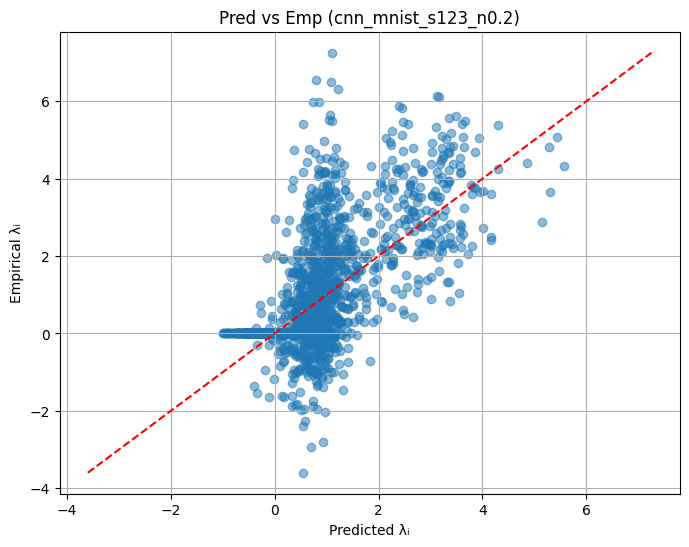

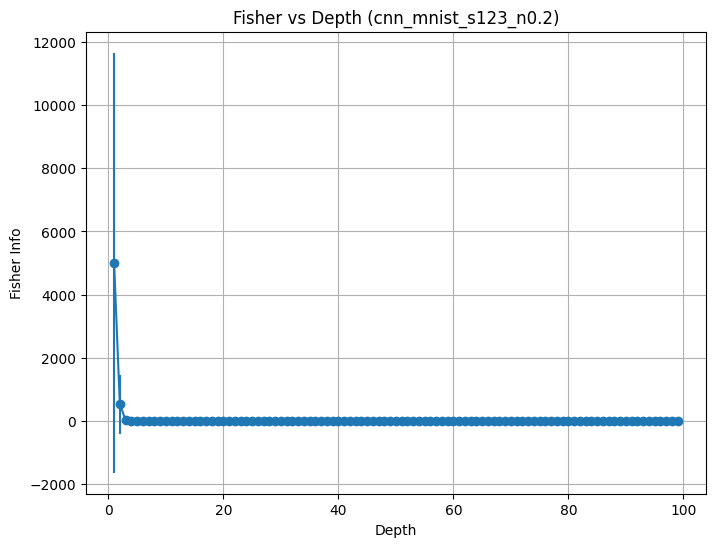

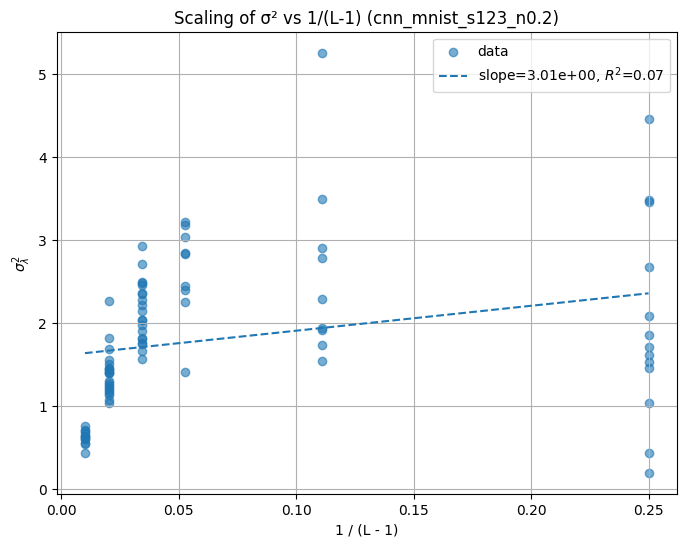


Experiment 30/60: arch=cnn, dataset=mnist, seed=123, noise=0.5
Running run_id       : cnn_mnist_s123_n0.5

Resize scale factor  : 1.16  →  target size 32
Input shape          : (36, 1, 32, 32)


Measuring models: 100%|██████████| 100/100 [05:34<00:00,  3.35s/it]


Generated models accepted       : 84
Unique datapoints               : 2714


>>> λᵢ Prediction
  R²    : 0.437
  RMSE  : 0.941
  Coefficients:
    s_r       : +2.218 × x^1.035
    inv_c     : -5.141
    d         : -0.536
    o         : -3.728
    bias       : +4.898


>>> Fisher Prediction
  R²    : 0.095
  RMSE  : 1300.964
  Coefficients:
    s_r       : +959.107 × x^0.496
    inv_c     : -2714.841
    d         : -279.641
    o         : -2283.137
    bias       : +2613.987

>>> Scaling with Depth
  λᵢ  ~ depth^-0.420   (R² = 0.089)
  F   ~ depth^-4.381   (R² = 0.621)

>>> Per Fisher Bin Analysis
  Fisher range    : [3.11, 2781.81]
  Depth  range    : [5, 100]
  std(λ) range    : [0.41, 2.17]
  Valid FI bins   : 2 / 20
    FI ≈ 3.11 | Shallow: 16, Deep: 20, Ratio: 0.718
    FI ≈ 149.36 | Shallow: 7, Deep: 8, Ratio: 0.755
  λ variation ratio : 0.736 ± 0.026 (p = 0.0000)
  mean CV(bin)       : 0.273  ± 0.004
  max  CV(bin)       : 0.277
  Mutual information (std λ  vs. architecture features) per FI‐bin:
 fisher_level  mi_std_lambda  mi_pval
     3.110959   0.000000e+00      1.0
   149.358499   0.000000e+00      1.0
   295.606038   1.110223e-16      1.0
   441.853577   1.110223e-16      1.0
   588.101116   1.110223e-16      1.0
   734.348655   0.0000

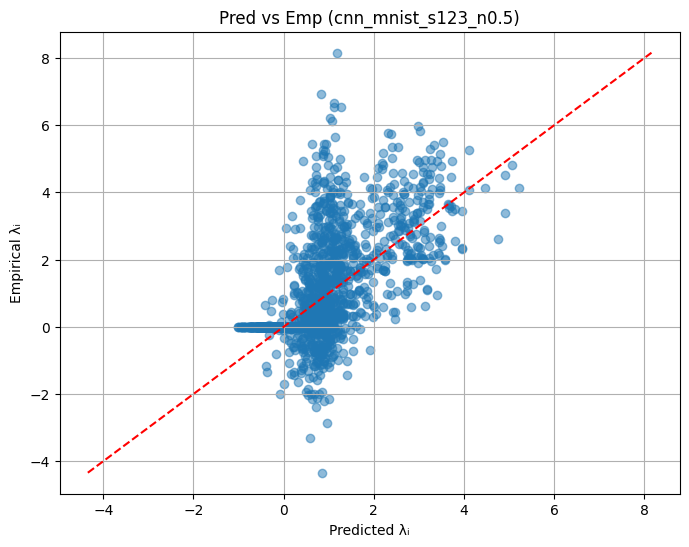

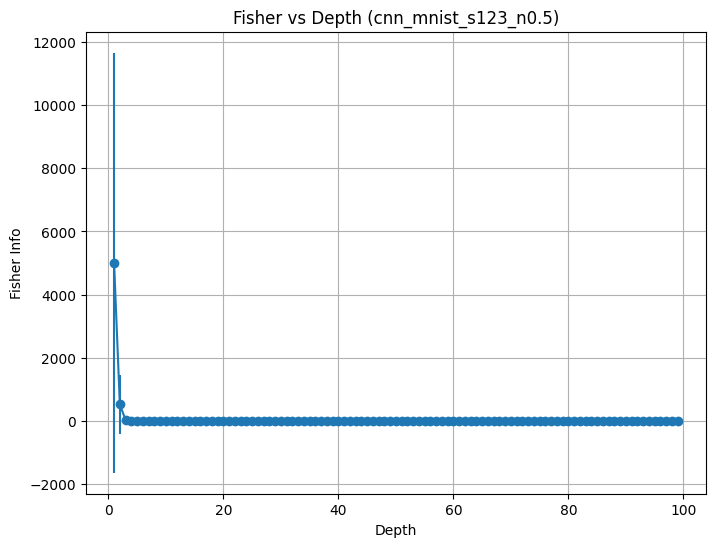

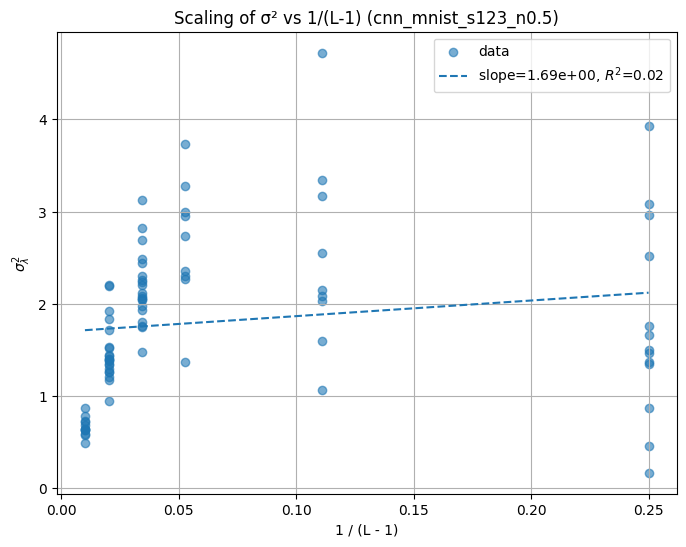


Experiment 31/60: arch=resnet, dataset=cifar, seed=123, noise=0.1
Running run_id       : resnet_cifar_s123_n0.1

Resize scale factor  : 1.16  →  target size 37
Input shape          : (36, 3, 37, 37)


Measuring models: 100%|██████████| 100/100 [16:27<00:00,  9.88s/it]


Generated models accepted       : 86
Unique datapoints               : 2778


>>> λᵢ Prediction
  R²    : 0.248
  RMSE  : 0.809
  Coefficients:
    skip_width: -0.000
    inv_c     : -1.670
    layer_index: -0.452
    block_depth: +0.092
    res_type  : +0.028
    kernel_size: +0.053
    stride    : +0.067
    bottleneck: +0.024
    projection: +0.031
    activation: -0.012
    bias       : +1.708


>>> Fisher Prediction
  R²    : 0.178
  RMSE  : 1800.609
  Coefficients:
    skip_width: -0.144
    inv_c     : -9237.874
    layer_index: -559.233
    block_depth: -1649.061
    res_type  : -885.441
    kernel_size: -150.754
    stride    : -1398.078
    bottleneck: +846.098
    projection: +23.640
    activation: -289.365
    bias       : +3975.596

>>> Scaling with Depth
  λᵢ  ~ depth^0.018   (R² = 0.000)
  F   ~ depth^-5.619   (R² = 0.748)

>>> Per Fisher Bin Analysis
  Fisher range    : [6.84, 5809.86]
  Depth  range    : [6, 101]
  std(λ) range    : [0.19, 1.68]
  Valid FI bins   : 2 / 20
    FI ≈ 6.84 | Shallow: 14, Deep: 14, Ratio: 0.725
    FI ≈ 312.26 | Shallow: 11, Deep: 8, Ratio: 0.777
  λ variation ratio : 0.751 ± 0.037 (p = 0.0000)
  mean CV(bin)       : 0.212  ± 0.001
  max  CV(bin)       : 0.213
  Mutual information (std λ  vs. architecture features) per FI‐bin:
 fisher_level  mi_std_lambda  mi_pval
     6.835051   0.000000e+00      1.0
   312.257405   0.000000e+00     

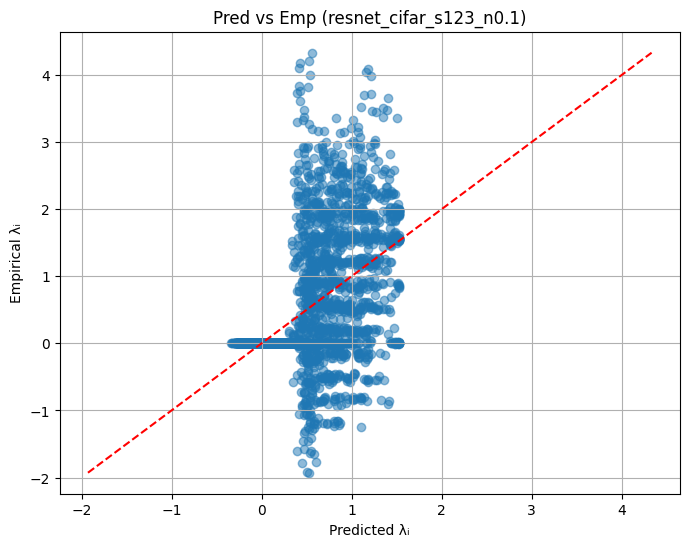

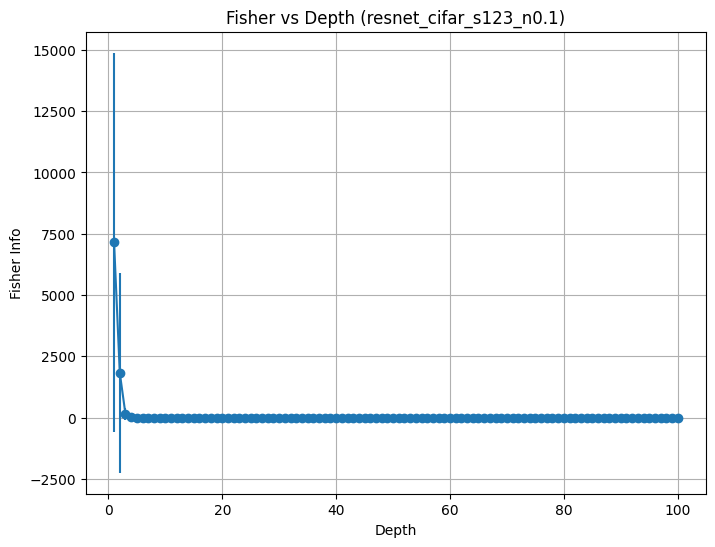

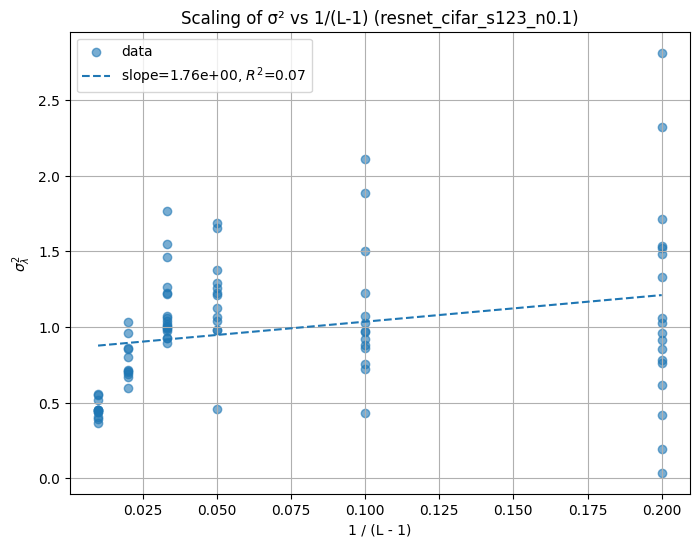


Experiment 32/60: arch=resnet, dataset=cifar, seed=123, noise=0.2
Running run_id       : resnet_cifar_s123_n0.2

Resize scale factor  : 1.16  →  target size 37
Input shape          : (36, 3, 37, 37)


Measuring models: 100%|██████████| 100/100 [17:02<00:00, 10.22s/it]


Generated models accepted       : 86
Unique datapoints               : 2778


>>> λᵢ Prediction
  R²    : 0.250
  RMSE  : 0.811
  Coefficients:
    skip_width: -0.000
    inv_c     : -1.656
    layer_index: -0.457
    block_depth: +0.095
    res_type  : +0.033
    kernel_size: +0.055
    stride    : +0.059
    bottleneck: +0.020
    projection: +0.027
    activation: -0.012
    bias       : +1.738


>>> Fisher Prediction
  R²    : 0.178
  RMSE  : 1800.609
  Coefficients:
    skip_width: -0.144
    inv_c     : -9237.874
    layer_index: -559.233
    block_depth: -1649.061
    res_type  : -885.441
    kernel_size: -150.754
    stride    : -1398.078
    bottleneck: +846.098
    projection: +23.640
    activation: -289.365
    bias       : +3975.596

>>> Scaling with Depth
  λᵢ  ~ depth^0.010   (R² = 0.000)
  F   ~ depth^-5.619   (R² = 0.748)

>>> Per Fisher Bin Analysis
  Fisher range    : [6.84, 5809.86]
  Depth  range    : [6, 101]
  std(λ) range    : [0.19, 1.68]
  Valid FI bins   : 2 / 20
    FI ≈ 6.84 | Shallow: 14, Deep: 14, Ratio: 0.734
    FI ≈ 312.26 | Shallow: 11, Deep: 8, Ratio: 0.780
  λ variation ratio : 0.757 ± 0.032 (p = 0.0000)
  mean CV(bin)       : 0.210  ± 0.003
  max  CV(bin)       : 0.213
  Mutual information (std λ  vs. architecture features) per FI‐bin:
 fisher_level  mi_std_lambda  mi_pval
     6.835051   0.000000e+00      1.0
   312.257405   0.000000e+00     

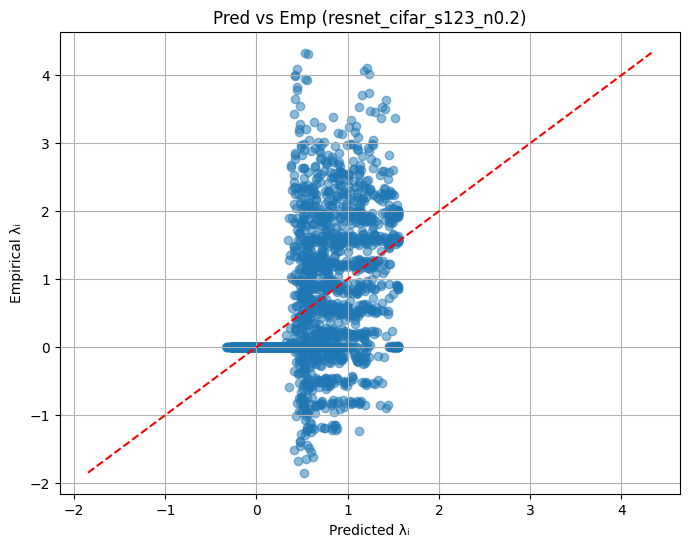

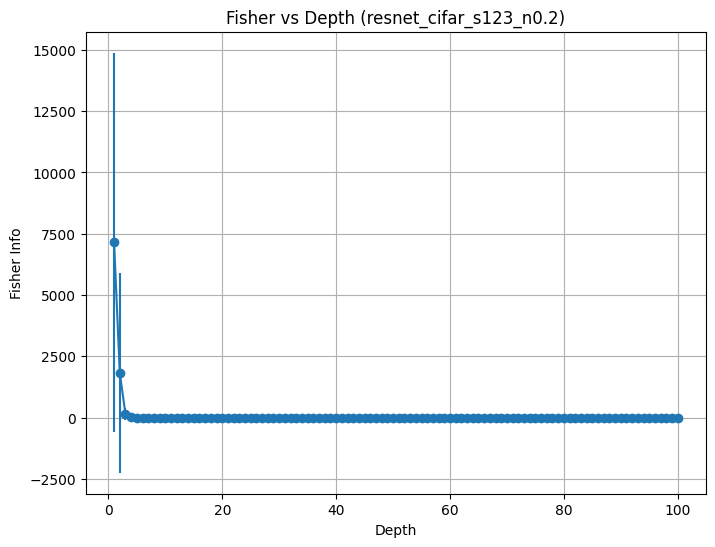

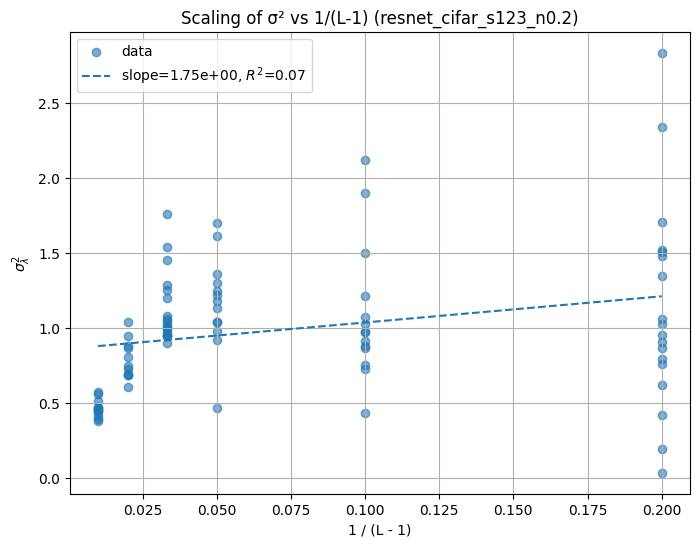


Experiment 33/60: arch=resnet, dataset=cifar, seed=123, noise=0.5
Running run_id       : resnet_cifar_s123_n0.5

Resize scale factor  : 1.16  →  target size 37
Input shape          : (36, 3, 37, 37)


Measuring models: 100%|██████████| 100/100 [16:53<00:00, 10.13s/it]


Generated models accepted       : 86
Unique datapoints               : 2778


>>> λᵢ Prediction
  R²    : 0.246
  RMSE  : 0.820
  Coefficients:
    skip_width: -0.000
    inv_c     : -1.561
    layer_index: -0.458
    block_depth: +0.088
    res_type  : +0.031
    kernel_size: +0.057
    stride    : +0.036
    bottleneck: +0.009
    projection: +0.021
    activation: -0.009
    bias       : +1.776


>>> Fisher Prediction
  R²    : 0.178
  RMSE  : 1800.609
  Coefficients:
    skip_width: -0.144
    inv_c     : -9237.874
    layer_index: -559.233
    block_depth: -1649.061
    res_type  : -885.441
    kernel_size: -150.754
    stride    : -1398.078
    bottleneck: +846.098
    projection: +23.640
    activation: -289.365
    bias       : +3975.596

>>> Scaling with Depth
  λᵢ  ~ depth^0.025   (R² = 0.000)
  F   ~ depth^-5.619   (R² = 0.748)

>>> Per Fisher Bin Analysis
  Fisher range    : [6.84, 5809.86]
  Depth  range    : [6, 101]
  std(λ) range    : [0.18, 1.71]
  Valid FI bins   : 2 / 20
    FI ≈ 6.84 | Shallow: 14, Deep: 14, Ratio: 0.758
    FI ≈ 312.26 | Shallow: 11, Deep: 8, Ratio: 0.794
  λ variation ratio : 0.776 ± 0.026 (p = 0.0000)
  mean CV(bin)       : 0.206  ± 0.005
  max  CV(bin)       : 0.211
  Mutual information (std λ  vs. architecture features) per FI‐bin:
 fisher_level  mi_std_lambda  mi_pval
     6.835051   0.000000e+00      1.0
   312.257405   0.000000e+00     

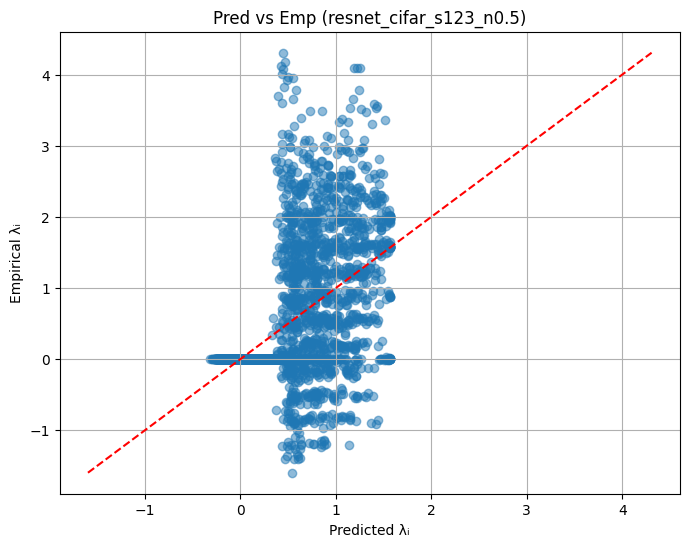

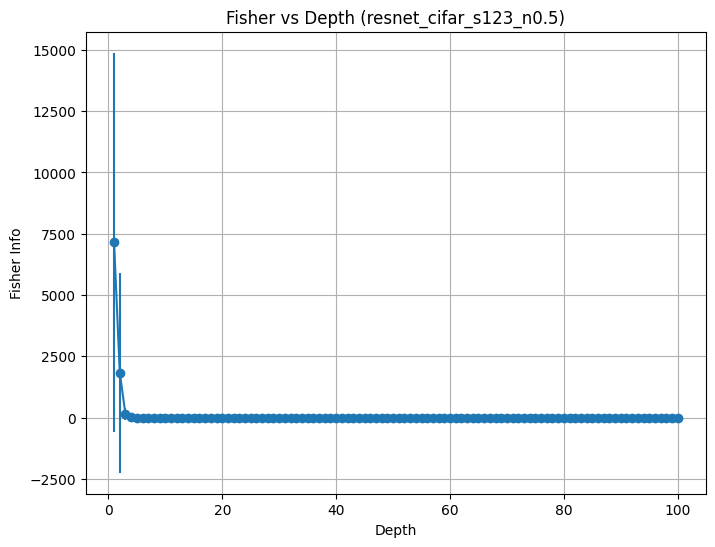

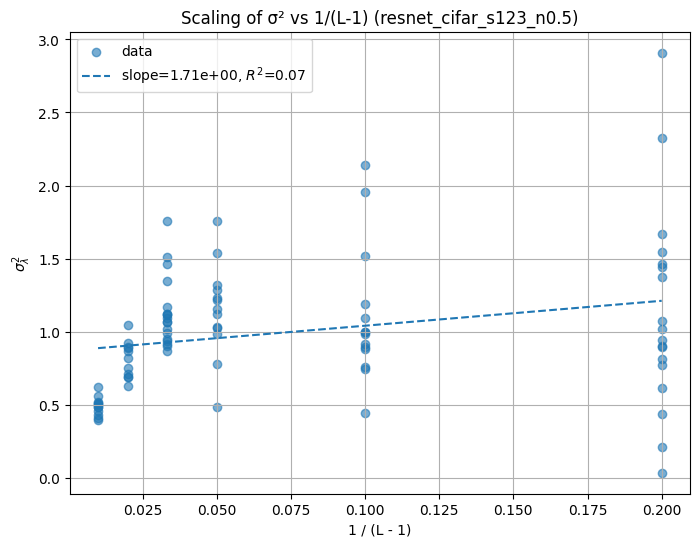


Experiment 34/60: arch=resnet, dataset=mnist, seed=123, noise=0.1
Running run_id       : resnet_mnist_s123_n0.1

Resize scale factor  : 1.16  →  target size 32
Input shape          : (36, 1, 32, 32)


Measuring models: 100%|██████████| 100/100 [19:26<00:00, 11.67s/it]


Generated models accepted       : 84
Unique datapoints               : 2850


>>> λᵢ Prediction
  R²    : 0.267
  RMSE  : 0.767
  Coefficients:
    skip_width: -0.000
    inv_c     : -0.852
    layer_index: -0.446
    block_depth: +0.121
    res_type  : +0.037
    kernel_size: +0.049
    stride    : +0.171
    bottleneck: -0.056
    projection: -0.007
    activation: -0.009
    bias       : +1.632


>>> Fisher Prediction
  R²    : 0.145
  RMSE  : 1532.389
  Coefficients:
    skip_width: -0.138
    inv_c     : -8269.285
    layer_index: -425.418
    block_depth: -1234.104
    res_type  : -665.815
    kernel_size: -96.790
    stride    : -1002.086
    bottleneck: +725.935
    projection: -10.008
    activation: -203.546
    bias       : +2946.280

>>> Scaling with Depth
  λᵢ  ~ depth^-0.184   (R² = 0.014)
  F   ~ depth^-5.443   (R² = 0.736)

>>> Per Fisher Bin Analysis
  Fisher range    : [3.30, 4903.30]
  Depth  range    : [6, 101]
  std(λ) range    : [0.50, 1.72]
  Valid FI bins   : 2 / 20
    FI ≈ 3.30 | Shallow: 18, Deep: 16, Ratio: 0.643
    FI ≈ 261.20 | Shallow: 6, Deep: 6, Ratio: 0.869
  λ variation ratio : 0.756 ± 0.160 (p = 0.0000)
  mean CV(bin)       : 0.235  ± 0.041
  max  CV(bin)       : 0.276
  Mutual information (std λ  vs. architecture features) per FI‐bin:
 fisher_level  mi_std_lambda  mi_pval
     3.301558   0.000000e+00 1.000000
   261.195956   3.125000e-02 0.472

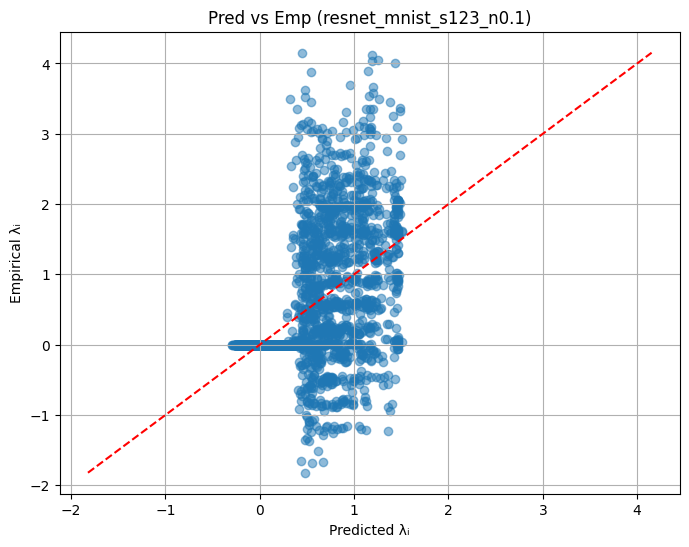

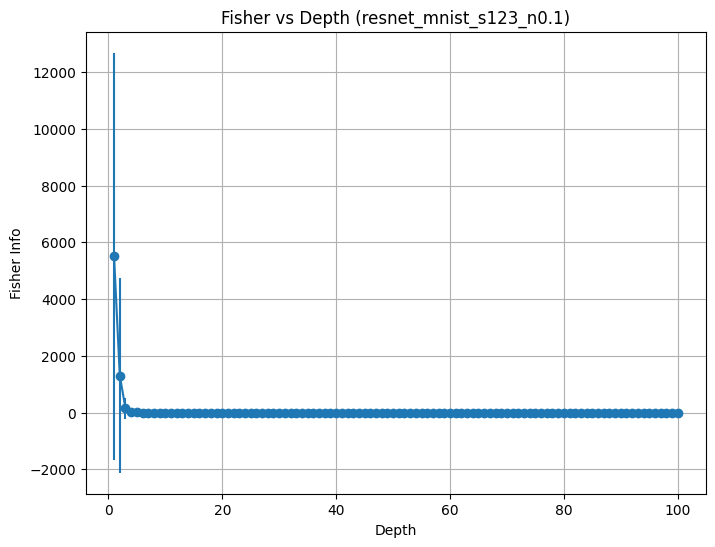

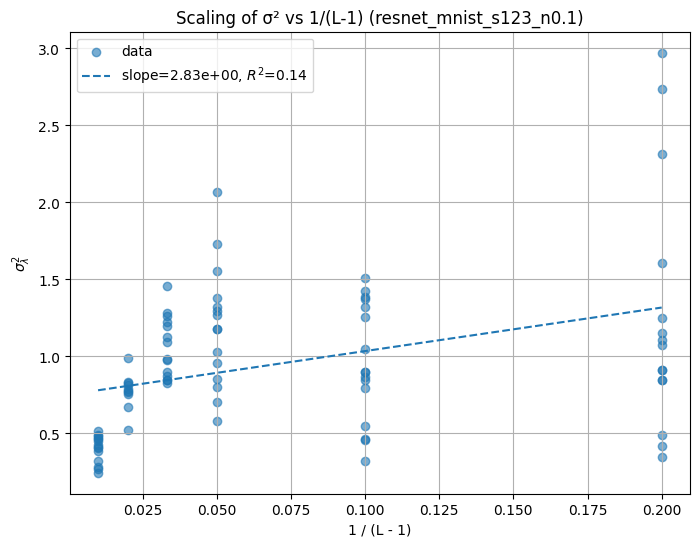


Experiment 35/60: arch=resnet, dataset=mnist, seed=123, noise=0.2
Running run_id       : resnet_mnist_s123_n0.2

Resize scale factor  : 1.16  →  target size 32
Input shape          : (36, 1, 32, 32)


Measuring models: 100%|██████████| 100/100 [19:58<00:00, 11.99s/it]


Generated models accepted       : 84
Unique datapoints               : 2850


>>> λᵢ Prediction
  R²    : 0.263
  RMSE  : 0.775
  Coefficients:
    skip_width: -0.000
    inv_c     : -0.902
    layer_index: -0.447
    block_depth: +0.122
    res_type  : +0.046
    kernel_size: +0.047
    stride    : +0.156
    bottleneck: -0.061
    projection: -0.011
    activation: -0.007
    bias       : +1.661


>>> Fisher Prediction
  R²    : 0.145
  RMSE  : 1532.389
  Coefficients:
    skip_width: -0.138
    inv_c     : -8269.285
    layer_index: -425.418
    block_depth: -1234.104
    res_type  : -665.815
    kernel_size: -96.790
    stride    : -1002.086
    bottleneck: +725.935
    projection: -10.008
    activation: -203.546
    bias       : +2946.280

>>> Scaling with Depth
  λᵢ  ~ depth^-0.132   (R² = 0.007)
  F   ~ depth^-5.443   (R² = 0.736)

>>> Per Fisher Bin Analysis
  Fisher range    : [3.30, 4903.30]
  Depth  range    : [6, 101]
  std(λ) range    : [0.50, 1.73]
  Valid FI bins   : 2 / 20
    FI ≈ 3.30 | Shallow: 18, Deep: 16, Ratio: 0.657
    FI ≈ 261.20 | Shallow: 6, Deep: 6, Ratio: 0.878
  λ variation ratio : 0.767 ± 0.156 (p = 0.0000)
  mean CV(bin)       : 0.231  ± 0.037
  max  CV(bin)       : 0.268
  Mutual information (std λ  vs. architecture features) per FI‐bin:
 fisher_level  mi_std_lambda  mi_pval
     3.301558   0.000000e+00  1.00000
   261.195956   3.125000e-02  0.39

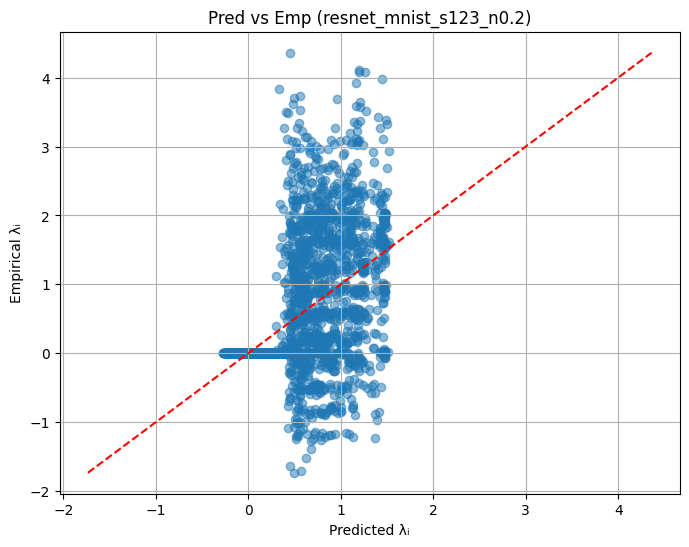

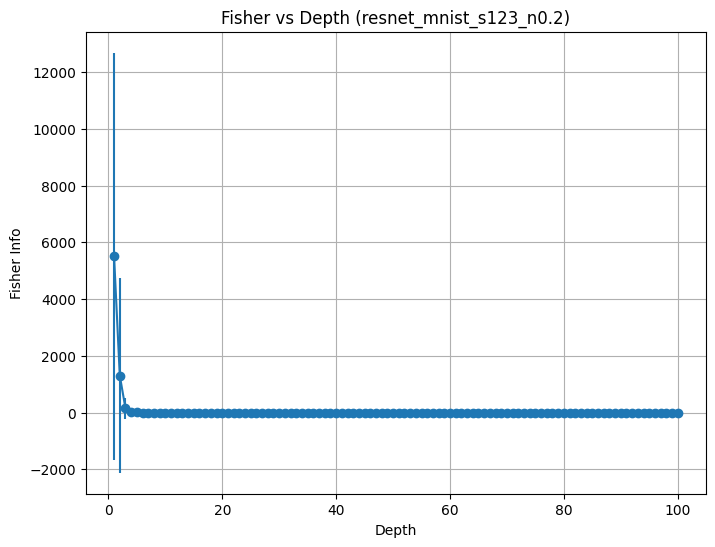

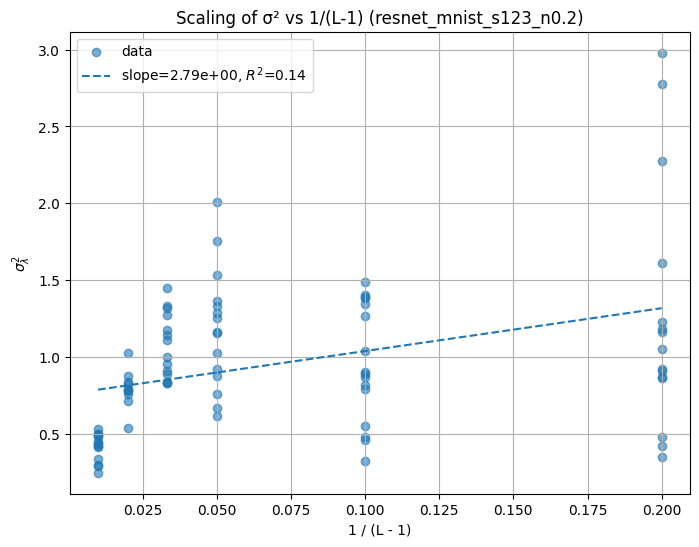


Experiment 36/60: arch=resnet, dataset=mnist, seed=123, noise=0.5
Running run_id       : resnet_mnist_s123_n0.5

Resize scale factor  : 1.16  →  target size 32
Input shape          : (36, 1, 32, 32)


Measuring models:   4%|▍         | 4/100 [00:23<09:19,  5.82s/it]

In [ ]:
architecture_configs = {
    'cnn': {
        'depth_choices': [2,5,10,20,30,50,100],
        'resize_range': (1.0, 4.0),
        'param_ranges': {
            'strides':  [1,2,3],
            'kernels':  [3,5,7,9,11,13,15,17],
            'channels': [8,16,32,64,128,256,512,1024]
        },
        'use_leaky_relu': True,    
        'use_batchnorm':  False,    
        'feature_config': [
            {"name":"s_r",     "normalize":True, "log":True,  "power_law":True},
            {"name":"inv_c",   "normalize":False,"log":True,  "power_law":False},
            {"name":"d",       "normalize":False,"log":True,  "power_law":False},
            {"name":"o",       "normalize":True, "log":False, "power_law":False},
        ]
    },
    'resnet': {
        'depth_choices': [2,5,10,20,30,50,100],
        'resize_range': (1.0, 4.0),
        'param_ranges': {
            'channels':          [16,32,64,128,256,512,1024],
            'block_sizes':       [1,2,3,4,5],
            'kernel_sizes':      [1,3,5,7,9],
            'strides':           [1,2,3],
            'bottleneck_ratios':[1,0.75,0.5,0.25,0.125],
            'projection_types': ['identity','conv1x1'],
            'activation_functions':['relu','leaky_relu']
        },
        'feature_config': [
            {"name":"skip_width",  "normalize":False,"log":False,"power_law":False},
            {"name":"inv_c",       "normalize":False,"log":True, "power_law":False},
            {"name":"layer_index", "normalize":False,"log":True, "power_law":False},
            {"name":"block_depth", "normalize":True, "log":False,"power_law":False},
            {"name":"res_type",    "normalize":False,"log":False,"power_law":False},
            {"name":"kernel_size", "normalize":False,"log":True, "power_law":False},
            {"name":"stride",      "normalize":False,"log":True, "power_law":False},
            {"name":"bottleneck",  "normalize":False,"log":True, "power_law":False},
            {"name":"projection",  "normalize":False,"log":False,"power_law":False},
            {"name":"activation",  "normalize":False,"log":False,"power_law":False},
        ]
    }
}

import time
t0 = time.time()

results, analysis = run_statistical_consistency_experiments(
    seeds=[1,12,123,1234,12345],
    architectures=['cnn','resnet'],
    datasets=['cifar','mnist'],
    data_fraction=0.0036,
    n_models=100,
    make_plots=True,
    noise_levels=[0.1, 0.2, 0.5],
    n_bootstrap=200,
    n_variance_levels=20,
    architecture_configs=architecture_configs
)

t1 = time.time()
print(f"\nTotal elapsed time: {t1 - t0:.2f} seconds")